# **Preprocessing the Data**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/MyDrive/My Datasets/xPLNet.zip" -d /content/data

Streaming output truncated to the last 5000 lines.
  inflating: /content/data/DATASET/Training Samples/8/18758.png  
 extracting: /content/data/DATASET/Training Samples/8/18764.png  
 extracting: /content/data/DATASET/Training Samples/8/18780.png  
 extracting: /content/data/DATASET/Training Samples/8/18787.png  
 extracting: /content/data/DATASET/Training Samples/8/18809.png  
 extracting: /content/data/DATASET/Training Samples/8/18814.png  
 extracting: /content/data/DATASET/Training Samples/8/18840.png  
 extracting: /content/data/DATASET/Training Samples/8/18853.png  
 extracting: /content/data/DATASET/Training Samples/8/18863.png  
 extracting: /content/data/DATASET/Training Samples/8/18875.png  
 extracting: /content/data/DATASET/Training Samples/8/18876.png  
 extracting: /content/data/DATASET/Training Samples/8/1889.png  
 extracting: /content/data/DATASET/Training Samples/8/18895.png  
 extracting: /content/data/DATASET/Training Samples/8/18909.png  
 extracting: /content/data

In [ ]:
import os
from shutil import copyfile
from sklearn.model_selection import train_test_split
from shutil import rmtree
import tqdm
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers, models
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
from google.colab import files
from keras.layers import (
  Dense,
  Conv2D,
  GlobalMaxPooling2D,
  GlobalAveragePooling2D,
  MaxPooling2D,
  BatchNormalization,
  Dropout,
  Flatten,
  MaxPool2D,
  SeparableConv2D
)
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
IMG_SIZE = (75, 75)
BATCH_SIZE = 32
# Import necessary libraries
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

# Set the paths to the directories containing the data for each set
train_dir = '/content/data/DATASET/Training Samples'
test_dir = '/content/data/DATASET/Test Samples'

data_generator = ImageDataGenerator(
    rescale=1.0/255.0,                      
    featurewise_center=True,                                     
    rotation_range=90,                      
    width_shift_range=0.1,                  
    height_shift_range=0.1,                 
    vertical_flip=True,                    
    horizontal_flip=True,                
    validation_split=0.2
)

train_gen = data_generator.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

test_generator = ImageDataGenerator(
    rescale=1.0/255.0,
)

validation_gen = data_generator.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset='validation'
)

test_gen = test_generator.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
)


Found 47351 images belonging to 9 classes.
Found 11833 images belonging to 9 classes.
Found 6576 images belonging to 9 classes.


In [ ]:
import tqdm
import numpy as np

def create_dataset(data, BATCH_SIZE, num_images):
    data.reset()
    X, y = data.next()
    for i in tqdm.tqdm(range(int(num_images/BATCH_SIZE))):
        img, label = data.next()
        X = np.append(X, img, axis=0)
        y = np.append(y, label, axis=0)
        if i == int(num_images/BATCH_SIZE)-1:
            break
    
    return X, y

num_train = 3000
num_test = 500
num_val = 900

X_train, y_train = create_dataset(train_gen, BATCH_SIZE, num_train)
X_val, y_val = create_dataset(validation_gen, BATCH_SIZE, num_val)
X_test, y_test = create_dataset(test_gen, BATCH_SIZE, num_test)

print(f"\nX-train shape: {X_train.shape}")
print(f"y-train shape: {y_train.shape}")
print(f"X-val shape: {X_val.shape}")
print(f"y-val shape: {y_val.shape}")
print(f"X-test shape: {X_test.shape}")
print(f"y-test shape: {y_test.shape}")

/usr/local/lib/python3.9/dist-packages/keras/preprocessing/image.py:1861: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(
 97%|█████████▋| 30/31 [02:40<00:05,  5.34s/it]


X-train shape: (3008, 75, 75, 3)
y-train shape: (3008, 9)
X-val shape: (912, 75, 75, 3)
y-val shape: (912, 9)
X-test shape: (512, 75, 75, 3)
y-test shape: (512, 9)


# **Creating CNN from scratch**

## **Using Grid Search to find best parameters for CNN+SOFTMAX**

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.optimizers import Adam
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

# Define the CNN model architecture
def create_model(num_filters, kernel_size, pool_size, num_dense_layers, num_dense_units, learning_rate):
    model = Sequential()
    model.add(Conv2D(filters=num_filters, kernel_size=(kernel_size), padding="Same", activation="relu", input_shape=X_train.shape[1:]))
    model.add(MaxPooling2D(pool_size=pool_size))
    for i in range(num_dense_layers):
        model.add(Dense(num_dense_units, activation='relu'))
    model.add(Flatten())
    model.add(Dense(10, activation='softmax'))

    optimizer = Adam(lr=learning_rate)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

# Define the hyperparameters and their values to be tuned
param_grid = {
    'num_filters': [8, 16, 32],
    'kernel_size': [(3, 3), (5, 5)],
    'pool_size': [(2, 2), (3, 3)],
    'num_dense_layers': [1, 2],
    'num_dense_units': [32, 64],
    'learning_rate': [0.001, 0.01]
}


# Create a KerasClassifier object for the model
model = KerasClassifier(build_fn=create_model, epochs=20, batch_size=32, verbose=1)

from tensorflow.keras.utils import to_categorical

# Convert target labels to one-hot encoded format
y_train_categorical = to_categorical(y_train, num_classes=10)
y_train = np.argmax(y_train_categorical, axis=1) # Convert back to original form

# Use GridSearchCV to search the hyperparameters
grid_search = GridSearchCV(model, param_grid=param_grid, cv=3, verbose=1)
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and the corresponding accuracy
print("Best parameters: ", grid_search.best_params_)
print("Best accuracy: ", grid_search.best_score_)

<ipython-input-8-d3ed261c6c22>:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model, epochs=20, batch_size=32, verbose=1)


Fitting 3 folds for each of 96 candidates, totalling 288 fits
Epoch 1/20
63/63 [==============================] - 2s 6ms/step - loss: 8.9489 - accuracy: 0.8748
Epoch 2/20
63/63 [==============================] - 0s 6ms/step - loss: 80.5132 - accuracy: 0.8888
Epoch 3/20
63/63 [==============================] - 0s 6ms/step - loss: 361.6293 - accuracy: 0.8888
Epoch 4/20
63/63 [==============================] - 0s 5ms/step - loss: 1042.7415 - accuracy: 0.8888
Epoch 5/20
63/63 [==============================] - 0s 5ms/step - loss: 2509.7683 - accuracy: 0.8888
Epoch 6/20
63/63 [==============================] - 0s 5ms/step - loss: 5038.7129 - accuracy: 0.8888
Epoch 7/20
63/63 [==============================] - 0s 6ms/step - loss: 7943.9712 - accuracy: 0.8888
Epoch 8/20
63/63 [==============================] - 0s 5ms/step - loss: 12551.0439 - accuracy: 0.8888
Epoch 9/20
63/63 [==============================] - 0s 7ms/step - loss: 18328.7363 - accuracy: 0.8888
Epoch 10/20
63/63 [==============

Epoch 1/20
63/63 [==============================] - 2s 6ms/step - loss: 8.1866 - accuracy: 0.8858
Epoch 2/20
63/63 [==============================] - 0s 5ms/step - loss: 104.1833 - accuracy: 0.9017
Epoch 3/20
63/63 [==============================] - 0s 6ms/step - loss: 527.4216 - accuracy: 0.9017
Epoch 4/20
63/63 [==============================] - 0s 5ms/step - loss: 1429.1233 - accuracy: 0.9017
Epoch 5/20
63/63 [==============================] - 0s 5ms/step - loss: 3291.5288 - accuracy: 0.9017
Epoch 6/20
63/63 [==============================] - 0s 6ms/step - loss: 6153.0474 - accuracy: 0.9017
Epoch 7/20
63/63 [==============================] - 0s 6ms/step - loss: 10271.0918 - accuracy: 0.9017
Epoch 8/20
63/63 [==============================] - 0s 6ms/step - loss: 15222.8643 - accuracy: 0.9017
Epoch 9/20
63/63 [==============================] - 0s 5ms/step - loss: 22079.4688 - accuracy: 0.9017
Epoch 10/20
63/63 [==============================] - 0s 5ms/step - loss: 32878.4258 - accurac

Epoch 1/20
63/63 [==============================] - 2s 6ms/step - loss: 7.1206 - accuracy: 0.8749
Epoch 2/20
63/63 [==============================] - 0s 6ms/step - loss: 83.0104 - accuracy: 0.8893
Epoch 3/20
63/63 [==============================] - 0s 5ms/step - loss: 389.6767 - accuracy: 0.8893
Epoch 4/20
63/63 [==============================] - 0s 6ms/step - loss: 1261.1870 - accuracy: 0.8893
Epoch 5/20
63/63 [==============================] - 0s 6ms/step - loss: 2955.7021 - accuracy: 0.8893
Epoch 6/20
63/63 [==============================] - 0s 6ms/step - loss: 5580.1382 - accuracy: 0.8893
Epoch 7/20
63/63 [==============================] - 0s 6ms/step - loss: 8744.2158 - accuracy: 0.8893
Epoch 8/20
63/63 [==============================] - 0s 5ms/step - loss: 14136.3838 - accuracy: 0.8893
Epoch 9/20
63/63 [==============================] - 0s 5ms/step - loss: 22059.1230 - accuracy: 0.8893
Epoch 10/20
63/63 [==============================] - 0s 6ms/step - loss: 31713.9590 - accuracy:

Epoch 1/20
63/63 [==============================] - 2s 5ms/step - loss: 4.1427 - accuracy: 0.8748
Epoch 2/20
63/63 [==============================] - 0s 5ms/step - loss: 44.6165 - accuracy: 0.8888
Epoch 3/20
63/63 [==============================] - 0s 5ms/step - loss: 235.8097 - accuracy: 0.8888
Epoch 4/20
63/63 [==============================] - 0s 5ms/step - loss: 658.3443 - accuracy: 0.8888
Epoch 5/20
63/63 [==============================] - 0s 5ms/step - loss: 1634.7968 - accuracy: 0.8888
Epoch 6/20
63/63 [==============================] - 0s 5ms/step - loss: 2907.8386 - accuracy: 0.8888
Epoch 7/20
63/63 [==============================] - 0s 5ms/step - loss: 4807.2500 - accuracy: 0.8888
Epoch 8/20
63/63 [==============================] - 0s 5ms/step - loss: 8130.5132 - accuracy: 0.8888
Epoch 9/20
63/63 [==============================] - 0s 6ms/step - loss: 11088.5566 - accuracy: 0.8888
Epoch 10/20
63/63 [==============================] - 0s 5ms/step - loss: 15603.8486 - accuracy: 0

Epoch 1/20
63/63 [==============================] - 2s 7ms/step - loss: 4.5254 - accuracy: 0.8878
Epoch 2/20
63/63 [==============================] - 0s 7ms/step - loss: 48.2296 - accuracy: 0.9017
Epoch 3/20
63/63 [==============================] - 0s 7ms/step - loss: 231.1411 - accuracy: 0.9017
Epoch 4/20
63/63 [==============================] - 0s 7ms/step - loss: 569.5037 - accuracy: 0.9017
Epoch 5/20
63/63 [==============================] - 0s 5ms/step - loss: 1395.1766 - accuracy: 0.9017
Epoch 6/20
63/63 [==============================] - 0s 5ms/step - loss: 2613.9131 - accuracy: 0.9017
Epoch 7/20
63/63 [==============================] - 0s 5ms/step - loss: 4587.0796 - accuracy: 0.9017
Epoch 8/20
63/63 [==============================] - 0s 5ms/step - loss: 6857.6650 - accuracy: 0.9017
Epoch 9/20
63/63 [==============================] - 0s 5ms/step - loss: 9992.5703 - accuracy: 0.9017
Epoch 10/20
63/63 [==============================] - 0s 5ms/step - loss: 13900.2725 - accuracy: 0.

Epoch 1/20
63/63 [==============================] - 1s 5ms/step - loss: 3.7215 - accuracy: 0.8774
Epoch 2/20
63/63 [==============================] - 0s 7ms/step - loss: 40.1241 - accuracy: 0.8893
Epoch 3/20
63/63 [==============================] - 0s 7ms/step - loss: 213.0241 - accuracy: 0.8893
Epoch 4/20
63/63 [==============================] - 0s 7ms/step - loss: 630.9932 - accuracy: 0.8893
Epoch 5/20
63/63 [==============================] - 0s 7ms/step - loss: 1255.5573 - accuracy: 0.8893
Epoch 6/20
63/63 [==============================] - 0s 6ms/step - loss: 2480.7913 - accuracy: 0.8893
Epoch 7/20
63/63 [==============================] - 0s 7ms/step - loss: 3894.0171 - accuracy: 0.8893
Epoch 8/20
63/63 [==============================] - 0s 7ms/step - loss: 6231.2256 - accuracy: 0.8893
Epoch 9/20
63/63 [==============================] - 0s 7ms/step - loss: 9258.4404 - accuracy: 0.8893
Epoch 10/20
63/63 [==============================] - 0s 7ms/step - loss: 13340.6162 - accuracy: 0.

Epoch 1/20
63/63 [==============================] - 2s 6ms/step - loss: 14.0582 - accuracy: 0.8768
Epoch 2/20
63/63 [==============================] - 0s 6ms/step - loss: 165.9922 - accuracy: 0.8888
Epoch 3/20
63/63 [==============================] - 0s 6ms/step - loss: 876.2087 - accuracy: 0.8888
Epoch 4/20
63/63 [==============================] - 0s 6ms/step - loss: 2421.8750 - accuracy: 0.8888
Epoch 5/20
63/63 [==============================] - 0s 6ms/step - loss: 5749.9429 - accuracy: 0.8888
Epoch 6/20
63/63 [==============================] - 0s 6ms/step - loss: 10623.0986 - accuracy: 0.8888
Epoch 7/20
63/63 [==============================] - 0s 6ms/step - loss: 17972.7578 - accuracy: 0.8888
Epoch 8/20
63/63 [==============================] - 0s 6ms/step - loss: 29527.6973 - accuracy: 0.8888
Epoch 9/20
63/63 [==============================] - 0s 7ms/step - loss: 45357.5430 - accuracy: 0.8888
Epoch 10/20
63/63 [==============================] - 0s 6ms/step - loss: 62992.0586 - accur

Epoch 1/20
63/63 [==============================] - 2s 7ms/step - loss: 12.4111 - accuracy: 0.8898
Epoch 2/20
63/63 [==============================] - 0s 6ms/step - loss: 189.0282 - accuracy: 0.9017
Epoch 3/20
63/63 [==============================] - 0s 6ms/step - loss: 985.6606 - accuracy: 0.9017
Epoch 4/20
63/63 [==============================] - 0s 6ms/step - loss: 3783.1060 - accuracy: 0.9017
Epoch 5/20
63/63 [==============================] - 0s 5ms/step - loss: 7711.6802 - accuracy: 0.9017
Epoch 6/20
63/63 [==============================] - 0s 5ms/step - loss: 14439.8467 - accuracy: 0.9017
Epoch 7/20
63/63 [==============================] - 0s 6ms/step - loss: 23277.2305 - accuracy: 0.9017
Epoch 8/20
63/63 [==============================] - 0s 5ms/step - loss: 37861.1367 - accuracy: 0.9017
Epoch 9/20
63/63 [==============================] - 0s 6ms/step - loss: 51895.4570 - accuracy: 0.9017
Epoch 10/20
63/63 [==============================] - 0s 5ms/step - loss: 75899.6328 - accur

Epoch 1/20
63/63 [==============================] - 2s 7ms/step - loss: 9.1014 - accuracy: 0.8744
Epoch 2/20
63/63 [==============================] - 0s 6ms/step - loss: 137.1480 - accuracy: 0.8893
Epoch 3/20
63/63 [==============================] - 0s 6ms/step - loss: 825.8784 - accuracy: 0.8893
Epoch 4/20
63/63 [==============================] - 0s 7ms/step - loss: 2406.9180 - accuracy: 0.8893
Epoch 5/20
63/63 [==============================] - 0s 6ms/step - loss: 5995.4414 - accuracy: 0.8893
Epoch 6/20
63/63 [==============================] - 0s 6ms/step - loss: 11633.9121 - accuracy: 0.8893
Epoch 7/20
63/63 [==============================] - 0s 6ms/step - loss: 20735.0723 - accuracy: 0.8893
Epoch 8/20
63/63 [==============================] - 0s 6ms/step - loss: 30370.3730 - accuracy: 0.8893
Epoch 9/20
63/63 [==============================] - 0s 7ms/step - loss: 46768.5312 - accuracy: 0.8893
Epoch 10/20
63/63 [==============================] - 0s 6ms/step - loss: 66005.2812 - accura

Epoch 1/20
63/63 [==============================] - 2s 7ms/step - loss: 5.6840 - accuracy: 0.8733
Epoch 2/20
63/63 [==============================] - 0s 8ms/step - loss: 66.0898 - accuracy: 0.8888
Epoch 3/20
63/63 [==============================] - 0s 7ms/step - loss: 363.6097 - accuracy: 0.8888
Epoch 4/20
63/63 [==============================] - 0s 6ms/step - loss: 1286.4885 - accuracy: 0.8888
Epoch 5/20
63/63 [==============================] - 0s 7ms/step - loss: 3482.4460 - accuracy: 0.8888
Epoch 6/20
63/63 [==============================] - 0s 6ms/step - loss: 6319.4834 - accuracy: 0.8888
Epoch 7/20
63/63 [==============================] - 0s 6ms/step - loss: 11017.3633 - accuracy: 0.8888
Epoch 8/20
63/63 [==============================] - 0s 6ms/step - loss: 17690.1445 - accuracy: 0.8888
Epoch 9/20
63/63 [==============================] - 0s 5ms/step - loss: 25979.5977 - accuracy: 0.8888
Epoch 10/20
63/63 [==============================] - 0s 6ms/step - loss: 37419.5273 - accuracy

Epoch 1/20
63/63 [==============================] - 1s 5ms/step - loss: 6.8983 - accuracy: 0.8878
Epoch 2/20
63/63 [==============================] - 0s 5ms/step - loss: 81.4940 - accuracy: 0.9017
Epoch 3/20
63/63 [==============================] - 0s 5ms/step - loss: 383.0085 - accuracy: 0.9017
Epoch 4/20
63/63 [==============================] - 0s 7ms/step - loss: 1055.7402 - accuracy: 0.9017
Epoch 5/20
63/63 [==============================] - 1s 8ms/step - loss: 2404.9902 - accuracy: 0.9017
Epoch 6/20
63/63 [==============================] - 0s 8ms/step - loss: 4862.1680 - accuracy: 0.9017
Epoch 7/20
63/63 [==============================] - 1s 8ms/step - loss: 8195.6143 - accuracy: 0.9017
Epoch 8/20
63/63 [==============================] - 0s 7ms/step - loss: 13221.5361 - accuracy: 0.9017
Epoch 9/20
63/63 [==============================] - 0s 8ms/step - loss: 19185.3770 - accuracy: 0.9017
Epoch 10/20
63/63 [==============================] - 0s 8ms/step - loss: 26869.4043 - accuracy:

Epoch 1/20
63/63 [==============================] - 2s 6ms/step - loss: 6.7094 - accuracy: 0.8799
Epoch 2/20
63/63 [==============================] - 0s 5ms/step - loss: 92.6506 - accuracy: 0.8893
Epoch 3/20
63/63 [==============================] - 0s 5ms/step - loss: 485.4458 - accuracy: 0.8893
Epoch 4/20
63/63 [==============================] - 0s 5ms/step - loss: 1598.7472 - accuracy: 0.8893
Epoch 5/20
63/63 [==============================] - 0s 5ms/step - loss: 3339.6501 - accuracy: 0.8893
Epoch 6/20
63/63 [==============================] - 0s 5ms/step - loss: 5964.8325 - accuracy: 0.8893
Epoch 7/20
63/63 [==============================] - 0s 5ms/step - loss: 10578.4717 - accuracy: 0.8893
Epoch 8/20
63/63 [==============================] - 0s 5ms/step - loss: 15866.7764 - accuracy: 0.8893
Epoch 9/20
63/63 [==============================] - 0s 5ms/step - loss: 24041.6367 - accuracy: 0.8893
Epoch 10/20
63/63 [==============================] - 0s 5ms/step - loss: 32389.1953 - accuracy

Epoch 1/20
63/63 [==============================] - 2s 7ms/step - loss: 18.0249 - accuracy: 0.8768
Epoch 2/20
63/63 [==============================] - 0s 7ms/step - loss: 305.8619 - accuracy: 0.8888
Epoch 3/20
63/63 [==============================] - 0s 6ms/step - loss: 2035.3455 - accuracy: 0.8888
Epoch 4/20
63/63 [==============================] - 0s 6ms/step - loss: 5218.5513 - accuracy: 0.8888
Epoch 5/20
63/63 [==============================] - 0s 6ms/step - loss: 13721.2148 - accuracy: 0.8888
Epoch 6/20
63/63 [==============================] - 0s 6ms/step - loss: 27086.5352 - accuracy: 0.8888
Epoch 7/20
63/63 [==============================] - 0s 6ms/step - loss: 44373.7109 - accuracy: 0.8888
Epoch 8/20
63/63 [==============================] - 0s 6ms/step - loss: 71232.8984 - accuracy: 0.8888
Epoch 9/20
63/63 [==============================] - 0s 6ms/step - loss: 97297.6875 - accuracy: 0.8888
Epoch 10/20
63/63 [==============================] - 0s 6ms/step - loss: 150087.2344 - ac

Epoch 1/20
63/63 [==============================] - 2s 7ms/step - loss: 18.8362 - accuracy: 0.8918
Epoch 2/20
63/63 [==============================] - 0s 7ms/step - loss: 272.4343 - accuracy: 0.9017
Epoch 3/20
63/63 [==============================] - 0s 6ms/step - loss: 1366.2087 - accuracy: 0.9017
Epoch 4/20
63/63 [==============================] - 0s 6ms/step - loss: 4788.8110 - accuracy: 0.9017
Epoch 5/20
63/63 [==============================] - 0s 6ms/step - loss: 12002.1006 - accuracy: 0.9017
Epoch 6/20
63/63 [==============================] - 0s 6ms/step - loss: 23288.7461 - accuracy: 0.9017
Epoch 7/20
63/63 [==============================] - 0s 6ms/step - loss: 40260.5469 - accuracy: 0.9017
Epoch 8/20
63/63 [==============================] - 0s 6ms/step - loss: 62875.7773 - accuracy: 0.9017
Epoch 9/20
63/63 [==============================] - 0s 6ms/step - loss: 101832.4688 - accuracy: 0.9017
Epoch 10/20
63/63 [==============================] - 0s 6ms/step - loss: 138750.1719 - a

Epoch 1/20
63/63 [==============================] - 2s 8ms/step - loss: 15.9033 - accuracy: 0.8739
Epoch 2/20
63/63 [==============================] - 0s 6ms/step - loss: 283.2131 - accuracy: 0.8893
Epoch 3/20
63/63 [==============================] - 0s 6ms/step - loss: 1449.6562 - accuracy: 0.8893
Epoch 4/20
63/63 [==============================] - 0s 6ms/step - loss: 4404.0166 - accuracy: 0.8893
Epoch 5/20
63/63 [==============================] - 0s 6ms/step - loss: 9625.1611 - accuracy: 0.8893
Epoch 6/20
63/63 [==============================] - 0s 6ms/step - loss: 20067.5059 - accuracy: 0.8893
Epoch 7/20
63/63 [==============================] - 0s 6ms/step - loss: 30852.6250 - accuracy: 0.8893
Epoch 8/20
63/63 [==============================] - 0s 6ms/step - loss: 53751.3477 - accuracy: 0.8893
Epoch 9/20
63/63 [==============================] - 0s 6ms/step - loss: 79972.9922 - accuracy: 0.8893
Epoch 10/20
63/63 [==============================] - 0s 6ms/step - loss: 112765.6016 - acc

Epoch 1/20
63/63 [==============================] - 2s 6ms/step - loss: 9.1657 - accuracy: 0.8698
Epoch 2/20
63/63 [==============================] - 0s 6ms/step - loss: 133.6445 - accuracy: 0.8888
Epoch 3/20
63/63 [==============================] - 0s 6ms/step - loss: 762.3932 - accuracy: 0.8888
Epoch 4/20
63/63 [==============================] - 0s 6ms/step - loss: 2134.3062 - accuracy: 0.8888
Epoch 5/20
63/63 [==============================] - 0s 6ms/step - loss: 5647.4102 - accuracy: 0.8888
Epoch 6/20
63/63 [==============================] - 0s 6ms/step - loss: 10981.2275 - accuracy: 0.8888
Epoch 7/20
63/63 [==============================] - 0s 6ms/step - loss: 18939.2480 - accuracy: 0.8888
Epoch 8/20
63/63 [==============================] - 0s 6ms/step - loss: 28499.4395 - accuracy: 0.8888
Epoch 9/20
63/63 [==============================] - 0s 6ms/step - loss: 43015.1680 - accuracy: 0.8888
Epoch 10/20
63/63 [==============================] - 0s 6ms/step - loss: 62092.3008 - accura

Epoch 1/20
63/63 [==============================] - 2s 7ms/step - loss: 11.9519 - accuracy: 0.8883
Epoch 2/20
63/63 [==============================] - 0s 6ms/step - loss: 152.4520 - accuracy: 0.9017
Epoch 3/20
63/63 [==============================] - 0s 6ms/step - loss: 920.5747 - accuracy: 0.9017
Epoch 4/20
63/63 [==============================] - 0s 6ms/step - loss: 2498.9685 - accuracy: 0.9017
Epoch 5/20
63/63 [==============================] - 0s 6ms/step - loss: 6211.6460 - accuracy: 0.9017
Epoch 6/20
63/63 [==============================] - 0s 6ms/step - loss: 11331.6855 - accuracy: 0.9017
Epoch 7/20
63/63 [==============================] - 0s 6ms/step - loss: 18424.0371 - accuracy: 0.9017
Epoch 8/20
63/63 [==============================] - 0s 5ms/step - loss: 30187.0957 - accuracy: 0.9017
Epoch 9/20
63/63 [==============================] - 0s 6ms/step - loss: 44385.2695 - accuracy: 0.9017
Epoch 10/20
63/63 [==============================] - 0s 6ms/step - loss: 60603.7422 - accur

Epoch 1/20
63/63 [==============================] - 2s 7ms/step - loss: 12.8089 - accuracy: 0.8739
Epoch 2/20
63/63 [==============================] - 1s 8ms/step - loss: 161.7202 - accuracy: 0.8893
Epoch 3/20
63/63 [==============================] - 0s 7ms/step - loss: 930.1886 - accuracy: 0.8893
Epoch 4/20
63/63 [==============================] - 0s 8ms/step - loss: 2801.2456 - accuracy: 0.8893
Epoch 5/20
63/63 [==============================] - 0s 7ms/step - loss: 6450.9634 - accuracy: 0.8893
Epoch 6/20
63/63 [==============================] - 0s 7ms/step - loss: 11906.8037 - accuracy: 0.8893
Epoch 7/20
63/63 [==============================] - 0s 6ms/step - loss: 21217.2207 - accuracy: 0.8893
Epoch 8/20
63/63 [==============================] - 0s 6ms/step - loss: 32852.3906 - accuracy: 0.8893
Epoch 9/20
63/63 [==============================] - 0s 6ms/step - loss: 49293.2500 - accuracy: 0.8893
Epoch 10/20
63/63 [==============================] - 0s 6ms/step - loss: 67860.3125 - accur

Epoch 1/20
63/63 [==============================] - 2s 7ms/step - loss: 11.8886 - accuracy: 0.8748
Epoch 2/20
63/63 [==============================] - 0s 6ms/step - loss: 179.4271 - accuracy: 0.8888
Epoch 3/20
63/63 [==============================] - 0s 6ms/step - loss: 982.1902 - accuracy: 0.8888
Epoch 4/20
63/63 [==============================] - 0s 6ms/step - loss: 2688.7720 - accuracy: 0.8888
Epoch 5/20
63/63 [==============================] - 0s 7ms/step - loss: 6968.8013 - accuracy: 0.8888
Epoch 6/20
63/63 [==============================] - 0s 8ms/step - loss: 12512.5059 - accuracy: 0.8888
Epoch 7/20
63/63 [==============================] - 0s 7ms/step - loss: 21604.1914 - accuracy: 0.8888
Epoch 8/20
63/63 [==============================] - 0s 7ms/step - loss: 35843.3945 - accuracy: 0.8888
Epoch 9/20
63/63 [==============================] - 0s 7ms/step - loss: 54669.4531 - accuracy: 0.8888
Epoch 10/20
63/63 [==============================] - 0s 7ms/step - loss: 75724.2734 - accur

Epoch 1/20
63/63 [==============================] - 2s 6ms/step - loss: 13.0497 - accuracy: 0.8863
Epoch 2/20
63/63 [==============================] - 0s 6ms/step - loss: 216.0497 - accuracy: 0.9017
Epoch 3/20
63/63 [==============================] - 0s 6ms/step - loss: 972.2482 - accuracy: 0.9017
Epoch 4/20
63/63 [==============================] - 0s 6ms/step - loss: 3211.6006 - accuracy: 0.9017
Epoch 5/20
63/63 [==============================] - 0s 6ms/step - loss: 7745.5259 - accuracy: 0.9017
Epoch 6/20
63/63 [==============================] - 0s 6ms/step - loss: 14581.1953 - accuracy: 0.9017
Epoch 7/20
63/63 [==============================] - 0s 5ms/step - loss: 26845.5762 - accuracy: 0.9017
Epoch 8/20
63/63 [==============================] - 0s 5ms/step - loss: 42677.4375 - accuracy: 0.9017
Epoch 9/20
63/63 [==============================] - 0s 5ms/step - loss: 62832.3555 - accuracy: 0.9017
Epoch 10/20
63/63 [==============================] - 0s 6ms/step - loss: 88777.3750 - accur

Epoch 1/20
63/63 [==============================] - 2s 6ms/step - loss: 11.7294 - accuracy: 0.8734
Epoch 2/20
63/63 [==============================] - 0s 6ms/step - loss: 173.0059 - accuracy: 0.8893
Epoch 3/20
63/63 [==============================] - 0s 6ms/step - loss: 1024.0404 - accuracy: 0.8893
Epoch 4/20
63/63 [==============================] - 0s 6ms/step - loss: 3642.1997 - accuracy: 0.8893
Epoch 5/20
63/63 [==============================] - 0s 6ms/step - loss: 7888.5186 - accuracy: 0.8893
Epoch 6/20
63/63 [==============================] - 0s 6ms/step - loss: 14910.7676 - accuracy: 0.8893
Epoch 7/20
63/63 [==============================] - 0s 6ms/step - loss: 26644.9668 - accuracy: 0.8893
Epoch 8/20
63/63 [==============================] - 0s 6ms/step - loss: 44359.3750 - accuracy: 0.8893
Epoch 9/20
63/63 [==============================] - 0s 5ms/step - loss: 62083.9492 - accuracy: 0.8893
Epoch 10/20
63/63 [==============================] - 0s 6ms/step - loss: 84681.4375 - accu

Epoch 1/20
63/63 [==============================] - 2s 6ms/step - loss: 6.8089 - accuracy: 0.8748
Epoch 2/20
63/63 [==============================] - 0s 6ms/step - loss: 73.5941 - accuracy: 0.8888
Epoch 3/20
63/63 [==============================] - 0s 6ms/step - loss: 325.6100 - accuracy: 0.8888
Epoch 4/20
63/63 [==============================] - 0s 6ms/step - loss: 853.0361 - accuracy: 0.8888
Epoch 5/20
63/63 [==============================] - 0s 5ms/step - loss: 1966.0763 - accuracy: 0.8888
Epoch 6/20
63/63 [==============================] - 0s 6ms/step - loss: 3659.7983 - accuracy: 0.8888
Epoch 7/20
63/63 [==============================] - 0s 6ms/step - loss: 7439.4727 - accuracy: 0.8888
Epoch 8/20
63/63 [==============================] - 0s 6ms/step - loss: 11409.5537 - accuracy: 0.8888
Epoch 9/20
63/63 [==============================] - 0s 6ms/step - loss: 17569.8477 - accuracy: 0.8888
Epoch 10/20
63/63 [==============================] - 0s 5ms/step - loss: 24941.9297 - accuracy: 

Epoch 1/20
63/63 [==============================] - 2s 7ms/step - loss: 10.0780 - accuracy: 0.8758
Epoch 2/20
63/63 [==============================] - 0s 7ms/step - loss: 109.9728 - accuracy: 0.9017
Epoch 3/20
63/63 [==============================] - 0s 6ms/step - loss: 512.0056 - accuracy: 0.9017
Epoch 4/20
63/63 [==============================] - 0s 7ms/step - loss: 1507.9996 - accuracy: 0.9017
Epoch 5/20
63/63 [==============================] - 0s 6ms/step - loss: 3707.7366 - accuracy: 0.9017
Epoch 6/20
63/63 [==============================] - 0s 8ms/step - loss: 7114.7754 - accuracy: 0.9017
Epoch 7/20
63/63 [==============================] - 0s 6ms/step - loss: 11727.8760 - accuracy: 0.9017
Epoch 8/20
63/63 [==============================] - 0s 6ms/step - loss: 19163.5781 - accuracy: 0.9017
Epoch 9/20
63/63 [==============================] - 0s 6ms/step - loss: 27455.2695 - accuracy: 0.9017
Epoch 10/20
63/63 [==============================] - 0s 5ms/step - loss: 39200.2656 - accura

Epoch 1/20
63/63 [==============================] - 2s 6ms/step - loss: 7.6896 - accuracy: 0.8769
Epoch 2/20
63/63 [==============================] - 0s 6ms/step - loss: 76.9012 - accuracy: 0.8893
Epoch 3/20
63/63 [==============================] - 0s 7ms/step - loss: 403.4870 - accuracy: 0.8893
Epoch 4/20
63/63 [==============================] - 0s 8ms/step - loss: 1241.7306 - accuracy: 0.8893
Epoch 5/20
63/63 [==============================] - 0s 7ms/step - loss: 2852.0083 - accuracy: 0.8893
Epoch 6/20
63/63 [==============================] - 0s 7ms/step - loss: 6305.0728 - accuracy: 0.8893
Epoch 7/20
63/63 [==============================] - 0s 7ms/step - loss: 10405.2852 - accuracy: 0.8893
Epoch 8/20
63/63 [==============================] - 0s 7ms/step - loss: 16317.7617 - accuracy: 0.8893
Epoch 9/20
63/63 [==============================] - 0s 7ms/step - loss: 24568.7832 - accuracy: 0.8893
Epoch 10/20
63/63 [==============================] - 0s 8ms/step - loss: 34210.0078 - accuracy

Epoch 1/20
63/63 [==============================] - 2s 7ms/step - loss: 17.2613 - accuracy: 0.8743
Epoch 2/20
63/63 [==============================] - 0s 7ms/step - loss: 312.1039 - accuracy: 0.8888
Epoch 3/20
63/63 [==============================] - 0s 6ms/step - loss: 1712.1344 - accuracy: 0.8888
Epoch 4/20
63/63 [==============================] - 0s 6ms/step - loss: 5748.7749 - accuracy: 0.8888
Epoch 5/20
63/63 [==============================] - 0s 6ms/step - loss: 14327.3906 - accuracy: 0.8888
Epoch 6/20
63/63 [==============================] - 0s 6ms/step - loss: 26626.9961 - accuracy: 0.8888
Epoch 7/20
63/63 [==============================] - 0s 7ms/step - loss: 47016.9297 - accuracy: 0.8888
Epoch 8/20
63/63 [==============================] - 0s 6ms/step - loss: 69664.4531 - accuracy: 0.8888
Epoch 9/20
63/63 [==============================] - 0s 6ms/step - loss: 105478.9688 - accuracy: 0.8888
Epoch 10/20
63/63 [==============================] - 0s 6ms/step - loss: 153370.8750 - a

Epoch 1/20
63/63 [==============================] - 2s 7ms/step - loss: 21.0908 - accuracy: 0.8868
Epoch 2/20
63/63 [==============================] - 0s 7ms/step - loss: 369.7531 - accuracy: 0.9017
Epoch 3/20
63/63 [==============================] - 0s 6ms/step - loss: 2139.6743 - accuracy: 0.9017
Epoch 4/20
63/63 [==============================] - 0s 6ms/step - loss: 7009.1543 - accuracy: 0.9017
Epoch 5/20
63/63 [==============================] - 0s 6ms/step - loss: 13884.7109 - accuracy: 0.9017
Epoch 6/20
63/63 [==============================] - 0s 6ms/step - loss: 29571.3867 - accuracy: 0.9017
Epoch 7/20
63/63 [==============================] - 0s 6ms/step - loss: 49935.0898 - accuracy: 0.9017
Epoch 8/20
63/63 [==============================] - 0s 6ms/step - loss: 81603.6250 - accuracy: 0.9017
Epoch 9/20
63/63 [==============================] - 0s 6ms/step - loss: 117666.1406 - accuracy: 0.9017
Epoch 10/20
63/63 [==============================] - 0s 6ms/step - loss: 166120.0312 - a

Epoch 1/20
63/63 [==============================] - 2s 8ms/step - loss: 14.7120 - accuracy: 0.8749
Epoch 2/20
63/63 [==============================] - 0s 7ms/step - loss: 236.3988 - accuracy: 0.8893
Epoch 3/20
63/63 [==============================] - 0s 7ms/step - loss: 1662.1594 - accuracy: 0.8893
Epoch 4/20
63/63 [==============================] - 0s 6ms/step - loss: 5277.8872 - accuracy: 0.8893
Epoch 5/20
63/63 [==============================] - 0s 6ms/step - loss: 12677.9795 - accuracy: 0.8893
Epoch 6/20
63/63 [==============================] - 0s 6ms/step - loss: 25069.7402 - accuracy: 0.8893
Epoch 7/20
63/63 [==============================] - 0s 6ms/step - loss: 43367.9844 - accuracy: 0.8893
Epoch 8/20
63/63 [==============================] - 0s 6ms/step - loss: 66432.4297 - accuracy: 0.8893
Epoch 9/20
63/63 [==============================] - 0s 6ms/step - loss: 98879.9922 - accuracy: 0.8893
Epoch 10/20
63/63 [==============================] - 0s 6ms/step - loss: 144893.9844 - ac

Epoch 1/20
63/63 [==============================] - 2s 7ms/step - loss: 7.8287 - accuracy: 0.8743
Epoch 2/20
63/63 [==============================] - 0s 7ms/step - loss: 162.5306 - accuracy: 0.8888
Epoch 3/20
63/63 [==============================] - 0s 7ms/step - loss: 854.5039 - accuracy: 0.8888
Epoch 4/20
63/63 [==============================] - 0s 7ms/step - loss: 3036.3616 - accuracy: 0.8888
Epoch 5/20
63/63 [==============================] - 0s 7ms/step - loss: 6477.3193 - accuracy: 0.8888
Epoch 6/20
63/63 [==============================] - 0s 7ms/step - loss: 12886.8672 - accuracy: 0.8888
Epoch 7/20
63/63 [==============================] - 0s 7ms/step - loss: 23150.9004 - accuracy: 0.8888
Epoch 8/20
63/63 [==============================] - 0s 6ms/step - loss: 38364.8867 - accuracy: 0.8888
Epoch 9/20
63/63 [==============================] - 0s 5ms/step - loss: 55519.5781 - accuracy: 0.8888
Epoch 10/20
63/63 [==============================] - 0s 6ms/step - loss: 79331.2109 - accura

Epoch 1/20
63/63 [==============================] - 2s 6ms/step - loss: 8.3857 - accuracy: 0.8873
Epoch 2/20
63/63 [==============================] - 0s 6ms/step - loss: 147.0136 - accuracy: 0.9017
Epoch 3/20
63/63 [==============================] - 0s 6ms/step - loss: 935.8385 - accuracy: 0.9017
Epoch 4/20
63/63 [==============================] - 0s 6ms/step - loss: 2885.0405 - accuracy: 0.9017
Epoch 5/20
63/63 [==============================] - 0s 6ms/step - loss: 7160.7212 - accuracy: 0.9017
Epoch 6/20
63/63 [==============================] - 0s 5ms/step - loss: 13006.2725 - accuracy: 0.9017
Epoch 7/20
63/63 [==============================] - 0s 5ms/step - loss: 21555.3887 - accuracy: 0.9017
Epoch 8/20
63/63 [==============================] - 0s 6ms/step - loss: 35414.6172 - accuracy: 0.9017
Epoch 9/20
63/63 [==============================] - 0s 6ms/step - loss: 55902.0547 - accuracy: 0.9017
Epoch 10/20
63/63 [==============================] - 0s 7ms/step - loss: 76108.6641 - accura

Epoch 1/20
63/63 [==============================] - 2s 6ms/step - loss: 10.5967 - accuracy: 0.8749
Epoch 2/20
63/63 [==============================] - 0s 6ms/step - loss: 186.2900 - accuracy: 0.8893
Epoch 3/20
63/63 [==============================] - 0s 6ms/step - loss: 1045.3689 - accuracy: 0.8893
Epoch 4/20
63/63 [==============================] - 0s 5ms/step - loss: 2679.0393 - accuracy: 0.8893
Epoch 5/20
63/63 [==============================] - 0s 6ms/step - loss: 6567.3652 - accuracy: 0.8893
Epoch 6/20
63/63 [==============================] - 0s 6ms/step - loss: 12614.5215 - accuracy: 0.8893
Epoch 7/20
63/63 [==============================] - 0s 6ms/step - loss: 20734.5254 - accuracy: 0.8893
Epoch 8/20
63/63 [==============================] - 0s 6ms/step - loss: 34012.3594 - accuracy: 0.8893
Epoch 9/20
63/63 [==============================] - 0s 5ms/step - loss: 45433.5391 - accuracy: 0.8893
Epoch 10/20
63/63 [==============================] - 0s 5ms/step - loss: 65920.4922 - accu

Epoch 1/20
63/63 [==============================] - 2s 8ms/step - loss: 32.9393 - accuracy: 0.8848
Epoch 2/20
63/63 [==============================] - 0s 7ms/step - loss: 490.6027 - accuracy: 0.8888
Epoch 3/20
63/63 [==============================] - 0s 7ms/step - loss: 3418.1787 - accuracy: 0.8888
Epoch 4/20
63/63 [==============================] - 0s 7ms/step - loss: 10793.6641 - accuracy: 0.8888
Epoch 5/20
63/63 [==============================] - 0s 7ms/step - loss: 25636.9980 - accuracy: 0.8888
Epoch 6/20
63/63 [==============================] - 0s 7ms/step - loss: 50255.0547 - accuracy: 0.8888
Epoch 7/20
63/63 [==============================] - 0s 7ms/step - loss: 88492.2969 - accuracy: 0.8888
Epoch 8/20
63/63 [==============================] - 0s 7ms/step - loss: 144936.2500 - accuracy: 0.8888
Epoch 9/20
63/63 [==============================] - 0s 6ms/step - loss: 213406.0156 - accuracy: 0.8888
Epoch 10/20
63/63 [==============================] - 0s 7ms/step - loss: 292907.4688 -

Epoch 1/20
63/63 [==============================] - 2s 8ms/step - loss: 42.1023 - accuracy: 0.9007
Epoch 2/20
63/63 [==============================] - 0s 7ms/step - loss: 766.9120 - accuracy: 0.9017
Epoch 3/20
63/63 [==============================] - 0s 7ms/step - loss: 3847.8789 - accuracy: 0.9017
Epoch 4/20
63/63 [==============================] - 0s 6ms/step - loss: 11779.0986 - accuracy: 0.9017
Epoch 5/20
63/63 [==============================] - 0s 7ms/step - loss: 26954.9844 - accuracy: 0.9017
Epoch 6/20
63/63 [==============================] - 0s 7ms/step - loss: 50330.3320 - accuracy: 0.9017
Epoch 7/20
63/63 [==============================] - 0s 7ms/step - loss: 88719.3047 - accuracy: 0.9017
Epoch 8/20
63/63 [==============================] - 0s 7ms/step - loss: 138971.7812 - accuracy: 0.9017
Epoch 9/20
63/63 [==============================] - 0s 7ms/step - loss: 204943.5625 - accuracy: 0.9017
Epoch 10/20
63/63 [==============================] - 0s 7ms/step - loss: 282942.4375 -

Epoch 1/20
63/63 [==============================] - 2s 8ms/step - loss: 43.5385 - accuracy: 0.8749
Epoch 2/20
63/63 [==============================] - 1s 8ms/step - loss: 702.4820 - accuracy: 0.8893
Epoch 3/20
63/63 [==============================] - 1s 8ms/step - loss: 3717.7595 - accuracy: 0.8893
Epoch 4/20
63/63 [==============================] - 0s 7ms/step - loss: 10920.5215 - accuracy: 0.8893
Epoch 5/20
63/63 [==============================] - 0s 7ms/step - loss: 25275.7324 - accuracy: 0.8893
Epoch 6/20
63/63 [==============================] - 0s 7ms/step - loss: 51574.9219 - accuracy: 0.8893
Epoch 7/20
63/63 [==============================] - 0s 7ms/step - loss: 89039.5469 - accuracy: 0.8893
Epoch 8/20
63/63 [==============================] - 0s 7ms/step - loss: 132789.8594 - accuracy: 0.8893
Epoch 9/20
63/63 [==============================] - 0s 7ms/step - loss: 198405.0156 - accuracy: 0.8893
Epoch 10/20
63/63 [==============================] - 0s 7ms/step - loss: 288327.0938 -

Epoch 1/20
63/63 [==============================] - 2s 6ms/step - loss: 18.3076 - accuracy: 0.8743
Epoch 2/20
63/63 [==============================] - 0s 7ms/step - loss: 289.7025 - accuracy: 0.8888
Epoch 3/20
63/63 [==============================] - 0s 7ms/step - loss: 1475.9143 - accuracy: 0.8888
Epoch 4/20
63/63 [==============================] - 0s 7ms/step - loss: 4841.9736 - accuracy: 0.8888
Epoch 5/20
63/63 [==============================] - 0s 7ms/step - loss: 11258.6855 - accuracy: 0.8888
Epoch 6/20
63/63 [==============================] - 0s 7ms/step - loss: 20862.1016 - accuracy: 0.8888
Epoch 7/20
63/63 [==============================] - 0s 8ms/step - loss: 37038.4102 - accuracy: 0.8888
Epoch 8/20
63/63 [==============================] - 0s 7ms/step - loss: 65925.0312 - accuracy: 0.8888
Epoch 9/20
63/63 [==============================] - 0s 7ms/step - loss: 102227.1250 - accuracy: 0.8888
Epoch 10/20
63/63 [==============================] - 1s 8ms/step - loss: 141041.3594 - a

Epoch 1/20
63/63 [==============================] - 2s 7ms/step - loss: 16.0101 - accuracy: 0.8868
Epoch 2/20
63/63 [==============================] - 0s 6ms/step - loss: 297.1330 - accuracy: 0.9017
Epoch 3/20
63/63 [==============================] - 0s 6ms/step - loss: 1682.0117 - accuracy: 0.9017
Epoch 4/20
63/63 [==============================] - 0s 6ms/step - loss: 4789.4199 - accuracy: 0.9017
Epoch 5/20
63/63 [==============================] - 0s 6ms/step - loss: 11269.6387 - accuracy: 0.9017
Epoch 6/20
63/63 [==============================] - 0s 6ms/step - loss: 24408.9844 - accuracy: 0.9017
Epoch 7/20
63/63 [==============================] - 0s 6ms/step - loss: 42285.9766 - accuracy: 0.9017
Epoch 8/20
63/63 [==============================] - 0s 7ms/step - loss: 60352.5820 - accuracy: 0.9017
Epoch 9/20
63/63 [==============================] - 0s 7ms/step - loss: 95850.4922 - accuracy: 0.9017
Epoch 10/20
63/63 [==============================] - 0s 7ms/step - loss: 128472.2188 - ac

Epoch 1/20
63/63 [==============================] - 2s 7ms/step - loss: 17.0142 - accuracy: 0.8744
Epoch 2/20
63/63 [==============================] - 0s 6ms/step - loss: 278.6412 - accuracy: 0.8893
Epoch 3/20
63/63 [==============================] - 0s 6ms/step - loss: 1773.4702 - accuracy: 0.8893
Epoch 4/20
63/63 [==============================] - 0s 7ms/step - loss: 4579.5054 - accuracy: 0.8893
Epoch 5/20
63/63 [==============================] - 0s 6ms/step - loss: 12120.9883 - accuracy: 0.8893
Epoch 6/20
63/63 [==============================] - 0s 7ms/step - loss: 23900.1914 - accuracy: 0.8893
Epoch 7/20
63/63 [==============================] - 0s 6ms/step - loss: 36532.0508 - accuracy: 0.8893
Epoch 8/20
63/63 [==============================] - 0s 6ms/step - loss: 58561.0312 - accuracy: 0.8893
Epoch 9/20
63/63 [==============================] - 0s 6ms/step - loss: 92103.3438 - accuracy: 0.8893
Epoch 10/20
63/63 [==============================] - 0s 6ms/step - loss: 124858.9766 - ac

Epoch 1/20
63/63 [==============================] - 2s 7ms/step - loss: 14.6396 - accuracy: 0.8763
Epoch 2/20
63/63 [==============================] - 0s 6ms/step - loss: 323.9983 - accuracy: 0.8888
Epoch 3/20
63/63 [==============================] - 0s 6ms/step - loss: 2566.3340 - accuracy: 0.8888
Epoch 4/20
63/63 [==============================] - 0s 6ms/step - loss: 13103.2061 - accuracy: 0.8888
Epoch 5/20
63/63 [==============================] - 0s 6ms/step - loss: 39648.6562 - accuracy: 0.8888
Epoch 6/20
63/63 [==============================] - 0s 6ms/step - loss: 104395.7422 - accuracy: 0.8888
Epoch 7/20
63/63 [==============================] - 0s 6ms/step - loss: 218884.8750 - accuracy: 0.8888
Epoch 8/20
63/63 [==============================] - 0s 6ms/step - loss: 427116.6875 - accuracy: 0.8888
Epoch 9/20
63/63 [==============================] - 0s 6ms/step - loss: 762768.8125 - accuracy: 0.8888
Epoch 10/20
63/63 [==============================] - 0s 6ms/step - loss: 1192414.875

Epoch 1/20
63/63 [==============================] - 2s 7ms/step - loss: 18.0350 - accuracy: 0.8893
Epoch 2/20
63/63 [==============================] - 0s 7ms/step - loss: 362.3228 - accuracy: 0.9017
Epoch 3/20
63/63 [==============================] - 0s 6ms/step - loss: 3303.2820 - accuracy: 0.9017
Epoch 4/20
63/63 [==============================] - 0s 7ms/step - loss: 14800.3867 - accuracy: 0.9017
Epoch 5/20
63/63 [==============================] - 0s 6ms/step - loss: 38334.2031 - accuracy: 0.9017
Epoch 6/20
63/63 [==============================] - 0s 6ms/step - loss: 89890.6719 - accuracy: 0.9017
Epoch 7/20
63/63 [==============================] - 0s 6ms/step - loss: 210111.0781 - accuracy: 0.9017
Epoch 8/20
63/63 [==============================] - 0s 6ms/step - loss: 360821.7188 - accuracy: 0.9017
Epoch 9/20
63/63 [==============================] - 0s 6ms/step - loss: 637734.5000 - accuracy: 0.9017
Epoch 10/20
63/63 [==============================] - 0s 6ms/step - loss: 1010743.1875

Epoch 1/20
63/63 [==============================] - 3s 9ms/step - loss: 17.7431 - accuracy: 0.8759
Epoch 2/20
63/63 [==============================] - 1s 8ms/step - loss: 414.5534 - accuracy: 0.8893
Epoch 3/20
63/63 [==============================] - 1s 9ms/step - loss: 3451.4314 - accuracy: 0.8893
Epoch 4/20
63/63 [==============================] - 0s 7ms/step - loss: 15369.3154 - accuracy: 0.8893
Epoch 5/20
63/63 [==============================] - 0s 7ms/step - loss: 49543.5977 - accuracy: 0.8893
Epoch 6/20
63/63 [==============================] - 0s 6ms/step - loss: 128984.5781 - accuracy: 0.8893
Epoch 7/20
63/63 [==============================] - 0s 6ms/step - loss: 286632.1875 - accuracy: 0.8893
Epoch 8/20
63/63 [==============================] - 0s 6ms/step - loss: 522050.6250 - accuracy: 0.8893
Epoch 9/20
63/63 [==============================] - 0s 6ms/step - loss: 904074.3750 - accuracy: 0.8893
Epoch 10/20
63/63 [==============================] - 0s 6ms/step - loss: 1452941.000

Epoch 1/20
63/63 [==============================] - 2s 6ms/step - loss: 7.2244 - accuracy: 0.8768
Epoch 2/20
63/63 [==============================] - 0s 6ms/step - loss: 149.9586 - accuracy: 0.8888
Epoch 3/20
63/63 [==============================] - 1s 8ms/step - loss: 1587.4019 - accuracy: 0.8888
Epoch 4/20
63/63 [==============================] - 1s 8ms/step - loss: 6985.6763 - accuracy: 0.8888
Epoch 5/20
63/63 [==============================] - 1s 8ms/step - loss: 21593.0625 - accuracy: 0.8888
Epoch 6/20
63/63 [==============================] - 1s 8ms/step - loss: 49457.8672 - accuracy: 0.8888
Epoch 7/20
63/63 [==============================] - 1s 8ms/step - loss: 107728.8125 - accuracy: 0.8888
Epoch 8/20
63/63 [==============================] - 1s 8ms/step - loss: 192089.6875 - accuracy: 0.8888
Epoch 9/20
63/63 [==============================] - 1s 8ms/step - loss: 321850.0000 - accuracy: 0.8888
Epoch 10/20
63/63 [==============================] - 0s 7ms/step - loss: 508577.6875 - 

Epoch 1/20
63/63 [==============================] - 2s 6ms/step - loss: 7.2947 - accuracy: 0.8988
Epoch 2/20
63/63 [==============================] - 0s 6ms/step - loss: 146.1528 - accuracy: 0.9017
Epoch 3/20
63/63 [==============================] - 0s 6ms/step - loss: 1684.5239 - accuracy: 0.9017
Epoch 4/20
63/63 [==============================] - 0s 6ms/step - loss: 8202.0166 - accuracy: 0.9017
Epoch 5/20
63/63 [==============================] - 0s 6ms/step - loss: 27127.4023 - accuracy: 0.9017
Epoch 6/20
63/63 [==============================] - 0s 6ms/step - loss: 69588.3906 - accuracy: 0.9017
Epoch 7/20
63/63 [==============================] - 0s 6ms/step - loss: 134570.9062 - accuracy: 0.9017
Epoch 8/20
63/63 [==============================] - 0s 6ms/step - loss: 264064.3125 - accuracy: 0.9017
Epoch 9/20
63/63 [==============================] - 0s 6ms/step - loss: 448745.5625 - accuracy: 0.9017
Epoch 10/20
63/63 [==============================] - 1s 8ms/step - loss: 712601.1875 - 

Epoch 1/20
63/63 [==============================] - 2s 6ms/step - loss: 5.8634 - accuracy: 0.8754
Epoch 2/20
63/63 [==============================] - 0s 6ms/step - loss: 127.7362 - accuracy: 0.8893
Epoch 3/20
63/63 [==============================] - 0s 6ms/step - loss: 1574.9827 - accuracy: 0.8893
Epoch 4/20
63/63 [==============================] - 0s 6ms/step - loss: 6747.5059 - accuracy: 0.8893
Epoch 5/20
63/63 [==============================] - 0s 6ms/step - loss: 21242.8633 - accuracy: 0.8893
Epoch 6/20
63/63 [==============================] - 0s 6ms/step - loss: 52151.5508 - accuracy: 0.8893
Epoch 7/20
63/63 [==============================] - 0s 6ms/step - loss: 108094.6797 - accuracy: 0.8893
Epoch 8/20
63/63 [==============================] - 0s 6ms/step - loss: 205728.5469 - accuracy: 0.8893
Epoch 9/20
63/63 [==============================] - 0s 6ms/step - loss: 344220.7812 - accuracy: 0.8893
Epoch 10/20
63/63 [==============================] - 0s 6ms/step - loss: 560955.1250 - 

Epoch 1/20
63/63 [==============================] - 2s 7ms/step - loss: 16.5634 - accuracy: 0.8748
Epoch 2/20
63/63 [==============================] - 0s 7ms/step - loss: 562.1963 - accuracy: 0.8888
Epoch 3/20
63/63 [==============================] - 0s 7ms/step - loss: 5764.9634 - accuracy: 0.8888
Epoch 4/20
63/63 [==============================] - 0s 6ms/step - loss: 25780.6738 - accuracy: 0.8888
Epoch 5/20
63/63 [==============================] - 0s 7ms/step - loss: 85345.8750 - accuracy: 0.8888
Epoch 6/20
63/63 [==============================] - 0s 7ms/step - loss: 225738.7656 - accuracy: 0.8888
Epoch 7/20
63/63 [==============================] - 0s 6ms/step - loss: 497940.6875 - accuracy: 0.8888
Epoch 8/20
63/63 [==============================] - 0s 6ms/step - loss: 839839.3125 - accuracy: 0.8888
Epoch 9/20
63/63 [==============================] - 0s 6ms/step - loss: 1491141.6250 - accuracy: 0.8888
Epoch 10/20
63/63 [==============================] - 0s 6ms/step - loss: 2347814.50

Epoch 1/20
63/63 [==============================] - 2s 8ms/step - loss: 37.5276 - accuracy: 0.8758
Epoch 2/20
63/63 [==============================] - 0s 7ms/step - loss: 983.5816 - accuracy: 0.9017
Epoch 3/20
63/63 [==============================] - 0s 7ms/step - loss: 8736.1572 - accuracy: 0.9017
Epoch 4/20
63/63 [==============================] - 0s 7ms/step - loss: 40217.2617 - accuracy: 0.9017
Epoch 5/20
63/63 [==============================] - 0s 6ms/step - loss: 118771.5000 - accuracy: 0.9017
Epoch 6/20
63/63 [==============================] - 0s 7ms/step - loss: 272672.7812 - accuracy: 0.9017
Epoch 7/20
63/63 [==============================] - 0s 6ms/step - loss: 545156.5000 - accuracy: 0.9017
Epoch 8/20
63/63 [==============================] - 0s 6ms/step - loss: 1023913.0625 - accuracy: 0.9017
Epoch 9/20
63/63 [==============================] - 0s 7ms/step - loss: 1697497.1250 - accuracy: 0.9017
Epoch 10/20
63/63 [==============================] - 0s 6ms/step - loss: 2626149.

Epoch 1/20
63/63 [==============================] - 3s 9ms/step - loss: 15.9800 - accuracy: 0.8749
Epoch 2/20
63/63 [==============================] - 1s 8ms/step - loss: 546.9999 - accuracy: 0.8893
Epoch 3/20
63/63 [==============================] - 0s 7ms/step - loss: 5731.2832 - accuracy: 0.8893
Epoch 4/20
63/63 [==============================] - 0s 7ms/step - loss: 28056.6445 - accuracy: 0.8893
Epoch 5/20
63/63 [==============================] - 0s 6ms/step - loss: 82535.5469 - accuracy: 0.8893
Epoch 6/20
63/63 [==============================] - 0s 6ms/step - loss: 239951.1094 - accuracy: 0.8893
Epoch 7/20
63/63 [==============================] - 0s 7ms/step - loss: 467599.8750 - accuracy: 0.8893
Epoch 8/20
63/63 [==============================] - 0s 6ms/step - loss: 840719.0625 - accuracy: 0.8893
Epoch 9/20
63/63 [==============================] - 0s 6ms/step - loss: 1517450.0000 - accuracy: 0.8893
Epoch 10/20
63/63 [==============================] - 0s 6ms/step - loss: 2299656.00

Epoch 1/20
63/63 [==============================] - 2s 9ms/step - loss: 12.5592 - accuracy: 0.8763
Epoch 2/20
63/63 [==============================] - 1s 9ms/step - loss: 446.4240 - accuracy: 0.8888
Epoch 3/20
63/63 [==============================] - 1s 9ms/step - loss: 4107.9521 - accuracy: 0.8888
Epoch 4/20
63/63 [==============================] - 1s 8ms/step - loss: 18189.8555 - accuracy: 0.8888
Epoch 5/20
63/63 [==============================] - 1s 8ms/step - loss: 59971.1445 - accuracy: 0.8888
Epoch 6/20
63/63 [==============================] - 0s 7ms/step - loss: 140553.1562 - accuracy: 0.8888
Epoch 7/20
63/63 [==============================] - 0s 7ms/step - loss: 333342.2188 - accuracy: 0.8888
Epoch 8/20
63/63 [==============================] - 0s 6ms/step - loss: 555305.8125 - accuracy: 0.8888
Epoch 9/20
63/63 [==============================] - 0s 6ms/step - loss: 927198.8750 - accuracy: 0.8888
Epoch 10/20
63/63 [==============================] - 0s 6ms/step - loss: 1434192.000

Epoch 1/20
63/63 [==============================] - 2s 7ms/step - loss: 10.2405 - accuracy: 0.8858
Epoch 2/20
63/63 [==============================] - 0s 7ms/step - loss: 285.1154 - accuracy: 0.9017
Epoch 3/20
63/63 [==============================] - 1s 8ms/step - loss: 2774.6357 - accuracy: 0.9017
Epoch 4/20
63/63 [==============================] - 1s 8ms/step - loss: 12835.4629 - accuracy: 0.9017
Epoch 5/20
63/63 [==============================] - 1s 9ms/step - loss: 40468.6445 - accuracy: 0.9017
Epoch 6/20
63/63 [==============================] - 1s 8ms/step - loss: 91891.1250 - accuracy: 0.9017
Epoch 7/20
63/63 [==============================] - 1s 8ms/step - loss: 198739.6094 - accuracy: 0.9017
Epoch 8/20
63/63 [==============================] - 1s 9ms/step - loss: 350799.5625 - accuracy: 0.9017
Epoch 9/20
63/63 [==============================] - 1s 9ms/step - loss: 646596.9375 - accuracy: 0.9017
Epoch 10/20
63/63 [==============================] - 1s 8ms/step - loss: 966811.5625 

Epoch 1/20
63/63 [==============================] - 2s 6ms/step - loss: 8.0735 - accuracy: 0.8759
Epoch 2/20
63/63 [==============================] - 0s 7ms/step - loss: 284.4049 - accuracy: 0.8893
Epoch 3/20
63/63 [==============================] - 0s 7ms/step - loss: 2600.2900 - accuracy: 0.8893
Epoch 4/20
63/63 [==============================] - 0s 7ms/step - loss: 12575.7871 - accuracy: 0.8893
Epoch 5/20
63/63 [==============================] - 0s 7ms/step - loss: 38083.6992 - accuracy: 0.8893
Epoch 6/20
63/63 [==============================] - 0s 6ms/step - loss: 89180.2656 - accuracy: 0.8893
Epoch 7/20
63/63 [==============================] - 0s 6ms/step - loss: 193831.9375 - accuracy: 0.8893
Epoch 8/20
63/63 [==============================] - 1s 8ms/step - loss: 369863.8750 - accuracy: 0.8893
Epoch 9/20
63/63 [==============================] - 1s 9ms/step - loss: 637240.1250 - accuracy: 0.8893
Epoch 10/20
63/63 [==============================] - 1s 8ms/step - loss: 959398.0000 -

Epoch 1/20
63/63 [==============================] - 2s 9ms/step - loss: 26.6641 - accuracy: 0.8643
Epoch 2/20
63/63 [==============================] - 0s 8ms/step - loss: 1048.4408 - accuracy: 0.8888
Epoch 3/20
63/63 [==============================] - 0s 8ms/step - loss: 9826.2188 - accuracy: 0.8888
Epoch 4/20
63/63 [==============================] - 0s 7ms/step - loss: 51703.3008 - accuracy: 0.8888
Epoch 5/20
63/63 [==============================] - 1s 8ms/step - loss: 166216.6406 - accuracy: 0.8888
Epoch 6/20
63/63 [==============================] - 0s 7ms/step - loss: 412996.3750 - accuracy: 0.8888
Epoch 7/20
63/63 [==============================] - 0s 7ms/step - loss: 823364.1875 - accuracy: 0.8888
Epoch 8/20
63/63 [==============================] - 0s 7ms/step - loss: 1531410.8750 - accuracy: 0.8888
Epoch 9/20
63/63 [==============================] - 0s 7ms/step - loss: 2640460.0000 - accuracy: 0.8888
Epoch 10/20
63/63 [==============================] - 0s 7ms/step - loss: 4140172

Epoch 1/20
63/63 [==============================] - 2s 8ms/step - loss: 18.8069 - accuracy: 0.8868
Epoch 2/20
63/63 [==============================] - 1s 8ms/step - loss: 970.4971 - accuracy: 0.9017
Epoch 3/20
63/63 [==============================] - 0s 7ms/step - loss: 10663.1875 - accuracy: 0.9017
Epoch 4/20
63/63 [==============================] - 0s 7ms/step - loss: 51058.6484 - accuracy: 0.9017
Epoch 5/20
63/63 [==============================] - 0s 7ms/step - loss: 176921.5469 - accuracy: 0.9017
Epoch 6/20
63/63 [==============================] - 0s 7ms/step - loss: 379074.5938 - accuracy: 0.9017
Epoch 7/20
63/63 [==============================] - 0s 7ms/step - loss: 898981.4375 - accuracy: 0.9017
Epoch 8/20
63/63 [==============================] - 0s 7ms/step - loss: 1607323.1250 - accuracy: 0.9017
Epoch 9/20
63/63 [==============================] - 0s 7ms/step - loss: 2826285.7500 - accuracy: 0.9017
Epoch 10/20
63/63 [==============================] - 0s 7ms/step - loss: 4427787

Epoch 1/20
63/63 [==============================] - 3s 10ms/step - loss: 36.1123 - accuracy: 0.8664
Epoch 2/20
63/63 [==============================] - 1s 10ms/step - loss: 1158.4254 - accuracy: 0.8893
Epoch 3/20
63/63 [==============================] - 0s 8ms/step - loss: 12064.4404 - accuracy: 0.8893
Epoch 4/20
63/63 [==============================] - 1s 8ms/step - loss: 50507.6914 - accuracy: 0.8893
Epoch 5/20
63/63 [==============================] - 0s 8ms/step - loss: 171173.2812 - accuracy: 0.8893
Epoch 6/20
63/63 [==============================] - 0s 7ms/step - loss: 449641.2812 - accuracy: 0.8893
Epoch 7/20
63/63 [==============================] - 0s 7ms/step - loss: 925354.6250 - accuracy: 0.8893
Epoch 8/20
63/63 [==============================] - 0s 7ms/step - loss: 1711518.0000 - accuracy: 0.8893
Epoch 9/20
63/63 [==============================] - 0s 8ms/step - loss: 2988719.7500 - accuracy: 0.8893
Epoch 10/20
63/63 [==============================] - 0s 7ms/step - loss: 4933

Epoch 1/20
63/63 [==============================] - 3s 10ms/step - loss: 16.4501 - accuracy: 0.8888
Epoch 2/20
63/63 [==============================] - 1s 10ms/step - loss: 432.8171 - accuracy: 0.8888
Epoch 3/20
63/63 [==============================] - 1s 9ms/step - loss: 4329.4902 - accuracy: 0.8888
Epoch 4/20
63/63 [==============================] - 1s 8ms/step - loss: 22840.1016 - accuracy: 0.8888
Epoch 5/20
63/63 [==============================] - 0s 7ms/step - loss: 71249.5703 - accuracy: 0.8888
Epoch 6/20
63/63 [==============================] - 0s 7ms/step - loss: 184414.7812 - accuracy: 0.8888
Epoch 7/20
63/63 [==============================] - 0s 7ms/step - loss: 392619.6250 - accuracy: 0.8888
Epoch 8/20
63/63 [==============================] - 0s 7ms/step - loss: 688747.0000 - accuracy: 0.8888
Epoch 9/20
63/63 [==============================] - 0s 7ms/step - loss: 1157752.6250 - accuracy: 0.8888
Epoch 10/20
63/63 [==============================] - 0s 7ms/step - loss: 1831200.

Epoch 1/20
63/63 [==============================] - 2s 9ms/step - loss: 11.3134 - accuracy: 0.8813
Epoch 2/20
63/63 [==============================] - 1s 8ms/step - loss: 439.2921 - accuracy: 0.9017
Epoch 3/20
63/63 [==============================] - 1s 8ms/step - loss: 3614.1602 - accuracy: 0.9017
Epoch 4/20
63/63 [==============================] - 1s 8ms/step - loss: 17727.2832 - accuracy: 0.9017
Epoch 5/20
63/63 [==============================] - 1s 8ms/step - loss: 53661.5938 - accuracy: 0.9017
Epoch 6/20
63/63 [==============================] - 1s 8ms/step - loss: 145739.4531 - accuracy: 0.9017
Epoch 7/20
63/63 [==============================] - 1s 8ms/step - loss: 294532.7500 - accuracy: 0.9017
Epoch 8/20
63/63 [==============================] - 0s 7ms/step - loss: 569461.8125 - accuracy: 0.9017
Epoch 9/20
63/63 [==============================] - 0s 7ms/step - loss: 908139.5625 - accuracy: 0.9017
Epoch 10/20
63/63 [==============================] - 0s 7ms/step - loss: 1542649.125

Epoch 1/20
63/63 [==============================] - 2s 7ms/step - loss: 27.4926 - accuracy: 0.8893
Epoch 2/20
63/63 [==============================] - 0s 7ms/step - loss: 832.8271 - accuracy: 0.8893
Epoch 3/20
63/63 [==============================] - 0s 7ms/step - loss: 7063.1973 - accuracy: 0.8893
Epoch 4/20
63/63 [==============================] - 0s 7ms/step - loss: 31654.4707 - accuracy: 0.8893
Epoch 5/20
63/63 [==============================] - 1s 9ms/step - loss: 98601.7969 - accuracy: 0.8893
Epoch 6/20
63/63 [==============================] - 1s 9ms/step - loss: 249402.1094 - accuracy: 0.8893
Epoch 7/20
63/63 [==============================] - 1s 9ms/step - loss: 531321.2500 - accuracy: 0.8893
Epoch 8/20
63/63 [==============================] - 1s 9ms/step - loss: 968646.3750 - accuracy: 0.8893
Epoch 9/20
63/63 [==============================] - 1s 9ms/step - loss: 1555918.2500 - accuracy: 0.8893
Epoch 10/20
63/63 [==============================] - 1s 9ms/step - loss: 2553733.50

Epoch 1/20
63/63 [==============================] - 2s 9ms/step - loss: 41.1281 - accuracy: 0.8738
Epoch 2/20
63/63 [==============================] - 1s 8ms/step - loss: 1589.4054 - accuracy: 0.8888
Epoch 3/20
63/63 [==============================] - 0s 7ms/step - loss: 18808.0059 - accuracy: 0.8888
Epoch 4/20
63/63 [==============================] - 0s 7ms/step - loss: 90981.7109 - accuracy: 0.8888
Epoch 5/20
63/63 [==============================] - 0s 8ms/step - loss: 307474.8125 - accuracy: 0.8888
Epoch 6/20
63/63 [==============================] - 0s 8ms/step - loss: 754597.7500 - accuracy: 0.8888
Epoch 7/20
63/63 [==============================] - 0s 7ms/step - loss: 1765221.5000 - accuracy: 0.8888
Epoch 8/20
63/63 [==============================] - 0s 7ms/step - loss: 3276765.7500 - accuracy: 0.8888
Epoch 9/20
63/63 [==============================] - 0s 7ms/step - loss: 5644667.0000 - accuracy: 0.8888
Epoch 10/20
63/63 [==============================] - 0s 7ms/step - loss: 88622

Epoch 1/20
63/63 [==============================] - 3s 9ms/step - loss: 43.0375 - accuracy: 0.8943
Epoch 2/20
63/63 [==============================] - 0s 8ms/step - loss: 1844.3108 - accuracy: 0.9017
Epoch 3/20
63/63 [==============================] - 0s 7ms/step - loss: 16566.9082 - accuracy: 0.9017
Epoch 4/20
63/63 [==============================] - 0s 7ms/step - loss: 75968.8906 - accuracy: 0.9017
Epoch 5/20
63/63 [==============================] - 0s 8ms/step - loss: 250262.6406 - accuracy: 0.9017
Epoch 6/20
63/63 [==============================] - 0s 7ms/step - loss: 693924.2500 - accuracy: 0.9017
Epoch 7/20
63/63 [==============================] - 0s 7ms/step - loss: 1471560.6250 - accuracy: 0.9017
Epoch 8/20
63/63 [==============================] - 0s 7ms/step - loss: 2729818.0000 - accuracy: 0.9017
Epoch 9/20
63/63 [==============================] - 0s 7ms/step - loss: 4501831.0000 - accuracy: 0.9017
Epoch 10/20
63/63 [==============================] - 0s 7ms/step - loss: 73261

Epoch 1/20
63/63 [==============================] - 3s 9ms/step - loss: 29.0090 - accuracy: 0.8769
Epoch 2/20
63/63 [==============================] - 0s 7ms/step - loss: 1444.0707 - accuracy: 0.8893
Epoch 3/20
63/63 [==============================] - 0s 7ms/step - loss: 15742.0410 - accuracy: 0.8893
Epoch 4/20
63/63 [==============================] - 0s 8ms/step - loss: 77256.4219 - accuracy: 0.8893
Epoch 5/20
63/63 [==============================] - 0s 7ms/step - loss: 247611.9531 - accuracy: 0.8893
Epoch 6/20
63/63 [==============================] - 0s 7ms/step - loss: 625137.0625 - accuracy: 0.8893
Epoch 7/20
63/63 [==============================] - 0s 8ms/step - loss: 1278212.7500 - accuracy: 0.8893
Epoch 8/20
63/63 [==============================] - 0s 7ms/step - loss: 2474053.2500 - accuracy: 0.8893
Epoch 9/20
63/63 [==============================] - 0s 8ms/step - loss: 4264138.5000 - accuracy: 0.8893
Epoch 10/20
63/63 [==============================] - 0s 8ms/step - loss: 70105

Epoch 1/20
63/63 [==============================] - 2s 8ms/step - loss: 17.5941 - accuracy: 0.8788
Epoch 2/20
63/63 [==============================] - 1s 8ms/step - loss: 511.1011 - accuracy: 0.8888
Epoch 3/20
63/63 [==============================] - 1s 9ms/step - loss: 5779.9395 - accuracy: 0.8888
Epoch 4/20
63/63 [==============================] - 1s 8ms/step - loss: 24672.1836 - accuracy: 0.8888
Epoch 5/20
63/63 [==============================] - 1s 8ms/step - loss: 91612.3594 - accuracy: 0.8888
Epoch 6/20
63/63 [==============================] - 1s 9ms/step - loss: 237534.9844 - accuracy: 0.8888
Epoch 7/20
63/63 [==============================] - 1s 8ms/step - loss: 559721.1875 - accuracy: 0.8888
Epoch 8/20
63/63 [==============================] - 1s 8ms/step - loss: 991434.9375 - accuracy: 0.8888
Epoch 9/20
63/63 [==============================] - 1s 8ms/step - loss: 1689191.3750 - accuracy: 0.8888
Epoch 10/20
63/63 [==============================] - 0s 7ms/step - loss: 2802192.75

Epoch 1/20
63/63 [==============================] - 2s 7ms/step - loss: 15.6797 - accuracy: 0.8868
Epoch 2/20
63/63 [==============================] - 0s 6ms/step - loss: 627.1160 - accuracy: 0.9017
Epoch 3/20
63/63 [==============================] - 0s 7ms/step - loss: 7262.5132 - accuracy: 0.9017
Epoch 4/20
63/63 [==============================] - 0s 6ms/step - loss: 37102.7031 - accuracy: 0.9017
Epoch 5/20
63/63 [==============================] - 0s 6ms/step - loss: 130265.0391 - accuracy: 0.9017
Epoch 6/20
63/63 [==============================] - 0s 6ms/step - loss: 302377.0312 - accuracy: 0.9017
Epoch 7/20
63/63 [==============================] - 1s 9ms/step - loss: 663541.3125 - accuracy: 0.9017
Epoch 8/20
63/63 [==============================] - 1s 8ms/step - loss: 1254349.0000 - accuracy: 0.9017
Epoch 9/20
63/63 [==============================] - 0s 8ms/step - loss: 2202059.2500 - accuracy: 0.9017
Epoch 10/20
63/63 [==============================] - 1s 8ms/step - loss: 3548492.

Epoch 1/20
63/63 [==============================] - 2s 7ms/step - loss: 34.6640 - accuracy: 0.8838
Epoch 2/20
63/63 [==============================] - 0s 7ms/step - loss: 1172.9042 - accuracy: 0.8893
Epoch 3/20
63/63 [==============================] - 0s 7ms/step - loss: 13339.0430 - accuracy: 0.8893
Epoch 4/20
63/63 [==============================] - 0s 7ms/step - loss: 60771.5781 - accuracy: 0.8893
Epoch 5/20
63/63 [==============================] - 0s 7ms/step - loss: 178515.2344 - accuracy: 0.8893
Epoch 6/20
63/63 [==============================] - 0s 6ms/step - loss: 413510.4375 - accuracy: 0.8893
Epoch 7/20
63/63 [==============================] - 0s 7ms/step - loss: 846728.0000 - accuracy: 0.8893
Epoch 8/20
63/63 [==============================] - 0s 7ms/step - loss: 1672425.3750 - accuracy: 0.8893
Epoch 9/20
63/63 [==============================] - 0s 7ms/step - loss: 2765622.2500 - accuracy: 0.8893
Epoch 10/20
63/63 [==============================] - 0s 6ms/step - loss: 457151

Epoch 1/20
63/63 [==============================] - 2s 9ms/step - loss: 51.1755 - accuracy: 0.8783
Epoch 2/20
63/63 [==============================] - 1s 8ms/step - loss: 2197.7380 - accuracy: 0.8888
Epoch 3/20
63/63 [==============================] - 0s 8ms/step - loss: 23911.5195 - accuracy: 0.8888
Epoch 4/20
63/63 [==============================] - 0s 8ms/step - loss: 112531.2891 - accuracy: 0.8888
Epoch 5/20
63/63 [==============================] - 1s 8ms/step - loss: 345141.8438 - accuracy: 0.8888
Epoch 6/20
63/63 [==============================] - 0s 8ms/step - loss: 873308.1250 - accuracy: 0.8888
Epoch 7/20
63/63 [==============================] - 0s 8ms/step - loss: 1840230.6250 - accuracy: 0.8888
Epoch 8/20
63/63 [==============================] - 1s 8ms/step - loss: 3641554.0000 - accuracy: 0.8888
Epoch 9/20
63/63 [==============================] - 1s 8ms/step - loss: 6167166.5000 - accuracy: 0.8888
Epoch 10/20
63/63 [==============================] - 1s 8ms/step - loss: 9909

Epoch 1/20
63/63 [==============================] - 2s 9ms/step - loss: 45.6613 - accuracy: 0.8873
Epoch 2/20
63/63 [==============================] - 0s 8ms/step - loss: 3097.8171 - accuracy: 0.9017
Epoch 3/20
63/63 [==============================] - 0s 8ms/step - loss: 31645.3066 - accuracy: 0.9017
Epoch 4/20
63/63 [==============================] - 1s 8ms/step - loss: 157428.1719 - accuracy: 0.9017
Epoch 5/20
63/63 [==============================] - 0s 8ms/step - loss: 523205.1875 - accuracy: 0.9017
Epoch 6/20
63/63 [==============================] - 0s 8ms/step - loss: 1392151.1250 - accuracy: 0.9017
Epoch 7/20
63/63 [==============================] - 0s 8ms/step - loss: 2682592.2500 - accuracy: 0.9017
Epoch 8/20
63/63 [==============================] - 0s 7ms/step - loss: 4770165.0000 - accuracy: 0.9017
Epoch 9/20
63/63 [==============================] - 1s 8ms/step - loss: 8449265.0000 - accuracy: 0.9017
Epoch 10/20
63/63 [==============================] - 0s 8ms/step - loss: 135

Epoch 1/20
63/63 [==============================] - 3s 10ms/step - loss: 61.3548 - accuracy: 0.8744
Epoch 2/20
63/63 [==============================] - 1s 9ms/step - loss: 2717.0518 - accuracy: 0.8893
Epoch 3/20
63/63 [==============================] - 1s 9ms/step - loss: 29254.7012 - accuracy: 0.8893
Epoch 4/20
63/63 [==============================] - 1s 8ms/step - loss: 158174.0625 - accuracy: 0.8893
Epoch 5/20
63/63 [==============================] - 1s 9ms/step - loss: 504745.1875 - accuracy: 0.8893
Epoch 6/20
63/63 [==============================] - 1s 8ms/step - loss: 1338953.0000 - accuracy: 0.8893
Epoch 7/20
63/63 [==============================] - 0s 8ms/step - loss: 2614439.5000 - accuracy: 0.8893
Epoch 8/20
63/63 [==============================] - 1s 8ms/step - loss: 5160775.5000 - accuracy: 0.8893
Epoch 9/20
63/63 [==============================] - 1s 8ms/step - loss: 8045210.5000 - accuracy: 0.8893
Epoch 10/20
63/63 [==============================] - 0s 8ms/step - loss: 13

Epoch 1/20
63/63 [==============================] - 2s 7ms/step - loss: 32.5923 - accuracy: 0.8768
Epoch 2/20
63/63 [==============================] - 0s 7ms/step - loss: 1418.5900 - accuracy: 0.8888
Epoch 3/20
63/63 [==============================] - 0s 7ms/step - loss: 14688.7041 - accuracy: 0.8888
Epoch 4/20
63/63 [==============================] - 0s 7ms/step - loss: 66680.2734 - accuracy: 0.8888
Epoch 5/20
63/63 [==============================] - 0s 7ms/step - loss: 230534.4688 - accuracy: 0.8888
Epoch 6/20
63/63 [==============================] - 0s 7ms/step - loss: 491301.9062 - accuracy: 0.8888
Epoch 7/20
63/63 [==============================] - 0s 7ms/step - loss: 1057048.2500 - accuracy: 0.8888
Epoch 8/20
63/63 [==============================] - 1s 9ms/step - loss: 2066284.8750 - accuracy: 0.8888
Epoch 9/20
63/63 [==============================] - 1s 9ms/step - loss: 3508307.0000 - accuracy: 0.8888
Epoch 10/20
63/63 [==============================] - 1s 8ms/step - loss: 56443

Epoch 1/20
63/63 [==============================] - 2s 7ms/step - loss: 28.5587 - accuracy: 0.9017
Epoch 2/20
63/63 [==============================] - 0s 7ms/step - loss: 1145.0764 - accuracy: 0.9017
Epoch 3/20
63/63 [==============================] - 0s 6ms/step - loss: 14385.8555 - accuracy: 0.9017
Epoch 4/20
63/63 [==============================] - 0s 7ms/step - loss: 61328.4062 - accuracy: 0.9017
Epoch 5/20
63/63 [==============================] - 0s 7ms/step - loss: 221101.0469 - accuracy: 0.9017
Epoch 6/20
63/63 [==============================] - 0s 7ms/step - loss: 504620.1875 - accuracy: 0.9017
Epoch 7/20
63/63 [==============================] - 0s 7ms/step - loss: 1108535.3750 - accuracy: 0.9017
Epoch 8/20
63/63 [==============================] - 0s 7ms/step - loss: 2093188.5000 - accuracy: 0.9017
Epoch 9/20
63/63 [==============================] - 0s 7ms/step - loss: 3462646.0000 - accuracy: 0.9017
Epoch 10/20
63/63 [==============================] - 0s 6ms/step - loss: 55174

Epoch 1/20
63/63 [==============================] - 2s 7ms/step - loss: 33.6965 - accuracy: 0.8744
Epoch 2/20
63/63 [==============================] - 0s 7ms/step - loss: 1501.7936 - accuracy: 0.8893
Epoch 3/20
63/63 [==============================] - 0s 6ms/step - loss: 16137.6758 - accuracy: 0.8893
Epoch 4/20
63/63 [==============================] - 0s 7ms/step - loss: 72263.3281 - accuracy: 0.8893
Epoch 5/20
63/63 [==============================] - 0s 7ms/step - loss: 225203.0156 - accuracy: 0.8893
Epoch 6/20
63/63 [==============================] - 0s 7ms/step - loss: 575972.8750 - accuracy: 0.8893
Epoch 7/20
63/63 [==============================] - 0s 7ms/step - loss: 1221715.1250 - accuracy: 0.8893
Epoch 8/20
63/63 [==============================] - 0s 6ms/step - loss: 2298394.5000 - accuracy: 0.8893
Epoch 9/20
63/63 [==============================] - 0s 6ms/step - loss: 3833177.7500 - accuracy: 0.8893
Epoch 10/20
63/63 [==============================] - 0s 6ms/step - loss: 59288

Epoch 1/20
63/63 [==============================] - 2s 9ms/step - loss: 96.5537 - accuracy: 0.8738
Epoch 2/20
63/63 [==============================] - 1s 9ms/step - loss: 4657.2090 - accuracy: 0.8888
Epoch 3/20
63/63 [==============================] - 1s 9ms/step - loss: 52265.9023 - accuracy: 0.8888
Epoch 4/20
63/63 [==============================] - 1s 9ms/step - loss: 283569.4688 - accuracy: 0.8888
Epoch 5/20
63/63 [==============================] - 1s 9ms/step - loss: 1044749.8125 - accuracy: 0.8888
Epoch 6/20
63/63 [==============================] - 1s 8ms/step - loss: 2318716.5000 - accuracy: 0.8888
Epoch 7/20
63/63 [==============================] - 1s 9ms/step - loss: 4624534.5000 - accuracy: 0.8888
Epoch 8/20
63/63 [==============================] - 1s 9ms/step - loss: 8514638.0000 - accuracy: 0.8888
Epoch 9/20
63/63 [==============================] - 1s 9ms/step - loss: 14905710.0000 - accuracy: 0.8888
Epoch 10/20
63/63 [==============================] - 1s 9ms/step - loss: 2

Epoch 1/20
63/63 [==============================] - 2s 10ms/step - loss: 78.4633 - accuracy: 0.8873
Epoch 2/20
63/63 [==============================] - 1s 9ms/step - loss: 4291.7476 - accuracy: 0.9017
Epoch 3/20
63/63 [==============================] - 1s 9ms/step - loss: 48946.4688 - accuracy: 0.9017
Epoch 4/20
63/63 [==============================] - 1s 9ms/step - loss: 256099.1094 - accuracy: 0.9017
Epoch 5/20
63/63 [==============================] - 1s 9ms/step - loss: 877814.1250 - accuracy: 0.9017
Epoch 6/20
63/63 [==============================] - 1s 8ms/step - loss: 2268781.0000 - accuracy: 0.9017
Epoch 7/20
63/63 [==============================] - 1s 9ms/step - loss: 5090768.0000 - accuracy: 0.9017
Epoch 8/20
63/63 [==============================] - 1s 9ms/step - loss: 9375282.0000 - accuracy: 0.9017
Epoch 9/20
63/63 [==============================] - 1s 8ms/step - loss: 16151416.0000 - accuracy: 0.9017
Epoch 10/20
63/63 [==============================] - 1s 8ms/step - loss: 2

Epoch 1/20
63/63 [==============================] - 3s 11ms/step - loss: 101.3589 - accuracy: 0.8769
Epoch 2/20
63/63 [==============================] - 1s 9ms/step - loss: 6283.7812 - accuracy: 0.8893
Epoch 3/20
63/63 [==============================] - 1s 10ms/step - loss: 65559.6719 - accuracy: 0.8893
Epoch 4/20
63/63 [==============================] - 1s 10ms/step - loss: 298188.9688 - accuracy: 0.8893
Epoch 5/20
63/63 [==============================] - 1s 9ms/step - loss: 953984.0625 - accuracy: 0.8893
Epoch 6/20
63/63 [==============================] - 1s 9ms/step - loss: 2386136.2500 - accuracy: 0.8893
Epoch 7/20
63/63 [==============================] - 1s 9ms/step - loss: 4845947.0000 - accuracy: 0.8893
Epoch 8/20
63/63 [==============================] - 1s 9ms/step - loss: 9254649.0000 - accuracy: 0.8893
Epoch 9/20
63/63 [==============================] - 1s 9ms/step - loss: 16628594.0000 - accuracy: 0.8893
Epoch 10/20
63/63 [==============================] - 1s 9ms/step - loss

Epoch 1/20
63/63 [==============================] - 2s 8ms/step - loss: 62.3790 - accuracy: 0.8758
Epoch 2/20
63/63 [==============================] - 0s 8ms/step - loss: 2573.3967 - accuracy: 0.8888
Epoch 3/20
63/63 [==============================] - 0s 8ms/step - loss: 29281.1543 - accuracy: 0.8888
Epoch 4/20
63/63 [==============================] - 0s 7ms/step - loss: 132110.9531 - accuracy: 0.8888
Epoch 5/20
63/63 [==============================] - 0s 7ms/step - loss: 472190.3125 - accuracy: 0.8888
Epoch 6/20
63/63 [==============================] - 0s 7ms/step - loss: 1132551.1250 - accuracy: 0.8888
Epoch 7/20
63/63 [==============================] - 0s 7ms/step - loss: 2452599.0000 - accuracy: 0.8888
Epoch 8/20
63/63 [==============================] - 1s 9ms/step - loss: 4302891.0000 - accuracy: 0.8888
Epoch 9/20
63/63 [==============================] - 1s 9ms/step - loss: 7386078.0000 - accuracy: 0.8888
Epoch 10/20
63/63 [==============================] - 1s 8ms/step - loss: 111

Epoch 1/20
63/63 [==============================] - 2s 8ms/step - loss: 43.3072 - accuracy: 0.8878
Epoch 2/20
63/63 [==============================] - 0s 7ms/step - loss: 2317.5564 - accuracy: 0.9017
Epoch 3/20
63/63 [==============================] - 0s 7ms/step - loss: 27001.7734 - accuracy: 0.9017
Epoch 4/20
63/63 [==============================] - 0s 7ms/step - loss: 133153.0000 - accuracy: 0.9017
Epoch 5/20
63/63 [==============================] - 0s 7ms/step - loss: 448298.9375 - accuracy: 0.9017
Epoch 6/20
63/63 [==============================] - 0s 7ms/step - loss: 1218955.7500 - accuracy: 0.9017
Epoch 7/20
63/63 [==============================] - 0s 7ms/step - loss: 2416642.0000 - accuracy: 0.9017
Epoch 8/20
63/63 [==============================] - 0s 7ms/step - loss: 4331450.0000 - accuracy: 0.9017
Epoch 9/20
63/63 [==============================] - 0s 7ms/step - loss: 7601013.0000 - accuracy: 0.9017
Epoch 10/20
63/63 [==============================] - 0s 7ms/step - loss: 122

Epoch 1/20
63/63 [==============================] - 3s 9ms/step - loss: 38.4959 - accuracy: 0.8739
Epoch 2/20
63/63 [==============================] - 1s 9ms/step - loss: 2682.0735 - accuracy: 0.8893
Epoch 3/20
63/63 [==============================] - 1s 8ms/step - loss: 30299.0840 - accuracy: 0.8893
Epoch 4/20
63/63 [==============================] - 1s 8ms/step - loss: 117468.0312 - accuracy: 0.8893
Epoch 5/20
63/63 [==============================] - 0s 7ms/step - loss: 471613.2812 - accuracy: 0.8893
Epoch 6/20
63/63 [==============================] - 0s 7ms/step - loss: 1102395.7500 - accuracy: 0.8893
Epoch 7/20
63/63 [==============================] - 0s 7ms/step - loss: 2371201.7500 - accuracy: 0.8893
Epoch 8/20
63/63 [==============================] - 0s 7ms/step - loss: 4574388.0000 - accuracy: 0.8893
Epoch 9/20
63/63 [==============================] - 0s 8ms/step - loss: 7392722.5000 - accuracy: 0.8893
Epoch 10/20
63/63 [==============================] - 1s 8ms/step - loss: 120

Epoch 1/20
63/63 [==============================] - 2s 7ms/step - loss: 9.7986 - accuracy: 0.8743
Epoch 2/20
63/63 [==============================] - 0s 8ms/step - loss: 129.5666 - accuracy: 0.8888
Epoch 3/20
63/63 [==============================] - 0s 7ms/step - loss: 510.9448 - accuracy: 0.8888
Epoch 4/20
63/63 [==============================] - 0s 7ms/step - loss: 1283.3992 - accuracy: 0.8888
Epoch 5/20
63/63 [==============================] - 0s 8ms/step - loss: 3141.0378 - accuracy: 0.8888
Epoch 6/20
63/63 [==============================] - 0s 7ms/step - loss: 5883.5991 - accuracy: 0.8888
Epoch 7/20
63/63 [==============================] - 0s 7ms/step - loss: 9179.8213 - accuracy: 0.8888
Epoch 8/20
63/63 [==============================] - 0s 7ms/step - loss: 14990.0273 - accuracy: 0.8888
Epoch 9/20
63/63 [==============================] - 0s 6ms/step - loss: 21257.4004 - accuracy: 0.8888
Epoch 10/20
63/63 [==============================] - 0s 6ms/step - loss: 29698.4004 - accuracy

Epoch 1/20
63/63 [==============================] - 2s 6ms/step - loss: 5.6629 - accuracy: 0.8878
Epoch 2/20
63/63 [==============================] - 0s 5ms/step - loss: 75.8152 - accuracy: 0.9017
Epoch 3/20
63/63 [==============================] - 0s 6ms/step - loss: 359.0647 - accuracy: 0.9017
Epoch 4/20
63/63 [==============================] - 0s 5ms/step - loss: 1066.4922 - accuracy: 0.9017
Epoch 5/20
63/63 [==============================] - 0s 6ms/step - loss: 2737.4666 - accuracy: 0.9017
Epoch 6/20
63/63 [==============================] - 0s 6ms/step - loss: 5563.2969 - accuracy: 0.9017
Epoch 7/20
63/63 [==============================] - 0s 7ms/step - loss: 8888.0264 - accuracy: 0.9017
Epoch 8/20
63/63 [==============================] - 0s 6ms/step - loss: 14806.0078 - accuracy: 0.9017
Epoch 9/20
63/63 [==============================] - 0s 6ms/step - loss: 21998.8086 - accuracy: 0.9017
Epoch 10/20
63/63 [==============================] - 0s 6ms/step - loss: 31415.3164 - accuracy:

Epoch 1/20
63/63 [==============================] - 2s 6ms/step - loss: 7.8522 - accuracy: 0.8789
Epoch 2/20
63/63 [==============================] - 0s 6ms/step - loss: 97.2615 - accuracy: 0.8893
Epoch 3/20
63/63 [==============================] - 0s 6ms/step - loss: 494.0385 - accuracy: 0.8893
Epoch 4/20
63/63 [==============================] - 0s 6ms/step - loss: 1566.4026 - accuracy: 0.8893
Epoch 5/20
63/63 [==============================] - 0s 6ms/step - loss: 3245.6948 - accuracy: 0.8893
Epoch 6/20
63/63 [==============================] - 0s 6ms/step - loss: 6511.1089 - accuracy: 0.8893
Epoch 7/20
63/63 [==============================] - 0s 6ms/step - loss: 11455.4502 - accuracy: 0.8893
Epoch 8/20
63/63 [==============================] - 0s 6ms/step - loss: 17577.1523 - accuracy: 0.8893
Epoch 9/20
63/63 [==============================] - 0s 6ms/step - loss: 26958.6660 - accuracy: 0.8893
Epoch 10/20
63/63 [==============================] - 0s 6ms/step - loss: 38117.5742 - accuracy

Epoch 1/20
63/63 [==============================] - 1s 5ms/step - loss: 4.2628 - accuracy: 0.8733
Epoch 2/20
63/63 [==============================] - 0s 5ms/step - loss: 35.8284 - accuracy: 0.8888
Epoch 3/20
63/63 [==============================] - 0s 5ms/step - loss: 228.3147 - accuracy: 0.8888
Epoch 4/20
63/63 [==============================] - 0s 6ms/step - loss: 687.6501 - accuracy: 0.8888
Epoch 5/20
63/63 [==============================] - 0s 5ms/step - loss: 1505.8098 - accuracy: 0.8888
Epoch 6/20
63/63 [==============================] - 0s 5ms/step - loss: 2953.8738 - accuracy: 0.8888
Epoch 7/20
63/63 [==============================] - 0s 5ms/step - loss: 4705.8203 - accuracy: 0.8888
Epoch 8/20
63/63 [==============================] - 0s 5ms/step - loss: 7618.2559 - accuracy: 0.8888
Epoch 9/20
63/63 [==============================] - 0s 6ms/step - loss: 11609.0811 - accuracy: 0.8888
Epoch 10/20
63/63 [==============================] - 0s 5ms/step - loss: 16133.6836 - accuracy: 0

Epoch 1/20
63/63 [==============================] - 2s 8ms/step - loss: 4.3158 - accuracy: 0.8958
Epoch 2/20
63/63 [==============================] - 0s 7ms/step - loss: 36.0245 - accuracy: 0.9017
Epoch 3/20
63/63 [==============================] - 0s 7ms/step - loss: 190.3278 - accuracy: 0.9017
Epoch 4/20
63/63 [==============================] - 0s 8ms/step - loss: 513.1978 - accuracy: 0.9017
Epoch 5/20
63/63 [==============================] - 0s 7ms/step - loss: 1170.3182 - accuracy: 0.9017
Epoch 6/20
63/63 [==============================] - 0s 6ms/step - loss: 2165.2620 - accuracy: 0.9017
Epoch 7/20
63/63 [==============================] - 0s 7ms/step - loss: 3682.7798 - accuracy: 0.9017
Epoch 8/20
63/63 [==============================] - 0s 6ms/step - loss: 6118.2988 - accuracy: 0.9017
Epoch 9/20
63/63 [==============================] - 0s 5ms/step - loss: 9428.0391 - accuracy: 0.9017
Epoch 10/20
63/63 [==============================] - 0s 6ms/step - loss: 13199.3545 - accuracy: 0.

Epoch 1/20
63/63 [==============================] - 2s 7ms/step - loss: 4.9692 - accuracy: 0.8754
Epoch 2/20
63/63 [==============================] - 0s 5ms/step - loss: 51.2119 - accuracy: 0.8893
Epoch 3/20
63/63 [==============================] - 0s 7ms/step - loss: 241.0017 - accuracy: 0.8893
Epoch 4/20
63/63 [==============================] - 0s 5ms/step - loss: 763.3153 - accuracy: 0.8893
Epoch 5/20
63/63 [==============================] - 0s 5ms/step - loss: 1695.6903 - accuracy: 0.8893
Epoch 6/20
63/63 [==============================] - 0s 6ms/step - loss: 3216.7209 - accuracy: 0.8893
Epoch 7/20
63/63 [==============================] - 0s 6ms/step - loss: 5877.9634 - accuracy: 0.8893
Epoch 8/20
63/63 [==============================] - 0s 6ms/step - loss: 8559.8301 - accuracy: 0.8893
Epoch 9/20
63/63 [==============================] - 1s 8ms/step - loss: 12687.2627 - accuracy: 0.8893
Epoch 10/20
63/63 [==============================] - 0s 7ms/step - loss: 17977.0723 - accuracy: 0

Epoch 1/20
63/63 [==============================] - 2s 6ms/step - loss: 16.4953 - accuracy: 0.8753
Epoch 2/20
63/63 [==============================] - 0s 6ms/step - loss: 184.1514 - accuracy: 0.8888
Epoch 3/20
63/63 [==============================] - 0s 6ms/step - loss: 1048.9198 - accuracy: 0.8888
Epoch 4/20
63/63 [==============================] - 0s 6ms/step - loss: 3264.3110 - accuracy: 0.8888
Epoch 5/20
63/63 [==============================] - 0s 6ms/step - loss: 7347.3564 - accuracy: 0.8888
Epoch 6/20
63/63 [==============================] - 0s 6ms/step - loss: 14657.0312 - accuracy: 0.8888
Epoch 7/20
63/63 [==============================] - 0s 6ms/step - loss: 24153.9551 - accuracy: 0.8888
Epoch 8/20
63/63 [==============================] - 0s 6ms/step - loss: 38231.9297 - accuracy: 0.8888
Epoch 9/20
63/63 [==============================] - 0s 6ms/step - loss: 57647.6836 - accuracy: 0.8888
Epoch 10/20
63/63 [==============================] - 0s 6ms/step - loss: 78629.7422 - accu

Epoch 1/20
63/63 [==============================] - 2s 7ms/step - loss: 11.3481 - accuracy: 0.8878
Epoch 2/20
63/63 [==============================] - 0s 6ms/step - loss: 179.2868 - accuracy: 0.9017
Epoch 3/20
63/63 [==============================] - 0s 6ms/step - loss: 929.2681 - accuracy: 0.9017
Epoch 4/20
63/63 [==============================] - 0s 6ms/step - loss: 2713.2100 - accuracy: 0.9017
Epoch 5/20
63/63 [==============================] - 0s 6ms/step - loss: 6563.7290 - accuracy: 0.9017
Epoch 6/20
63/63 [==============================] - 0s 6ms/step - loss: 12487.6885 - accuracy: 0.9017
Epoch 7/20
63/63 [==============================] - 0s 6ms/step - loss: 20968.5195 - accuracy: 0.9017
Epoch 8/20
63/63 [==============================] - 0s 6ms/step - loss: 31151.2051 - accuracy: 0.9017
Epoch 9/20
63/63 [==============================] - 0s 6ms/step - loss: 48161.9141 - accuracy: 0.9017
Epoch 10/20
63/63 [==============================] - 0s 6ms/step - loss: 68075.5938 - accur

Epoch 1/20
63/63 [==============================] - 2s 7ms/step - loss: 17.2162 - accuracy: 0.8754
Epoch 2/20
63/63 [==============================] - 0s 7ms/step - loss: 223.1909 - accuracy: 0.8893
Epoch 3/20
63/63 [==============================] - 0s 7ms/step - loss: 958.8483 - accuracy: 0.8893
Epoch 4/20
63/63 [==============================] - 0s 7ms/step - loss: 3144.9768 - accuracy: 0.8893
Epoch 5/20
63/63 [==============================] - 0s 7ms/step - loss: 8414.3799 - accuracy: 0.8893
Epoch 6/20
63/63 [==============================] - 0s 6ms/step - loss: 15659.5859 - accuracy: 0.8893
Epoch 7/20
63/63 [==============================] - 0s 7ms/step - loss: 27668.5156 - accuracy: 0.8893
Epoch 8/20
63/63 [==============================] - 0s 6ms/step - loss: 41125.6133 - accuracy: 0.8893
Epoch 9/20
63/63 [==============================] - 0s 8ms/step - loss: 60487.0430 - accuracy: 0.8893
Epoch 10/20
63/63 [==============================] - 0s 7ms/step - loss: 85491.6562 - accur

Epoch 1/20
63/63 [==============================] - 2s 6ms/step - loss: 6.3448 - accuracy: 0.8738
Epoch 2/20
63/63 [==============================] - 0s 6ms/step - loss: 79.4996 - accuracy: 0.8888
Epoch 3/20
63/63 [==============================] - 0s 6ms/step - loss: 376.9953 - accuracy: 0.8888
Epoch 4/20
63/63 [==============================] - 0s 6ms/step - loss: 1174.2678 - accuracy: 0.8888
Epoch 5/20
63/63 [==============================] - 0s 6ms/step - loss: 2835.0693 - accuracy: 0.8888
Epoch 6/20
63/63 [==============================] - 0s 6ms/step - loss: 5434.3706 - accuracy: 0.8888
Epoch 7/20
63/63 [==============================] - 0s 6ms/step - loss: 9191.3330 - accuracy: 0.8888
Epoch 8/20
63/63 [==============================] - 0s 8ms/step - loss: 13580.3438 - accuracy: 0.8888
Epoch 9/20
63/63 [==============================] - 0s 7ms/step - loss: 20325.9961 - accuracy: 0.8888
Epoch 10/20
63/63 [==============================] - 0s 7ms/step - loss: 29757.1953 - accuracy:

Epoch 1/20
63/63 [==============================] - 2s 6ms/step - loss: 7.2798 - accuracy: 0.8878
Epoch 2/20
63/63 [==============================] - 0s 6ms/step - loss: 109.1316 - accuracy: 0.9017
Epoch 3/20
63/63 [==============================] - 0s 6ms/step - loss: 564.6711 - accuracy: 0.9017
Epoch 4/20
63/63 [==============================] - 0s 6ms/step - loss: 1544.1288 - accuracy: 0.9017
Epoch 5/20
63/63 [==============================] - 0s 6ms/step - loss: 3974.1838 - accuracy: 0.9017
Epoch 6/20
63/63 [==============================] - 0s 6ms/step - loss: 7813.6025 - accuracy: 0.9017
Epoch 7/20
63/63 [==============================] - 0s 6ms/step - loss: 12641.6592 - accuracy: 0.9017
Epoch 8/20
63/63 [==============================] - 0s 6ms/step - loss: 19751.3008 - accuracy: 0.9017
Epoch 9/20
63/63 [==============================] - 0s 6ms/step - loss: 28601.0547 - accuracy: 0.9017
Epoch 10/20
63/63 [==============================] - 0s 6ms/step - loss: 41071.7188 - accurac

Epoch 1/20
63/63 [==============================] - 2s 6ms/step - loss: 5.1283 - accuracy: 0.8739
Epoch 2/20
63/63 [==============================] - 0s 6ms/step - loss: 48.7946 - accuracy: 0.8893
Epoch 3/20
63/63 [==============================] - 0s 7ms/step - loss: 282.7987 - accuracy: 0.8893
Epoch 4/20
63/63 [==============================] - 0s 6ms/step - loss: 907.1098 - accuracy: 0.8893
Epoch 5/20
63/63 [==============================] - 0s 6ms/step - loss: 1902.9758 - accuracy: 0.8893
Epoch 6/20
63/63 [==============================] - 0s 6ms/step - loss: 4090.1260 - accuracy: 0.8893
Epoch 7/20
63/63 [==============================] - 0s 6ms/step - loss: 7201.1421 - accuracy: 0.8893
Epoch 8/20
63/63 [==============================] - 0s 6ms/step - loss: 10324.9707 - accuracy: 0.8893
Epoch 9/20
63/63 [==============================] - 0s 6ms/step - loss: 16734.6211 - accuracy: 0.8893
Epoch 10/20
63/63 [==============================] - 0s 6ms/step - loss: 24333.9180 - accuracy: 

Epoch 1/20
63/63 [==============================] - 2s 8ms/step - loss: 16.7979 - accuracy: 0.8748
Epoch 2/20
63/63 [==============================] - 0s 8ms/step - loss: 312.9326 - accuracy: 0.8888
Epoch 3/20
63/63 [==============================] - 0s 7ms/step - loss: 1908.4606 - accuracy: 0.8888
Epoch 4/20
63/63 [==============================] - 0s 6ms/step - loss: 4758.7236 - accuracy: 0.8888
Epoch 5/20
63/63 [==============================] - 0s 6ms/step - loss: 11356.3691 - accuracy: 0.8888
Epoch 6/20
63/63 [==============================] - 0s 7ms/step - loss: 20958.2324 - accuracy: 0.8888
Epoch 7/20
63/63 [==============================] - 0s 7ms/step - loss: 33865.0078 - accuracy: 0.8888
Epoch 8/20
63/63 [==============================] - 0s 6ms/step - loss: 53234.8750 - accuracy: 0.8888
Epoch 9/20
63/63 [==============================] - 0s 6ms/step - loss: 77769.4531 - accuracy: 0.8888
Epoch 10/20
63/63 [==============================] - 0s 6ms/step - loss: 110163.6406 - ac

Epoch 1/20
63/63 [==============================] - 2s 8ms/step - loss: 17.5328 - accuracy: 0.8863
Epoch 2/20
63/63 [==============================] - 1s 8ms/step - loss: 281.6631 - accuracy: 0.9017
Epoch 3/20
63/63 [==============================] - 0s 8ms/step - loss: 1553.6090 - accuracy: 0.9017
Epoch 4/20
63/63 [==============================] - 1s 8ms/step - loss: 4774.8623 - accuracy: 0.9017
Epoch 5/20
63/63 [==============================] - 0s 7ms/step - loss: 11554.9707 - accuracy: 0.9017
Epoch 6/20
63/63 [==============================] - 0s 7ms/step - loss: 22343.9766 - accuracy: 0.9017
Epoch 7/20
63/63 [==============================] - 0s 7ms/step - loss: 39616.3359 - accuracy: 0.9017
Epoch 8/20
63/63 [==============================] - 0s 7ms/step - loss: 62447.1172 - accuracy: 0.9017
Epoch 9/20
63/63 [==============================] - 0s 7ms/step - loss: 94720.9375 - accuracy: 0.9017
Epoch 10/20
63/63 [==============================] - 0s 7ms/step - loss: 134613.4531 - ac

Epoch 1/20
63/63 [==============================] - 2s 8ms/step - loss: 16.6811 - accuracy: 0.8799
Epoch 2/20
63/63 [==============================] - 0s 7ms/step - loss: 309.0045 - accuracy: 0.8893
Epoch 3/20
63/63 [==============================] - 0s 7ms/step - loss: 1682.3934 - accuracy: 0.8893
Epoch 4/20
63/63 [==============================] - 0s 7ms/step - loss: 5310.0024 - accuracy: 0.8893
Epoch 5/20
63/63 [==============================] - 1s 8ms/step - loss: 11872.3604 - accuracy: 0.8893
Epoch 6/20
63/63 [==============================] - 0s 7ms/step - loss: 22496.2891 - accuracy: 0.8893
Epoch 7/20
63/63 [==============================] - 0s 8ms/step - loss: 41705.7227 - accuracy: 0.8893
Epoch 8/20
63/63 [==============================] - 0s 7ms/step - loss: 69865.3750 - accuracy: 0.8893
Epoch 9/20
63/63 [==============================] - 0s 7ms/step - loss: 100691.1094 - accuracy: 0.8893
Epoch 10/20
63/63 [==============================] - 0s 8ms/step - loss: 149730.0312 - a

Epoch 1/20
63/63 [==============================] - 2s 8ms/step - loss: 12.5607 - accuracy: 0.8743
Epoch 2/20
63/63 [==============================] - 0s 7ms/step - loss: 172.8796 - accuracy: 0.8888
Epoch 3/20
63/63 [==============================] - 0s 7ms/step - loss: 980.9080 - accuracy: 0.8888
Epoch 4/20
63/63 [==============================] - 0s 7ms/step - loss: 2858.9866 - accuracy: 0.8888
Epoch 5/20
63/63 [==============================] - 0s 7ms/step - loss: 6246.8770 - accuracy: 0.8888
Epoch 6/20
63/63 [==============================] - 0s 7ms/step - loss: 12275.1025 - accuracy: 0.8888
Epoch 7/20
63/63 [==============================] - 0s 7ms/step - loss: 20756.3535 - accuracy: 0.8888
Epoch 8/20
63/63 [==============================] - 0s 7ms/step - loss: 29315.8262 - accuracy: 0.8888
Epoch 9/20
63/63 [==============================] - 0s 7ms/step - loss: 42306.8047 - accuracy: 0.8888
Epoch 10/20
63/63 [==============================] - 0s 7ms/step - loss: 62379.3125 - accur

Epoch 1/20
63/63 [==============================] - 2s 7ms/step - loss: 5.5225 - accuracy: 0.8923
Epoch 2/20
63/63 [==============================] - 0s 7ms/step - loss: 122.2404 - accuracy: 0.9017
Epoch 3/20
63/63 [==============================] - 0s 7ms/step - loss: 679.1365 - accuracy: 0.9017
Epoch 4/20
63/63 [==============================] - 0s 7ms/step - loss: 2349.4417 - accuracy: 0.9017
Epoch 5/20
63/63 [==============================] - 0s 7ms/step - loss: 5277.6948 - accuracy: 0.9017
Epoch 6/20
63/63 [==============================] - 0s 7ms/step - loss: 10045.3135 - accuracy: 0.9017
Epoch 7/20
63/63 [==============================] - 0s 6ms/step - loss: 18062.3262 - accuracy: 0.9017
Epoch 8/20
63/63 [==============================] - 0s 6ms/step - loss: 28921.1836 - accuracy: 0.9017
Epoch 9/20
63/63 [==============================] - 0s 7ms/step - loss: 42646.2461 - accuracy: 0.9017
Epoch 10/20
63/63 [==============================] - 0s 7ms/step - loss: 61234.8086 - accura

Epoch 1/20
63/63 [==============================] - 2s 7ms/step - loss: 11.2187 - accuracy: 0.8749
Epoch 2/20
63/63 [==============================] - 0s 7ms/step - loss: 159.5831 - accuracy: 0.8893
Epoch 3/20
63/63 [==============================] - 0s 6ms/step - loss: 805.9504 - accuracy: 0.8893
Epoch 4/20
63/63 [==============================] - 0s 7ms/step - loss: 2557.4475 - accuracy: 0.8893
Epoch 5/20
63/63 [==============================] - 0s 7ms/step - loss: 6079.2446 - accuracy: 0.8893
Epoch 6/20
63/63 [==============================] - 0s 7ms/step - loss: 11250.5420 - accuracy: 0.8893
Epoch 7/20
63/63 [==============================] - 0s 6ms/step - loss: 20261.1855 - accuracy: 0.8893
Epoch 8/20
63/63 [==============================] - 0s 6ms/step - loss: 30670.7910 - accuracy: 0.8893
Epoch 9/20
63/63 [==============================] - 0s 7ms/step - loss: 45072.0625 - accuracy: 0.8893
Epoch 10/20
63/63 [==============================] - 0s 7ms/step - loss: 64318.3125 - accur

Epoch 1/20
63/63 [==============================] - 2s 7ms/step - loss: 13.6637 - accuracy: 0.8758
Epoch 2/20
63/63 [==============================] - 0s 7ms/step - loss: 181.4119 - accuracy: 0.8888
Epoch 3/20
63/63 [==============================] - 0s 7ms/step - loss: 893.5732 - accuracy: 0.8888
Epoch 4/20
63/63 [==============================] - 0s 7ms/step - loss: 3302.8962 - accuracy: 0.8888
Epoch 5/20
63/63 [==============================] - 0s 7ms/step - loss: 7454.8589 - accuracy: 0.8888
Epoch 6/20
63/63 [==============================] - 0s 7ms/step - loss: 15087.1211 - accuracy: 0.8888
Epoch 7/20
63/63 [==============================] - 0s 7ms/step - loss: 25448.7168 - accuracy: 0.8888
Epoch 8/20
63/63 [==============================] - 0s 6ms/step - loss: 45140.4648 - accuracy: 0.8888
Epoch 9/20
63/63 [==============================] - 0s 6ms/step - loss: 61015.4805 - accuracy: 0.8888
Epoch 10/20
63/63 [==============================] - 0s 6ms/step - loss: 91263.3516 - accur

Epoch 1/20
63/63 [==============================] - 2s 7ms/step - loss: 17.2182 - accuracy: 0.8868
Epoch 2/20
63/63 [==============================] - 0s 7ms/step - loss: 245.5029 - accuracy: 0.9017
Epoch 3/20
63/63 [==============================] - 0s 7ms/step - loss: 1208.4479 - accuracy: 0.9017
Epoch 4/20
63/63 [==============================] - 0s 7ms/step - loss: 3679.3411 - accuracy: 0.9017
Epoch 5/20
63/63 [==============================] - 0s 7ms/step - loss: 7930.3984 - accuracy: 0.9017
Epoch 6/20
63/63 [==============================] - 0s 7ms/step - loss: 14702.1230 - accuracy: 0.9017
Epoch 7/20
63/63 [==============================] - 0s 6ms/step - loss: 25043.2617 - accuracy: 0.9017
Epoch 8/20
63/63 [==============================] - 0s 6ms/step - loss: 40537.3594 - accuracy: 0.9017
Epoch 9/20
63/63 [==============================] - 0s 6ms/step - loss: 54739.1992 - accuracy: 0.9017
Epoch 10/20
63/63 [==============================] - 0s 6ms/step - loss: 78377.7891 - accu

Epoch 1/20
63/63 [==============================] - 2s 8ms/step - loss: 15.3769 - accuracy: 0.8734
Epoch 2/20
63/63 [==============================] - 0s 8ms/step - loss: 200.7090 - accuracy: 0.8893
Epoch 3/20
63/63 [==============================] - 0s 7ms/step - loss: 819.0027 - accuracy: 0.8893
Epoch 4/20
63/63 [==============================] - 1s 8ms/step - loss: 2717.1819 - accuracy: 0.8893
Epoch 5/20
63/63 [==============================] - 0s 7ms/step - loss: 6718.9395 - accuracy: 0.8893
Epoch 6/20
63/63 [==============================] - 1s 8ms/step - loss: 13476.3408 - accuracy: 0.8893
Epoch 7/20
63/63 [==============================] - 0s 7ms/step - loss: 23876.5762 - accuracy: 0.8893
Epoch 8/20
63/63 [==============================] - 0s 7ms/step - loss: 35200.5078 - accuracy: 0.8893
Epoch 9/20
63/63 [==============================] - 0s 7ms/step - loss: 51681.4609 - accuracy: 0.8893
Epoch 10/20
63/63 [==============================] - 0s 7ms/step - loss: 74395.8516 - accur

Epoch 1/20
63/63 [==============================] - 2s 7ms/step - loss: 6.0281 - accuracy: 0.8743
Epoch 2/20
63/63 [==============================] - 0s 7ms/step - loss: 79.4791 - accuracy: 0.8888
Epoch 3/20
63/63 [==============================] - 0s 6ms/step - loss: 450.6034 - accuracy: 0.8888
Epoch 4/20
63/63 [==============================] - 0s 6ms/step - loss: 1664.5944 - accuracy: 0.8888
Epoch 5/20
63/63 [==============================] - 0s 7ms/step - loss: 3550.0896 - accuracy: 0.8888
Epoch 6/20
63/63 [==============================] - 0s 7ms/step - loss: 6636.0762 - accuracy: 0.8888
Epoch 7/20
63/63 [==============================] - 0s 7ms/step - loss: 11444.2412 - accuracy: 0.8888
Epoch 8/20
63/63 [==============================] - 0s 7ms/step - loss: 17665.1777 - accuracy: 0.8888
Epoch 9/20
63/63 [==============================] - 0s 7ms/step - loss: 28078.9355 - accuracy: 0.8888
Epoch 10/20
63/63 [==============================] - 0s 8ms/step - loss: 38711.4922 - accuracy

Epoch 1/20
63/63 [==============================] - 2s 6ms/step - loss: 11.1657 - accuracy: 0.9017
Epoch 2/20
63/63 [==============================] - 0s 6ms/step - loss: 145.2573 - accuracy: 0.9017
Epoch 3/20
63/63 [==============================] - 0s 6ms/step - loss: 676.5113 - accuracy: 0.9017
Epoch 4/20
63/63 [==============================] - 0s 6ms/step - loss: 2027.7870 - accuracy: 0.9017
Epoch 5/20
63/63 [==============================] - 0s 6ms/step - loss: 4465.2744 - accuracy: 0.9017
Epoch 6/20
63/63 [==============================] - 0s 6ms/step - loss: 8369.7754 - accuracy: 0.9017
Epoch 7/20
63/63 [==============================] - 0s 6ms/step - loss: 13630.8916 - accuracy: 0.9017
Epoch 8/20
63/63 [==============================] - 0s 6ms/step - loss: 19805.4473 - accuracy: 0.9017
Epoch 9/20
63/63 [==============================] - 0s 6ms/step - loss: 27869.4180 - accuracy: 0.9017
Epoch 10/20
63/63 [==============================] - 0s 6ms/step - loss: 39866.5586 - accura

Epoch 1/20
63/63 [==============================] - 2s 6ms/step - loss: 6.9420 - accuracy: 0.8759
Epoch 2/20
63/63 [==============================] - 0s 6ms/step - loss: 119.7560 - accuracy: 0.8893
Epoch 3/20
63/63 [==============================] - 0s 6ms/step - loss: 696.9361 - accuracy: 0.8893
Epoch 4/20
63/63 [==============================] - 0s 6ms/step - loss: 2136.5334 - accuracy: 0.8893
Epoch 5/20
63/63 [==============================] - 0s 6ms/step - loss: 4714.2871 - accuracy: 0.8893
Epoch 6/20
63/63 [==============================] - 0s 6ms/step - loss: 8887.2881 - accuracy: 0.8893
Epoch 7/20
63/63 [==============================] - 0s 6ms/step - loss: 14993.9570 - accuracy: 0.8893
Epoch 8/20
63/63 [==============================] - 0s 6ms/step - loss: 20922.1953 - accuracy: 0.8893
Epoch 9/20
63/63 [==============================] - 0s 6ms/step - loss: 33669.6641 - accuracy: 0.8893
Epoch 10/20
63/63 [==============================] - 0s 6ms/step - loss: 47702.3281 - accurac

Epoch 1/20
63/63 [==============================] - 2s 9ms/step - loss: 22.3596 - accuracy: 0.8748
Epoch 2/20
63/63 [==============================] - 0s 8ms/step - loss: 378.8820 - accuracy: 0.8888
Epoch 3/20
63/63 [==============================] - 0s 7ms/step - loss: 2229.3020 - accuracy: 0.8888
Epoch 4/20
63/63 [==============================] - 0s 8ms/step - loss: 7515.8774 - accuracy: 0.8888
Epoch 5/20
63/63 [==============================] - 0s 7ms/step - loss: 16835.3320 - accuracy: 0.8888
Epoch 6/20
63/63 [==============================] - 0s 7ms/step - loss: 29383.7852 - accuracy: 0.8888
Epoch 7/20
63/63 [==============================] - 0s 7ms/step - loss: 50583.2852 - accuracy: 0.8888
Epoch 8/20
63/63 [==============================] - 0s 6ms/step - loss: 81674.3047 - accuracy: 0.8888
Epoch 9/20
63/63 [==============================] - 0s 6ms/step - loss: 120577.0391 - accuracy: 0.8888
Epoch 10/20
63/63 [==============================] - 0s 6ms/step - loss: 165215.4062 - a

Epoch 1/20
63/63 [==============================] - 2s 8ms/step - loss: 20.5049 - accuracy: 0.8863
Epoch 2/20
63/63 [==============================] - 0s 7ms/step - loss: 301.3371 - accuracy: 0.9017
Epoch 3/20
63/63 [==============================] - 1s 8ms/step - loss: 1621.5651 - accuracy: 0.9017
Epoch 4/20
63/63 [==============================] - 1s 9ms/step - loss: 4514.7134 - accuracy: 0.9017
Epoch 5/20
63/63 [==============================] - 0s 8ms/step - loss: 11922.2959 - accuracy: 0.9017
Epoch 6/20
63/63 [==============================] - 0s 7ms/step - loss: 23826.8164 - accuracy: 0.9017
Epoch 7/20
63/63 [==============================] - 0s 7ms/step - loss: 40489.2539 - accuracy: 0.9017
Epoch 8/20
63/63 [==============================] - 0s 7ms/step - loss: 66375.4141 - accuracy: 0.9017
Epoch 9/20
63/63 [==============================] - 0s 7ms/step - loss: 96914.2969 - accuracy: 0.9017
Epoch 10/20
63/63 [==============================] - 0s 7ms/step - loss: 135942.2031 - ac

Epoch 1/20
63/63 [==============================] - 2s 8ms/step - loss: 28.9757 - accuracy: 0.8759
Epoch 2/20
63/63 [==============================] - 0s 7ms/step - loss: 336.6313 - accuracy: 0.8893
Epoch 3/20
63/63 [==============================] - 0s 7ms/step - loss: 1797.7074 - accuracy: 0.8893
Epoch 4/20
63/63 [==============================] - 0s 7ms/step - loss: 5295.0625 - accuracy: 0.8893
Epoch 5/20
63/63 [==============================] - 0s 7ms/step - loss: 13504.4688 - accuracy: 0.8893
Epoch 6/20
63/63 [==============================] - 0s 7ms/step - loss: 23244.5664 - accuracy: 0.8893
Epoch 7/20
63/63 [==============================] - 0s 7ms/step - loss: 42589.2070 - accuracy: 0.8893
Epoch 8/20
63/63 [==============================] - 0s 7ms/step - loss: 69114.9688 - accuracy: 0.8893
Epoch 9/20
63/63 [==============================] - 0s 7ms/step - loss: 98481.3047 - accuracy: 0.8893
Epoch 10/20
63/63 [==============================] - 1s 8ms/step - loss: 145475.5312 - ac

Epoch 1/20
63/63 [==============================] - 2s 7ms/step - loss: 10.2209 - accuracy: 0.8888
Epoch 2/20
63/63 [==============================] - 0s 7ms/step - loss: 158.0134 - accuracy: 0.8888
Epoch 3/20
63/63 [==============================] - 0s 6ms/step - loss: 785.8469 - accuracy: 0.8888
Epoch 4/20
63/63 [==============================] - 0s 6ms/step - loss: 2481.9309 - accuracy: 0.8888
Epoch 5/20
63/63 [==============================] - 0s 6ms/step - loss: 5576.5723 - accuracy: 0.8888
Epoch 6/20
63/63 [==============================] - 0s 7ms/step - loss: 10413.9463 - accuracy: 0.8888
Epoch 7/20
63/63 [==============================] - 0s 7ms/step - loss: 19292.6094 - accuracy: 0.8888
Epoch 8/20
63/63 [==============================] - 0s 6ms/step - loss: 29723.0898 - accuracy: 0.8888
Epoch 9/20
63/63 [==============================] - 0s 7ms/step - loss: 41438.0938 - accuracy: 0.8888
Epoch 10/20
63/63 [==============================] - 0s 6ms/step - loss: 63034.5820 - accur

Epoch 1/20
63/63 [==============================] - 2s 7ms/step - loss: 7.2080 - accuracy: 0.8878
Epoch 2/20
63/63 [==============================] - 0s 7ms/step - loss: 138.4464 - accuracy: 0.9017
Epoch 3/20
63/63 [==============================] - 0s 7ms/step - loss: 797.7852 - accuracy: 0.9017
Epoch 4/20
63/63 [==============================] - 0s 7ms/step - loss: 2386.2019 - accuracy: 0.9017
Epoch 5/20
63/63 [==============================] - 0s 7ms/step - loss: 5543.9341 - accuracy: 0.9017
Epoch 6/20
63/63 [==============================] - 0s 6ms/step - loss: 11214.2295 - accuracy: 0.9017
Epoch 7/20
63/63 [==============================] - 0s 7ms/step - loss: 18361.3477 - accuracy: 0.9017
Epoch 8/20
63/63 [==============================] - 0s 6ms/step - loss: 29696.0410 - accuracy: 0.9017
Epoch 9/20
63/63 [==============================] - 0s 6ms/step - loss: 44106.6523 - accuracy: 0.9017
Epoch 10/20
63/63 [==============================] - 0s 7ms/step - loss: 62749.7031 - accura

Epoch 1/20
63/63 [==============================] - 2s 6ms/step - loss: 10.7033 - accuracy: 0.8744
Epoch 2/20
63/63 [==============================] - 0s 7ms/step - loss: 175.6487 - accuracy: 0.8893
Epoch 3/20
63/63 [==============================] - 0s 6ms/step - loss: 891.5796 - accuracy: 0.8893
Epoch 4/20
63/63 [==============================] - 0s 7ms/step - loss: 2762.1516 - accuracy: 0.8893
Epoch 5/20
63/63 [==============================] - 0s 6ms/step - loss: 7170.8833 - accuracy: 0.8893
Epoch 6/20
63/63 [==============================] - 0s 6ms/step - loss: 13386.5059 - accuracy: 0.8893
Epoch 7/20
63/63 [==============================] - 0s 7ms/step - loss: 20938.0840 - accuracy: 0.8893
Epoch 8/20
63/63 [==============================] - 0s 6ms/step - loss: 34321.3047 - accuracy: 0.8893
Epoch 9/20
63/63 [==============================] - 0s 7ms/step - loss: 54256.5039 - accuracy: 0.8893
Epoch 10/20
63/63 [==============================] - 0s 6ms/step - loss: 75278.1875 - accur

Epoch 1/20
63/63 [==============================] - 2s 9ms/step - loss: 32.1444 - accuracy: 0.8748
Epoch 2/20
63/63 [==============================] - 1s 8ms/step - loss: 768.2645 - accuracy: 0.8888
Epoch 3/20
63/63 [==============================] - 0s 8ms/step - loss: 3631.8503 - accuracy: 0.8888
Epoch 4/20
63/63 [==============================] - 0s 8ms/step - loss: 11468.3721 - accuracy: 0.8888
Epoch 5/20
63/63 [==============================] - 0s 8ms/step - loss: 26524.5879 - accuracy: 0.8888
Epoch 6/20
63/63 [==============================] - 0s 7ms/step - loss: 50896.9219 - accuracy: 0.8888
Epoch 7/20
63/63 [==============================] - 0s 7ms/step - loss: 85932.1484 - accuracy: 0.8888
Epoch 8/20
63/63 [==============================] - 0s 8ms/step - loss: 144035.4844 - accuracy: 0.8888
Epoch 9/20
63/63 [==============================] - 0s 7ms/step - loss: 205977.8438 - accuracy: 0.8888
Epoch 10/20
63/63 [==============================] - 0s 8ms/step - loss: 294158.6250 -

Epoch 1/20
63/63 [==============================] - 2s 9ms/step - loss: 26.6093 - accuracy: 0.8863
Epoch 2/20
63/63 [==============================] - 0s 8ms/step - loss: 524.7371 - accuracy: 0.9017
Epoch 3/20
63/63 [==============================] - 1s 8ms/step - loss: 2842.7131 - accuracy: 0.9017
Epoch 4/20
63/63 [==============================] - 0s 8ms/step - loss: 10606.3018 - accuracy: 0.9017
Epoch 5/20
63/63 [==============================] - 0s 8ms/step - loss: 21454.2090 - accuracy: 0.9017
Epoch 6/20
63/63 [==============================] - 0s 8ms/step - loss: 50814.6914 - accuracy: 0.9017
Epoch 7/20
63/63 [==============================] - 1s 8ms/step - loss: 80805.4844 - accuracy: 0.9017
Epoch 8/20
63/63 [==============================] - 1s 8ms/step - loss: 130607.6484 - accuracy: 0.9017
Epoch 9/20
63/63 [==============================] - 0s 8ms/step - loss: 193937.4375 - accuracy: 0.9017
Epoch 10/20
63/63 [==============================] - 0s 8ms/step - loss: 264466.1562 -

Epoch 1/20
63/63 [==============================] - 2s 8ms/step - loss: 29.5283 - accuracy: 0.8739
Epoch 2/20
63/63 [==============================] - 0s 8ms/step - loss: 549.6620 - accuracy: 0.8893
Epoch 3/20
63/63 [==============================] - 0s 7ms/step - loss: 2882.7034 - accuracy: 0.8893
Epoch 4/20
63/63 [==============================] - 0s 8ms/step - loss: 9704.4414 - accuracy: 0.8893
Epoch 5/20
63/63 [==============================] - 0s 7ms/step - loss: 24330.2656 - accuracy: 0.8893
Epoch 6/20
63/63 [==============================] - 0s 8ms/step - loss: 48243.1953 - accuracy: 0.8893
Epoch 7/20
63/63 [==============================] - 0s 7ms/step - loss: 84609.5156 - accuracy: 0.8893
Epoch 8/20
63/63 [==============================] - 1s 8ms/step - loss: 131381.6094 - accuracy: 0.8893
Epoch 9/20
63/63 [==============================] - 0s 7ms/step - loss: 203793.7500 - accuracy: 0.8893
Epoch 10/20
63/63 [==============================] - 0s 7ms/step - loss: 305846.3125 - 

Epoch 1/20
63/63 [==============================] - 2s 7ms/step - loss: 15.6537 - accuracy: 0.8738
Epoch 2/20
63/63 [==============================] - 0s 7ms/step - loss: 331.9917 - accuracy: 0.8888
Epoch 3/20
63/63 [==============================] - 0s 7ms/step - loss: 1881.0840 - accuracy: 0.8888
Epoch 4/20
63/63 [==============================] - 0s 7ms/step - loss: 5391.3242 - accuracy: 0.8888
Epoch 5/20
63/63 [==============================] - 0s 7ms/step - loss: 11898.0898 - accuracy: 0.8888
Epoch 6/20
63/63 [==============================] - 0s 7ms/step - loss: 23276.1680 - accuracy: 0.8888
Epoch 7/20
63/63 [==============================] - 0s 7ms/step - loss: 43259.1953 - accuracy: 0.8888
Epoch 8/20
63/63 [==============================] - 0s 7ms/step - loss: 64882.7344 - accuracy: 0.8888
Epoch 9/20
63/63 [==============================] - 0s 7ms/step - loss: 98761.1719 - accuracy: 0.8888
Epoch 10/20
63/63 [==============================] - 0s 7ms/step - loss: 138832.4844 - ac

Epoch 1/20
63/63 [==============================] - 2s 7ms/step - loss: 14.1351 - accuracy: 0.8883
Epoch 2/20
63/63 [==============================] - 0s 7ms/step - loss: 267.7986 - accuracy: 0.9017
Epoch 3/20
63/63 [==============================] - 0s 7ms/step - loss: 1618.1962 - accuracy: 0.9017
Epoch 4/20
63/63 [==============================] - 0s 7ms/step - loss: 5122.4248 - accuracy: 0.9017
Epoch 5/20
63/63 [==============================] - 0s 7ms/step - loss: 13241.5195 - accuracy: 0.9017
Epoch 6/20
63/63 [==============================] - 0s 7ms/step - loss: 26017.8262 - accuracy: 0.9017
Epoch 7/20
63/63 [==============================] - 0s 7ms/step - loss: 45338.0391 - accuracy: 0.9017
Epoch 8/20
63/63 [==============================] - 0s 7ms/step - loss: 72733.1250 - accuracy: 0.9017
Epoch 9/20
63/63 [==============================] - 0s 7ms/step - loss: 101405.4062 - accuracy: 0.9017
Epoch 10/20
63/63 [==============================] - 0s 7ms/step - loss: 153406.8125 - a

Epoch 1/20
63/63 [==============================] - 2s 7ms/step - loss: 15.2720 - accuracy: 0.8744
Epoch 2/20
63/63 [==============================] - 0s 7ms/step - loss: 323.6268 - accuracy: 0.8893
Epoch 3/20
63/63 [==============================] - 0s 7ms/step - loss: 2114.1060 - accuracy: 0.8893
Epoch 4/20
63/63 [==============================] - 0s 7ms/step - loss: 5898.5850 - accuracy: 0.8893
Epoch 5/20
63/63 [==============================] - 0s 7ms/step - loss: 14584.0840 - accuracy: 0.8893
Epoch 6/20
63/63 [==============================] - 0s 6ms/step - loss: 25953.9980 - accuracy: 0.8893
Epoch 7/20
63/63 [==============================] - 0s 7ms/step - loss: 42812.0117 - accuracy: 0.8893
Epoch 8/20
63/63 [==============================] - 0s 7ms/step - loss: 69697.3125 - accuracy: 0.8893
Epoch 9/20
63/63 [==============================] - 0s 7ms/step - loss: 106216.2969 - accuracy: 0.8893
Epoch 10/20
63/63 [==============================] - 0s 7ms/step - loss: 138390.4844 - a

Epoch 1/20
63/63 [==============================] - 3s 9ms/step - loss: 9.0845 - accuracy: 0.8753
Epoch 2/20
63/63 [==============================] - 1s 9ms/step - loss: 271.1434 - accuracy: 0.8888
Epoch 3/20
63/63 [==============================] - 1s 10ms/step - loss: 2822.3516 - accuracy: 0.8888
Epoch 4/20
63/63 [==============================] - 1s 9ms/step - loss: 11926.1152 - accuracy: 0.8888
Epoch 5/20
63/63 [==============================] - 1s 8ms/step - loss: 39342.5508 - accuracy: 0.8888
Epoch 6/20
63/63 [==============================] - 0s 8ms/step - loss: 90640.6016 - accuracy: 0.8888
Epoch 7/20
63/63 [==============================] - 0s 8ms/step - loss: 191015.7500 - accuracy: 0.8888
Epoch 8/20
63/63 [==============================] - 0s 8ms/step - loss: 380303.9375 - accuracy: 0.8888
Epoch 9/20
63/63 [==============================] - 0s 7ms/step - loss: 640725.6875 - accuracy: 0.8888
Epoch 10/20
63/63 [==============================] - 0s 7ms/step - loss: 1034147.9375

Epoch 1/20
63/63 [==============================] - 2s 9ms/step - loss: 12.9850 - accuracy: 0.8928
Epoch 2/20
63/63 [==============================] - 1s 10ms/step - loss: 295.4402 - accuracy: 0.9017
Epoch 3/20
63/63 [==============================] - 1s 9ms/step - loss: 2628.7485 - accuracy: 0.9017
Epoch 4/20
63/63 [==============================] - 1s 9ms/step - loss: 12142.8320 - accuracy: 0.9017
Epoch 5/20
63/63 [==============================] - 1s 9ms/step - loss: 37816.1641 - accuracy: 0.9017
Epoch 6/20
63/63 [==============================] - 1s 9ms/step - loss: 93221.8438 - accuracy: 0.9017
Epoch 7/20
63/63 [==============================] - 1s 8ms/step - loss: 202806.2969 - accuracy: 0.9017
Epoch 8/20
63/63 [==============================] - 0s 8ms/step - loss: 359638.8750 - accuracy: 0.9017
Epoch 9/20
63/63 [==============================] - 0s 8ms/step - loss: 647782.2500 - accuracy: 0.9017
Epoch 10/20
63/63 [==============================] - 0s 7ms/step - loss: 1030621.437

Epoch 1/20
63/63 [==============================] - 2s 7ms/step - loss: 13.3481 - accuracy: 0.8774
Epoch 2/20
63/63 [==============================] - 0s 8ms/step - loss: 352.5027 - accuracy: 0.8893
Epoch 3/20
63/63 [==============================] - 1s 9ms/step - loss: 4050.8528 - accuracy: 0.8893
Epoch 4/20
63/63 [==============================] - 1s 8ms/step - loss: 16531.2031 - accuracy: 0.8893
Epoch 5/20
63/63 [==============================] - 1s 8ms/step - loss: 52892.0352 - accuracy: 0.8893
Epoch 6/20
63/63 [==============================] - 1s 9ms/step - loss: 123312.2812 - accuracy: 0.8893
Epoch 7/20
63/63 [==============================] - 1s 9ms/step - loss: 257571.2344 - accuracy: 0.8893
Epoch 8/20
63/63 [==============================] - 1s 9ms/step - loss: 482541.3750 - accuracy: 0.8893
Epoch 9/20
63/63 [==============================] - 1s 8ms/step - loss: 807915.4375 - accuracy: 0.8893
Epoch 10/20
63/63 [==============================] - 1s 9ms/step - loss: 1251711.125

Epoch 1/20
63/63 [==============================] - 2s 7ms/step - loss: 8.9651 - accuracy: 0.8763
Epoch 2/20
63/63 [==============================] - 0s 7ms/step - loss: 158.6501 - accuracy: 0.8888
Epoch 3/20
63/63 [==============================] - 0s 7ms/step - loss: 1434.8168 - accuracy: 0.8888
Epoch 4/20
63/63 [==============================] - 0s 7ms/step - loss: 5420.5713 - accuracy: 0.8888
Epoch 5/20
63/63 [==============================] - 0s 7ms/step - loss: 17484.3594 - accuracy: 0.8888
Epoch 6/20
63/63 [==============================] - 0s 7ms/step - loss: 41223.2148 - accuracy: 0.8888
Epoch 7/20
63/63 [==============================] - 0s 7ms/step - loss: 82493.3984 - accuracy: 0.8888
Epoch 8/20
63/63 [==============================] - 0s 6ms/step - loss: 158546.0781 - accuracy: 0.8888
Epoch 9/20
63/63 [==============================] - 0s 6ms/step - loss: 250185.6875 - accuracy: 0.8888
Epoch 10/20
63/63 [==============================] - 0s 7ms/step - loss: 412822.0000 - a

Epoch 1/20
63/63 [==============================] - 2s 7ms/step - loss: 7.8712 - accuracy: 0.8873
Epoch 2/20
63/63 [==============================] - 0s 7ms/step - loss: 166.4813 - accuracy: 0.9017
Epoch 3/20
63/63 [==============================] - 0s 7ms/step - loss: 1468.2131 - accuracy: 0.9017
Epoch 4/20
63/63 [==============================] - 0s 7ms/step - loss: 6458.8389 - accuracy: 0.9017
Epoch 5/20
63/63 [==============================] - 0s 7ms/step - loss: 23304.4844 - accuracy: 0.9017
Epoch 6/20
63/63 [==============================] - 1s 17ms/step - loss: 47773.6641 - accuracy: 0.9017
Epoch 7/20
63/63 [==============================] - 0s 7ms/step - loss: 114891.4141 - accuracy: 0.9017
Epoch 8/20
63/63 [==============================] - 0s 7ms/step - loss: 216280.1094 - accuracy: 0.9017
Epoch 9/20
63/63 [==============================] - 0s 7ms/step - loss: 349113.6250 - accuracy: 0.9017
Epoch 10/20
63/63 [==============================] - 0s 7ms/step - loss: 572979.5625 -

Epoch 1/20
63/63 [==============================] - 2s 7ms/step - loss: 8.6766 - accuracy: 0.8739
Epoch 2/20
63/63 [==============================] - 0s 7ms/step - loss: 178.7781 - accuracy: 0.8893
Epoch 3/20
63/63 [==============================] - 0s 7ms/step - loss: 1782.3430 - accuracy: 0.8893
Epoch 4/20
63/63 [==============================] - 0s 7ms/step - loss: 7947.1313 - accuracy: 0.8893
Epoch 5/20
63/63 [==============================] - 0s 6ms/step - loss: 23320.9922 - accuracy: 0.8893
Epoch 6/20
63/63 [==============================] - 0s 7ms/step - loss: 67004.8906 - accuracy: 0.8893
Epoch 7/20
63/63 [==============================] - 0s 7ms/step - loss: 128174.0938 - accuracy: 0.8893
Epoch 8/20
63/63 [==============================] - 0s 7ms/step - loss: 226965.1875 - accuracy: 0.8893
Epoch 9/20
63/63 [==============================] - 0s 7ms/step - loss: 406827.4688 - accuracy: 0.8893
Epoch 10/20
63/63 [==============================] - 0s 7ms/step - loss: 656269.1250 - 

Epoch 1/20
63/63 [==============================] - 3s 8ms/step - loss: 20.9905 - accuracy: 0.8888
Epoch 2/20
63/63 [==============================] - 1s 8ms/step - loss: 613.4913 - accuracy: 0.8888
Epoch 3/20
63/63 [==============================] - 0s 8ms/step - loss: 5254.5615 - accuracy: 0.8888
Epoch 4/20
63/63 [==============================] - 0s 8ms/step - loss: 27815.3301 - accuracy: 0.8888
Epoch 5/20
63/63 [==============================] - 0s 7ms/step - loss: 83308.6484 - accuracy: 0.8888
Epoch 6/20
63/63 [==============================] - 0s 7ms/step - loss: 219893.8125 - accuracy: 0.8888
Epoch 7/20
63/63 [==============================] - 0s 7ms/step - loss: 448191.0938 - accuracy: 0.8888
Epoch 8/20
63/63 [==============================] - 0s 7ms/step - loss: 854364.1875 - accuracy: 0.8888
Epoch 9/20
63/63 [==============================] - 0s 7ms/step - loss: 1476249.3750 - accuracy: 0.8888
Epoch 10/20
63/63 [==============================] - 0s 7ms/step - loss: 2255222.00

Epoch 1/20
63/63 [==============================] - 3s 9ms/step - loss: 16.1809 - accuracy: 0.8873
Epoch 2/20
63/63 [==============================] - 1s 8ms/step - loss: 592.0975 - accuracy: 0.9017
Epoch 3/20
63/63 [==============================] - 1s 8ms/step - loss: 5105.3120 - accuracy: 0.9017
Epoch 4/20
63/63 [==============================] - 0s 8ms/step - loss: 23974.0176 - accuracy: 0.9017
Epoch 5/20
63/63 [==============================] - 1s 8ms/step - loss: 78361.1406 - accuracy: 0.9017
Epoch 6/20
63/63 [==============================] - 0s 8ms/step - loss: 200933.6250 - accuracy: 0.9017
Epoch 7/20
63/63 [==============================] - 1s 8ms/step - loss: 416628.1562 - accuracy: 0.9017
Epoch 8/20
63/63 [==============================] - 0s 7ms/step - loss: 817336.6250 - accuracy: 0.9017
Epoch 9/20
63/63 [==============================] - 0s 7ms/step - loss: 1370756.8750 - accuracy: 0.9017
Epoch 10/20
63/63 [==============================] - 0s 7ms/step - loss: 2151065.50

Epoch 1/20
63/63 [==============================] - 2s 9ms/step - loss: 17.4066 - accuracy: 0.8754
Epoch 2/20
63/63 [==============================] - 1s 10ms/step - loss: 622.4512 - accuracy: 0.8893
Epoch 3/20
63/63 [==============================] - 1s 9ms/step - loss: 5997.4727 - accuracy: 0.8893
Epoch 4/20
63/63 [==============================] - 1s 9ms/step - loss: 26818.5566 - accuracy: 0.8893
Epoch 5/20
63/63 [==============================] - 1s 9ms/step - loss: 78897.7812 - accuracy: 0.8893
Epoch 6/20
63/63 [==============================] - 1s 10ms/step - loss: 213736.5781 - accuracy: 0.8893
Epoch 7/20
63/63 [==============================] - 1s 9ms/step - loss: 435667.2188 - accuracy: 0.8893
Epoch 8/20
63/63 [==============================] - 1s 9ms/step - loss: 827054.3125 - accuracy: 0.8893
Epoch 9/20
63/63 [==============================] - 1s 9ms/step - loss: 1431435.1250 - accuracy: 0.8893
Epoch 10/20
63/63 [==============================] - 1s 9ms/step - loss: 2177346.

Epoch 1/20
63/63 [==============================] - 2s 7ms/step - loss: 10.4814 - accuracy: 0.8743
Epoch 2/20
63/63 [==============================] - 0s 7ms/step - loss: 242.2173 - accuracy: 0.8888
Epoch 3/20
63/63 [==============================] - 0s 7ms/step - loss: 2381.3982 - accuracy: 0.8888
Epoch 4/20
63/63 [==============================] - 0s 7ms/step - loss: 10891.9844 - accuracy: 0.8888
Epoch 5/20
63/63 [==============================] - 1s 8ms/step - loss: 34123.2344 - accuracy: 0.8888
Epoch 6/20
63/63 [==============================] - 1s 9ms/step - loss: 84126.2656 - accuracy: 0.8888
Epoch 7/20
63/63 [==============================] - 1s 8ms/step - loss: 189311.8438 - accuracy: 0.8888
Epoch 8/20
63/63 [==============================] - 1s 9ms/step - loss: 359392.6250 - accuracy: 0.8888
Epoch 9/20
63/63 [==============================] - 1s 8ms/step - loss: 607687.0625 - accuracy: 0.8888
Epoch 10/20
63/63 [==============================] - 1s 9ms/step - loss: 949315.7500 

Epoch 1/20
63/63 [==============================] - 2s 7ms/step - loss: 9.3057 - accuracy: 0.8878
Epoch 2/20
63/63 [==============================] - 0s 7ms/step - loss: 284.8346 - accuracy: 0.9017
Epoch 3/20
63/63 [==============================] - 0s 7ms/step - loss: 2546.2080 - accuracy: 0.9017
Epoch 4/20
63/63 [==============================] - 0s 7ms/step - loss: 11200.0117 - accuracy: 0.9017
Epoch 5/20
63/63 [==============================] - 0s 7ms/step - loss: 37995.5664 - accuracy: 0.9017
Epoch 6/20
63/63 [==============================] - 0s 7ms/step - loss: 89168.3359 - accuracy: 0.9017
Epoch 7/20
63/63 [==============================] - 0s 7ms/step - loss: 188210.6094 - accuracy: 0.9017
Epoch 8/20
63/63 [==============================] - 0s 7ms/step - loss: 364251.2812 - accuracy: 0.9017
Epoch 9/20
63/63 [==============================] - 0s 7ms/step - loss: 611650.5625 - accuracy: 0.9017
Epoch 10/20
63/63 [==============================] - 1s 9ms/step - loss: 936509.3750 -

Epoch 1/20
63/63 [==============================] - 2s 7ms/step - loss: 9.6609 - accuracy: 0.8754
Epoch 2/20
63/63 [==============================] - 0s 8ms/step - loss: 295.3045 - accuracy: 0.8893
Epoch 3/20
63/63 [==============================] - 0s 7ms/step - loss: 2708.7766 - accuracy: 0.8893
Epoch 4/20
63/63 [==============================] - 0s 7ms/step - loss: 14711.3535 - accuracy: 0.8893
Epoch 5/20
63/63 [==============================] - 0s 7ms/step - loss: 47813.0547 - accuracy: 0.8893
Epoch 6/20
63/63 [==============================] - 0s 8ms/step - loss: 115118.1875 - accuracy: 0.8893
Epoch 7/20
63/63 [==============================] - 0s 7ms/step - loss: 265122.6250 - accuracy: 0.8893
Epoch 8/20
63/63 [==============================] - 0s 7ms/step - loss: 468668.1250 - accuracy: 0.8893
Epoch 9/20
63/63 [==============================] - 0s 7ms/step - loss: 793817.3750 - accuracy: 0.8893
Epoch 10/20
63/63 [==============================] - 0s 7ms/step - loss: 1214593.2500

Epoch 1/20
63/63 [==============================] - 2s 9ms/step - loss: 22.0424 - accuracy: 0.8738
Epoch 2/20
63/63 [==============================] - 1s 8ms/step - loss: 741.7524 - accuracy: 0.8888
Epoch 3/20
63/63 [==============================] - 1s 9ms/step - loss: 6987.4751 - accuracy: 0.8888
Epoch 4/20
63/63 [==============================] - 1s 8ms/step - loss: 33993.0859 - accuracy: 0.8888
Epoch 5/20
63/63 [==============================] - 1s 9ms/step - loss: 112256.1484 - accuracy: 0.8888
Epoch 6/20
63/63 [==============================] - 1s 8ms/step - loss: 271557.5625 - accuracy: 0.8888
Epoch 7/20
63/63 [==============================] - 1s 8ms/step - loss: 584671.6875 - accuracy: 0.8888
Epoch 8/20
63/63 [==============================] - 1s 8ms/step - loss: 1111967.1250 - accuracy: 0.8888
Epoch 9/20
63/63 [==============================] - 1s 8ms/step - loss: 1902512.1250 - accuracy: 0.8888
Epoch 10/20
63/63 [==============================] - 1s 8ms/step - loss: 3040399.

Epoch 1/20
63/63 [==============================] - 2s 10ms/step - loss: 37.3847 - accuracy: 0.8858
Epoch 2/20
63/63 [==============================] - 1s 9ms/step - loss: 1359.8221 - accuracy: 0.9017
Epoch 3/20
63/63 [==============================] - 1s 9ms/step - loss: 14396.1240 - accuracy: 0.9017
Epoch 4/20
63/63 [==============================] - 1s 9ms/step - loss: 61684.5898 - accuracy: 0.9017
Epoch 5/20
63/63 [==============================] - 1s 8ms/step - loss: 203447.0938 - accuracy: 0.9017
Epoch 6/20
63/63 [==============================] - 1s 10ms/step - loss: 501275.6562 - accuracy: 0.9017
Epoch 7/20
63/63 [==============================] - 1s 9ms/step - loss: 1007348.0000 - accuracy: 0.9017
Epoch 8/20
63/63 [==============================] - 1s 8ms/step - loss: 1954184.3750 - accuracy: 0.9017
Epoch 9/20
63/63 [==============================] - 1s 8ms/step - loss: 3241902.2500 - accuracy: 0.9017
Epoch 10/20
63/63 [==============================] - 1s 8ms/step - loss: 495

Epoch 1/20
63/63 [==============================] - 2s 9ms/step - loss: 37.4355 - accuracy: 0.8759
Epoch 2/20
63/63 [==============================] - 1s 10ms/step - loss: 1265.6869 - accuracy: 0.8893
Epoch 3/20
63/63 [==============================] - 1s 9ms/step - loss: 15133.8799 - accuracy: 0.8893
Epoch 4/20
63/63 [==============================] - 1s 8ms/step - loss: 67343.8672 - accuracy: 0.8893
Epoch 5/20
63/63 [==============================] - 1s 8ms/step - loss: 214658.1406 - accuracy: 0.8893
Epoch 6/20
63/63 [==============================] - 1s 8ms/step - loss: 562271.8750 - accuracy: 0.8893
Epoch 7/20
63/63 [==============================] - 1s 9ms/step - loss: 1107864.1250 - accuracy: 0.8893
Epoch 8/20
63/63 [==============================] - 1s 8ms/step - loss: 1979364.8750 - accuracy: 0.8893
Epoch 9/20
63/63 [==============================] - 1s 9ms/step - loss: 3434149.7500 - accuracy: 0.8893
Epoch 10/20
63/63 [==============================] - 1s 9ms/step - loss: 5546

Epoch 1/20
63/63 [==============================] - 2s 8ms/step - loss: 12.0562 - accuracy: 0.8743
Epoch 2/20
63/63 [==============================] - 1s 8ms/step - loss: 366.5563 - accuracy: 0.8888
Epoch 3/20
63/63 [==============================] - 1s 9ms/step - loss: 3325.1819 - accuracy: 0.8888
Epoch 4/20
63/63 [==============================] - 1s 10ms/step - loss: 15907.4014 - accuracy: 0.8888
Epoch 5/20
63/63 [==============================] - 1s 10ms/step - loss: 52157.5352 - accuracy: 0.8888
Epoch 6/20
63/63 [==============================] - 1s 9ms/step - loss: 126303.3047 - accuracy: 0.8888
Epoch 7/20
63/63 [==============================] - 1s 9ms/step - loss: 298556.6562 - accuracy: 0.8888
Epoch 8/20
63/63 [==============================] - 1s 10ms/step - loss: 529260.9375 - accuracy: 0.8888
Epoch 9/20
63/63 [==============================] - 1s 8ms/step - loss: 961368.4375 - accuracy: 0.8888
Epoch 10/20
63/63 [==============================] - 1s 9ms/step - loss: 1516446.

Epoch 1/20
63/63 [==============================] - 2s 8ms/step - loss: 14.2059 - accuracy: 0.8763
Epoch 2/20
63/63 [==============================] - 1s 8ms/step - loss: 504.3727 - accuracy: 0.9017
Epoch 3/20
63/63 [==============================] - 1s 8ms/step - loss: 4493.9434 - accuracy: 0.9017
Epoch 4/20
63/63 [==============================] - 0s 8ms/step - loss: 24510.9727 - accuracy: 0.9017
Epoch 5/20
63/63 [==============================] - 1s 8ms/step - loss: 75657.5469 - accuracy: 0.9017
Epoch 6/20
63/63 [==============================] - 1s 10ms/step - loss: 182222.2188 - accuracy: 0.9017
Epoch 7/20
63/63 [==============================] - 1s 9ms/step - loss: 373072.5938 - accuracy: 0.9017
Epoch 8/20
63/63 [==============================] - 1s 9ms/step - loss: 689135.3125 - accuracy: 0.9017
Epoch 9/20
63/63 [==============================] - 1s 9ms/step - loss: 1233544.7500 - accuracy: 0.9017
Epoch 10/20
63/63 [==============================] - 1s 10ms/step - loss: 1872007.

Epoch 1/20
63/63 [==============================] - 2s 8ms/step - loss: 20.4357 - accuracy: 0.8878
Epoch 2/20
63/63 [==============================] - 1s 8ms/step - loss: 562.9209 - accuracy: 0.8893
Epoch 3/20
63/63 [==============================] - 1s 8ms/step - loss: 5578.8364 - accuracy: 0.8893
Epoch 4/20
63/63 [==============================] - 0s 8ms/step - loss: 21541.0176 - accuracy: 0.8893
Epoch 5/20
63/63 [==============================] - 1s 8ms/step - loss: 79412.7578 - accuracy: 0.8893
Epoch 6/20
63/63 [==============================] - 0s 8ms/step - loss: 180104.4531 - accuracy: 0.8893
Epoch 7/20
63/63 [==============================] - 1s 8ms/step - loss: 393190.1250 - accuracy: 0.8893
Epoch 8/20
63/63 [==============================] - 0s 7ms/step - loss: 696806.3750 - accuracy: 0.8893
Epoch 9/20
63/63 [==============================] - 0s 8ms/step - loss: 1266139.3750 - accuracy: 0.8893
Epoch 10/20
63/63 [==============================] - 1s 8ms/step - loss: 1950926.12

Epoch 1/20
63/63 [==============================] - 3s 10ms/step - loss: 46.1894 - accuracy: 0.8743
Epoch 2/20
63/63 [==============================] - 1s 9ms/step - loss: 1895.6416 - accuracy: 0.8888
Epoch 3/20
63/63 [==============================] - 1s 9ms/step - loss: 19551.8535 - accuracy: 0.8888
Epoch 4/20
63/63 [==============================] - 1s 9ms/step - loss: 97688.6562 - accuracy: 0.8888
Epoch 5/20
63/63 [==============================] - 1s 8ms/step - loss: 289889.2812 - accuracy: 0.8888
Epoch 6/20
63/63 [==============================] - 1s 8ms/step - loss: 769733.5625 - accuracy: 0.8888
Epoch 7/20
63/63 [==============================] - 1s 8ms/step - loss: 1586138.0000 - accuracy: 0.8888
Epoch 8/20
63/63 [==============================] - 1s 8ms/step - loss: 2808799.7500 - accuracy: 0.8888
Epoch 9/20
63/63 [==============================] - 0s 8ms/step - loss: 4503741.0000 - accuracy: 0.8888
Epoch 10/20
63/63 [==============================] - 1s 9ms/step - loss: 7598

Epoch 1/20
63/63 [==============================] - 2s 9ms/step - loss: 40.0018 - accuracy: 0.8883
Epoch 2/20
63/63 [==============================] - 1s 8ms/step - loss: 1737.8379 - accuracy: 0.9017
Epoch 3/20
63/63 [==============================] - 1s 8ms/step - loss: 15413.4912 - accuracy: 0.9017
Epoch 4/20
63/63 [==============================] - 1s 9ms/step - loss: 65330.6484 - accuracy: 0.9017
Epoch 5/20
63/63 [==============================] - 1s 8ms/step - loss: 191884.2344 - accuracy: 0.9017
Epoch 6/20
63/63 [==============================] - 1s 9ms/step - loss: 510959.5938 - accuracy: 0.9017
Epoch 7/20
63/63 [==============================] - 1s 9ms/step - loss: 1030190.0000 - accuracy: 0.9017
Epoch 8/20
63/63 [==============================] - 1s 9ms/step - loss: 1753593.5000 - accuracy: 0.9017
Epoch 9/20
63/63 [==============================] - 1s 9ms/step - loss: 3169492.0000 - accuracy: 0.9017
Epoch 10/20
63/63 [==============================] - 1s 9ms/step - loss: 46376

Epoch 1/20
63/63 [==============================] - 2s 10ms/step - loss: 33.8253 - accuracy: 0.8749
Epoch 2/20
63/63 [==============================] - 1s 9ms/step - loss: 1837.1389 - accuracy: 0.8893
Epoch 3/20
63/63 [==============================] - 1s 8ms/step - loss: 22148.3184 - accuracy: 0.8893
Epoch 4/20
63/63 [==============================] - 0s 8ms/step - loss: 96229.9297 - accuracy: 0.8893
Epoch 5/20
63/63 [==============================] - 1s 8ms/step - loss: 358910.2188 - accuracy: 0.8893
Epoch 6/20
63/63 [==============================] - 1s 8ms/step - loss: 821599.6875 - accuracy: 0.8893
Epoch 7/20
63/63 [==============================] - 1s 10ms/step - loss: 1698506.0000 - accuracy: 0.8893
Epoch 8/20
63/63 [==============================] - 1s 9ms/step - loss: 3273346.7500 - accuracy: 0.8893
Epoch 9/20
63/63 [==============================] - 1s 9ms/step - loss: 5415213.5000 - accuracy: 0.8893
Epoch 10/20
63/63 [==============================] - 1s 9ms/step - loss: 898

Epoch 1/20
63/63 [==============================] - 2s 8ms/step - loss: 21.5769 - accuracy: 0.8628
Epoch 2/20
63/63 [==============================] - 0s 7ms/step - loss: 929.8945 - accuracy: 0.8888
Epoch 3/20
63/63 [==============================] - 0s 8ms/step - loss: 9135.6191 - accuracy: 0.8888
Epoch 4/20
63/63 [==============================] - 0s 8ms/step - loss: 45052.6484 - accuracy: 0.8888
Epoch 5/20
63/63 [==============================] - 1s 8ms/step - loss: 140166.6094 - accuracy: 0.8888
Epoch 6/20
63/63 [==============================] - 0s 7ms/step - loss: 352420.2188 - accuracy: 0.8888
Epoch 7/20
63/63 [==============================] - 0s 7ms/step - loss: 693957.6250 - accuracy: 0.8888
Epoch 8/20
63/63 [==============================] - 1s 8ms/step - loss: 1359601.3750 - accuracy: 0.8888
Epoch 9/20
63/63 [==============================] - 1s 8ms/step - loss: 2316100.2500 - accuracy: 0.8888
Epoch 10/20
63/63 [==============================] - 1s 10ms/step - loss: 3528649

Epoch 1/20
63/63 [==============================] - 2s 7ms/step - loss: 17.1155 - accuracy: 0.8913
Epoch 2/20
63/63 [==============================] - 0s 7ms/step - loss: 713.6640 - accuracy: 0.9017
Epoch 3/20
63/63 [==============================] - 0s 8ms/step - loss: 6811.7827 - accuracy: 0.9017
Epoch 4/20
63/63 [==============================] - 0s 8ms/step - loss: 32261.6582 - accuracy: 0.9017
Epoch 5/20
63/63 [==============================] - 0s 7ms/step - loss: 94793.9922 - accuracy: 0.9017
Epoch 6/20
63/63 [==============================] - 0s 7ms/step - loss: 266318.2188 - accuracy: 0.9017
Epoch 7/20
63/63 [==============================] - 0s 7ms/step - loss: 499750.4375 - accuracy: 0.9017
Epoch 8/20
63/63 [==============================] - 0s 8ms/step - loss: 999033.3750 - accuracy: 0.9017
Epoch 9/20
63/63 [==============================] - 0s 7ms/step - loss: 1707936.6250 - accuracy: 0.9017
Epoch 10/20
63/63 [==============================] - 0s 8ms/step - loss: 2625260.25

Epoch 1/20
63/63 [==============================] - 2s 7ms/step - loss: 18.8160 - accuracy: 0.8744
Epoch 2/20
63/63 [==============================] - 0s 7ms/step - loss: 864.4685 - accuracy: 0.8893
Epoch 3/20
63/63 [==============================] - 1s 8ms/step - loss: 9230.0449 - accuracy: 0.8893
Epoch 4/20
63/63 [==============================] - 0s 8ms/step - loss: 43293.1641 - accuracy: 0.8893
Epoch 5/20
63/63 [==============================] - 0s 7ms/step - loss: 131978.1250 - accuracy: 0.8893
Epoch 6/20
63/63 [==============================] - 0s 7ms/step - loss: 327407.8438 - accuracy: 0.8893
Epoch 7/20
63/63 [==============================] - 0s 8ms/step - loss: 774952.0625 - accuracy: 0.8893
Epoch 8/20
63/63 [==============================] - 0s 7ms/step - loss: 1378700.7500 - accuracy: 0.8893
Epoch 9/20
63/63 [==============================] - 0s 7ms/step - loss: 2302259.5000 - accuracy: 0.8893
Epoch 10/20
63/63 [==============================] - 0s 7ms/step - loss: 3532884.

Epoch 1/20
63/63 [==============================] - 2s 9ms/step - loss: 96.1748 - accuracy: 0.8638
Epoch 2/20
63/63 [==============================] - 1s 9ms/step - loss: 3449.2722 - accuracy: 0.8888
Epoch 3/20
63/63 [==============================] - 1s 9ms/step - loss: 33790.6523 - accuracy: 0.8888
Epoch 4/20
63/63 [==============================] - 1s 8ms/step - loss: 162826.3281 - accuracy: 0.8888
Epoch 5/20
63/63 [==============================] - 1s 9ms/step - loss: 502707.9688 - accuracy: 0.8888
Epoch 6/20
63/63 [==============================] - 1s 8ms/step - loss: 1329149.7500 - accuracy: 0.8888
Epoch 7/20
63/63 [==============================] - 1s 8ms/step - loss: 2623068.2500 - accuracy: 0.8888
Epoch 8/20
63/63 [==============================] - 1s 8ms/step - loss: 4962779.5000 - accuracy: 0.8888
Epoch 9/20
63/63 [==============================] - 1s 8ms/step - loss: 8428559.0000 - accuracy: 0.8888
Epoch 10/20
63/63 [==============================] - 1s 8ms/step - loss: 129

Epoch 1/20
63/63 [==============================] - 3s 10ms/step - loss: 41.7117 - accuracy: 0.8878
Epoch 2/20
63/63 [==============================] - 1s 9ms/step - loss: 2162.5212 - accuracy: 0.9017
Epoch 3/20
63/63 [==============================] - 1s 8ms/step - loss: 22286.2344 - accuracy: 0.9017
Epoch 4/20
63/63 [==============================] - 1s 8ms/step - loss: 124164.6641 - accuracy: 0.9017
Epoch 5/20
63/63 [==============================] - 1s 8ms/step - loss: 499419.8438 - accuracy: 0.9017
Epoch 6/20
63/63 [==============================] - 1s 8ms/step - loss: 1105469.0000 - accuracy: 0.9017
Epoch 7/20
63/63 [==============================] - 1s 9ms/step - loss: 2547505.7500 - accuracy: 0.9017
Epoch 8/20
63/63 [==============================] - 1s 8ms/step - loss: 4691996.5000 - accuracy: 0.9017
Epoch 9/20
63/63 [==============================] - 1s 9ms/step - loss: 8323832.0000 - accuracy: 0.9017
Epoch 10/20
63/63 [==============================] - 1s 8ms/step - loss: 13

Epoch 1/20
63/63 [==============================] - 2s 10ms/step - loss: 48.6024 - accuracy: 0.8754
Epoch 2/20
63/63 [==============================] - 1s 9ms/step - loss: 2455.1384 - accuracy: 0.8893
Epoch 3/20
63/63 [==============================] - 1s 9ms/step - loss: 26287.7168 - accuracy: 0.8893
Epoch 4/20
63/63 [==============================] - 1s 9ms/step - loss: 132632.3125 - accuracy: 0.8893
Epoch 5/20
63/63 [==============================] - 1s 9ms/step - loss: 442122.6562 - accuracy: 0.8893
Epoch 6/20
63/63 [==============================] - 1s 9ms/step - loss: 1097327.5000 - accuracy: 0.8893
Epoch 7/20
63/63 [==============================] - 1s 8ms/step - loss: 2182123.7500 - accuracy: 0.8893
Epoch 8/20
63/63 [==============================] - 1s 9ms/step - loss: 4363857.0000 - accuracy: 0.8893
Epoch 9/20
63/63 [==============================] - 1s 9ms/step - loss: 7648763.5000 - accuracy: 0.8893
Epoch 10/20
63/63 [==============================] - 1s 8ms/step - loss: 11

Epoch 1/20
63/63 [==============================] - 2s 10ms/step - loss: 33.6785 - accuracy: 0.8738
Epoch 2/20
63/63 [==============================] - 1s 10ms/step - loss: 1179.8365 - accuracy: 0.8888
Epoch 3/20
63/63 [==============================] - 1s 9ms/step - loss: 12599.9834 - accuracy: 0.8888
Epoch 4/20
63/63 [==============================] - 1s 9ms/step - loss: 66875.2422 - accuracy: 0.8888
Epoch 5/20
63/63 [==============================] - 1s 9ms/step - loss: 217397.0000 - accuracy: 0.8888
Epoch 6/20
63/63 [==============================] - 1s 9ms/step - loss: 580322.8750 - accuracy: 0.8888
Epoch 7/20
63/63 [==============================] - 1s 9ms/step - loss: 1188299.3750 - accuracy: 0.8888
Epoch 8/20
63/63 [==============================] - 1s 9ms/step - loss: 2271549.0000 - accuracy: 0.8888
Epoch 9/20
63/63 [==============================] - 1s 9ms/step - loss: 3735213.7500 - accuracy: 0.8888
Epoch 10/20
63/63 [==============================] - 1s 8ms/step - loss: 595

Epoch 1/20
63/63 [==============================] - 2s 8ms/step - loss: 30.9871 - accuracy: 0.8908
Epoch 2/20
63/63 [==============================] - 0s 8ms/step - loss: 1152.3722 - accuracy: 0.9017
Epoch 3/20
63/63 [==============================] - 1s 9ms/step - loss: 14395.6143 - accuracy: 0.9017
Epoch 4/20
63/63 [==============================] - 1s 9ms/step - loss: 69734.3359 - accuracy: 0.9017
Epoch 5/20
63/63 [==============================] - 1s 9ms/step - loss: 211362.5312 - accuracy: 0.9017
Epoch 6/20
63/63 [==============================] - 1s 10ms/step - loss: 571377.3125 - accuracy: 0.9017
Epoch 7/20
63/63 [==============================] - 1s 10ms/step - loss: 1160864.7500 - accuracy: 0.9017
Epoch 8/20
63/63 [==============================] - 1s 10ms/step - loss: 2016253.1250 - accuracy: 0.9017
Epoch 9/20
63/63 [==============================] - 1s 10ms/step - loss: 3377016.0000 - accuracy: 0.9017
Epoch 10/20
63/63 [==============================] - 1s 9ms/step - loss: 5

Epoch 1/20
63/63 [==============================] - 2s 8ms/step - loss: 21.4757 - accuracy: 0.8769
Epoch 2/20
63/63 [==============================] - 0s 8ms/step - loss: 1045.7183 - accuracy: 0.8893
Epoch 3/20
63/63 [==============================] - 1s 8ms/step - loss: 15013.8193 - accuracy: 0.8893
Epoch 4/20
63/63 [==============================] - 0s 7ms/step - loss: 73509.3203 - accuracy: 0.8893
Epoch 5/20
63/63 [==============================] - 0s 7ms/step - loss: 251146.2969 - accuracy: 0.8893
Epoch 6/20
63/63 [==============================] - 0s 7ms/step - loss: 636797.0625 - accuracy: 0.8893
Epoch 7/20
63/63 [==============================] - 0s 8ms/step - loss: 1323908.2500 - accuracy: 0.8893
Epoch 8/20
63/63 [==============================] - 0s 7ms/step - loss: 2521306.2500 - accuracy: 0.8893
Epoch 9/20
63/63 [==============================] - 0s 8ms/step - loss: 4411291.5000 - accuracy: 0.8893
Epoch 10/20
63/63 [==============================] - 0s 7ms/step - loss: 68344

Epoch 1/20
63/63 [==============================] - 3s 12ms/step - loss: 90.6812 - accuracy: 0.8743
Epoch 2/20
63/63 [==============================] - 1s 9ms/step - loss: 5483.5732 - accuracy: 0.8888
Epoch 3/20
63/63 [==============================] - 1s 9ms/step - loss: 57107.9609 - accuracy: 0.8888
Epoch 4/20
63/63 [==============================] - 1s 10ms/step - loss: 314336.5000 - accuracy: 0.8888
Epoch 5/20
63/63 [==============================] - 1s 9ms/step - loss: 1084850.3750 - accuracy: 0.8888
Epoch 6/20
63/63 [==============================] - 1s 10ms/step - loss: 2477018.7500 - accuracy: 0.8888
Epoch 7/20
63/63 [==============================] - 1s 10ms/step - loss: 5447713.0000 - accuracy: 0.8888
Epoch 8/20
63/63 [==============================] - 1s 9ms/step - loss: 9893838.0000 - accuracy: 0.8888
Epoch 9/20
63/63 [==============================] - 1s 10ms/step - loss: 16916260.0000 - accuracy: 0.8888
Epoch 10/20
63/63 [==============================] - 1s 10ms/step - l

Epoch 1/20
63/63 [==============================] - 2s 10ms/step - loss: 139.0795 - accuracy: 0.8918
Epoch 2/20
63/63 [==============================] - 1s 9ms/step - loss: 6780.0054 - accuracy: 0.9017
Epoch 3/20
63/63 [==============================] - 1s 9ms/step - loss: 77644.3516 - accuracy: 0.9017
Epoch 4/20
63/63 [==============================] - 1s 11ms/step - loss: 360686.5312 - accuracy: 0.9017
Epoch 5/20
63/63 [==============================] - 1s 9ms/step - loss: 1172659.6250 - accuracy: 0.9017
Epoch 6/20
63/63 [==============================] - 1s 10ms/step - loss: 2813815.2500 - accuracy: 0.9017
Epoch 7/20
63/63 [==============================] - 1s 10ms/step - loss: 5607735.0000 - accuracy: 0.9017
Epoch 8/20
63/63 [==============================] - 1s 10ms/step - loss: 10122562.0000 - accuracy: 0.9017
Epoch 9/20
63/63 [==============================] - 1s 10ms/step - loss: 17044672.0000 - accuracy: 0.9017
Epoch 10/20
63/63 [==============================] - 1s 10ms/step 

Epoch 1/20
63/63 [==============================] - 2s 10ms/step - loss: 89.5967 - accuracy: 0.8749
Epoch 2/20
63/63 [==============================] - 1s 9ms/step - loss: 5125.3330 - accuracy: 0.8893
Epoch 3/20
63/63 [==============================] - 1s 9ms/step - loss: 56526.5000 - accuracy: 0.8893
Epoch 4/20
63/63 [==============================] - 1s 10ms/step - loss: 280468.4688 - accuracy: 0.8893
Epoch 5/20
63/63 [==============================] - 1s 9ms/step - loss: 937045.3750 - accuracy: 0.8893
Epoch 6/20
63/63 [==============================] - 1s 10ms/step - loss: 2221860.5000 - accuracy: 0.8893
Epoch 7/20
63/63 [==============================] - 1s 9ms/step - loss: 4355005.5000 - accuracy: 0.8893
Epoch 8/20
63/63 [==============================] - 1s 10ms/step - loss: 8015149.0000 - accuracy: 0.8893
Epoch 9/20
63/63 [==============================] - 1s 10ms/step - loss: 13840378.0000 - accuracy: 0.8893
Epoch 10/20
63/63 [==============================] - 1s 9ms/step - los

Epoch 1/20
63/63 [==============================] - 2s 9ms/step - loss: 52.2165 - accuracy: 0.8818
Epoch 2/20
63/63 [==============================] - 1s 8ms/step - loss: 2047.3782 - accuracy: 0.8888
Epoch 3/20
63/63 [==============================] - 1s 8ms/step - loss: 25684.6465 - accuracy: 0.8888
Epoch 4/20
63/63 [==============================] - 1s 8ms/step - loss: 123268.5469 - accuracy: 0.8888
Epoch 5/20
63/63 [==============================] - 0s 7ms/step - loss: 400797.4062 - accuracy: 0.8888
Epoch 6/20
63/63 [==============================] - 1s 8ms/step - loss: 1064050.6250 - accuracy: 0.8888
Epoch 7/20
63/63 [==============================] - 0s 8ms/step - loss: 2493912.0000 - accuracy: 0.8888
Epoch 8/20
63/63 [==============================] - 0s 8ms/step - loss: 4567020.0000 - accuracy: 0.8888
Epoch 9/20
63/63 [==============================] - 0s 8ms/step - loss: 7175530.0000 - accuracy: 0.8888
Epoch 10/20
63/63 [==============================] - 1s 8ms/step - loss: 114

Epoch 1/20
63/63 [==============================] - 3s 10ms/step - loss: 50.1689 - accuracy: 0.8868
Epoch 2/20
63/63 [==============================] - 1s 9ms/step - loss: 2513.9712 - accuracy: 0.9017
Epoch 3/20
63/63 [==============================] - 1s 9ms/step - loss: 28308.4512 - accuracy: 0.9017
Epoch 4/20
63/63 [==============================] - 1s 9ms/step - loss: 140901.8438 - accuracy: 0.9017
Epoch 5/20
63/63 [==============================] - 1s 9ms/step - loss: 419503.6875 - accuracy: 0.9017
Epoch 6/20
63/63 [==============================] - 0s 8ms/step - loss: 1060381.1250 - accuracy: 0.9017
Epoch 7/20
63/63 [==============================] - 1s 8ms/step - loss: 2259508.2500 - accuracy: 0.9017
Epoch 8/20
63/63 [==============================] - 0s 8ms/step - loss: 3819195.2500 - accuracy: 0.9017
Epoch 9/20
63/63 [==============================] - 1s 8ms/step - loss: 7258812.0000 - accuracy: 0.9017
Epoch 10/20
63/63 [==============================] - 1s 8ms/step - loss: 10

Epoch 1/20
63/63 [==============================] - 3s 10ms/step - loss: 63.8479 - accuracy: 0.8754
Epoch 2/20
63/63 [==============================] - 1s 9ms/step - loss: 3137.1733 - accuracy: 0.8893
Epoch 3/20
63/63 [==============================] - 1s 9ms/step - loss: 31082.1953 - accuracy: 0.8893
Epoch 4/20
63/63 [==============================] - 1s 23ms/step - loss: 170803.0000 - accuracy: 0.8893
Epoch 5/20
63/63 [==============================] - 1s 9ms/step - loss: 518596.8750 - accuracy: 0.8893
Epoch 6/20
63/63 [==============================] - 1s 8ms/step - loss: 1282091.5000 - accuracy: 0.8893
Epoch 7/20
63/63 [==============================] - 1s 8ms/step - loss: 2685651.2500 - accuracy: 0.8893
Epoch 8/20
63/63 [==============================] - 1s 8ms/step - loss: 4937688.5000 - accuracy: 0.8893
Epoch 9/20
63/63 [==============================] - 1s 8ms/step - loss: 8437064.0000 - accuracy: 0.8893
Epoch 10/20
63/63 [==============================] - 1s 8ms/step - loss: 1

Epoch 1/20
63/63 [==============================] - 2s 10ms/step - loss: 10.8787 - accuracy: 0.8888
Epoch 2/20
63/63 [==============================] - 1s 8ms/step - loss: 155.6625 - accuracy: 0.8888
Epoch 3/20
63/63 [==============================] - 1s 8ms/step - loss: 850.3366 - accuracy: 0.8888
Epoch 4/20
63/63 [==============================] - 1s 8ms/step - loss: 2803.5217 - accuracy: 0.8888
Epoch 5/20
63/63 [==============================] - 1s 9ms/step - loss: 6063.6753 - accuracy: 0.8888
Epoch 6/20
63/63 [==============================] - 1s 9ms/step - loss: 11584.3867 - accuracy: 0.8888
Epoch 7/20
63/63 [==============================] - 1s 8ms/step - loss: 20788.5820 - accuracy: 0.8888
Epoch 8/20
63/63 [==============================] - 0s 7ms/step - loss: 33677.2070 - accuracy: 0.8888
Epoch 9/20
63/63 [==============================] - 0s 7ms/step - loss: 46012.6211 - accuracy: 0.8888
Epoch 10/20
63/63 [==============================] - 0s 7ms/step - loss: 66643.6562 - accu

Epoch 1/20
63/63 [==============================] - 2s 7ms/step - loss: 14.6278 - accuracy: 0.8873
Epoch 2/20
63/63 [==============================] - 0s 7ms/step - loss: 173.4140 - accuracy: 0.9017
Epoch 3/20
63/63 [==============================] - 0s 7ms/step - loss: 1019.7715 - accuracy: 0.9017
Epoch 4/20
63/63 [==============================] - 0s 8ms/step - loss: 2909.7058 - accuracy: 0.9017
Epoch 5/20
63/63 [==============================] - 0s 7ms/step - loss: 5889.7710 - accuracy: 0.9017
Epoch 6/20
63/63 [==============================] - 0s 7ms/step - loss: 12832.1680 - accuracy: 0.9017
Epoch 7/20
63/63 [==============================] - 0s 7ms/step - loss: 22133.9746 - accuracy: 0.9017
Epoch 8/20
63/63 [==============================] - 0s 7ms/step - loss: 33694.8086 - accuracy: 0.9017
Epoch 9/20
63/63 [==============================] - 0s 8ms/step - loss: 48524.5820 - accuracy: 0.9017
Epoch 10/20
63/63 [==============================] - 1s 9ms/step - loss: 67451.2422 - accu

Epoch 1/20
63/63 [==============================] - 2s 9ms/step - loss: 26.6293 - accuracy: 0.8829
Epoch 2/20
63/63 [==============================] - 0s 7ms/step - loss: 348.8104 - accuracy: 0.8893
Epoch 3/20
63/63 [==============================] - 0s 7ms/step - loss: 1441.1277 - accuracy: 0.8893
Epoch 4/20
63/63 [==============================] - 0s 6ms/step - loss: 3785.2507 - accuracy: 0.8893
Epoch 5/20
63/63 [==============================] - 0s 7ms/step - loss: 9230.4277 - accuracy: 0.8893
Epoch 6/20
63/63 [==============================] - 0s 6ms/step - loss: 18012.2754 - accuracy: 0.8893
Epoch 7/20
63/63 [==============================] - 0s 7ms/step - loss: 29102.6406 - accuracy: 0.8893
Epoch 8/20
63/63 [==============================] - 0s 7ms/step - loss: 43191.6094 - accuracy: 0.8893
Epoch 9/20
63/63 [==============================] - 0s 6ms/step - loss: 63546.2344 - accuracy: 0.8893
Epoch 10/20
63/63 [==============================] - 0s 7ms/step - loss: 88122.6328 - accu

Epoch 1/20
63/63 [==============================] - 2s 7ms/step - loss: 9.3324 - accuracy: 0.8683
Epoch 2/20
63/63 [==============================] - 0s 7ms/step - loss: 127.5249 - accuracy: 0.8888
Epoch 3/20
63/63 [==============================] - 0s 7ms/step - loss: 589.6603 - accuracy: 0.8888
Epoch 4/20
63/63 [==============================] - 0s 7ms/step - loss: 1721.3397 - accuracy: 0.8888
Epoch 5/20
63/63 [==============================] - 0s 7ms/step - loss: 3922.4651 - accuracy: 0.8888
Epoch 6/20
63/63 [==============================] - 0s 7ms/step - loss: 6779.8335 - accuracy: 0.8888
Epoch 7/20
63/63 [==============================] - 0s 7ms/step - loss: 11492.1943 - accuracy: 0.8888
Epoch 8/20
63/63 [==============================] - 0s 6ms/step - loss: 17837.3965 - accuracy: 0.8888
Epoch 9/20
63/63 [==============================] - 0s 7ms/step - loss: 25139.4004 - accuracy: 0.8888
Epoch 10/20
63/63 [==============================] - 0s 6ms/step - loss: 35480.1055 - accurac

Epoch 1/20
63/63 [==============================] - 2s 8ms/step - loss: 9.8421 - accuracy: 0.8873
Epoch 2/20
63/63 [==============================] - 0s 7ms/step - loss: 113.5806 - accuracy: 0.9017
Epoch 3/20
63/63 [==============================] - 0s 7ms/step - loss: 597.5789 - accuracy: 0.9017
Epoch 4/20
63/63 [==============================] - 0s 7ms/step - loss: 1706.7302 - accuracy: 0.9017
Epoch 5/20
63/63 [==============================] - 0s 7ms/step - loss: 3811.9023 - accuracy: 0.9017
Epoch 6/20
63/63 [==============================] - 0s 7ms/step - loss: 7400.6934 - accuracy: 0.9017
Epoch 7/20
63/63 [==============================] - 0s 6ms/step - loss: 12128.2578 - accuracy: 0.9017
Epoch 8/20
63/63 [==============================] - 0s 6ms/step - loss: 18313.7578 - accuracy: 0.9017
Epoch 9/20
63/63 [==============================] - 0s 7ms/step - loss: 29466.3184 - accuracy: 0.9017
Epoch 10/20
63/63 [==============================] - 0s 7ms/step - loss: 38508.4102 - accurac

Epoch 1/20
63/63 [==============================] - 2s 8ms/step - loss: 9.0763 - accuracy: 0.8784
Epoch 2/20
63/63 [==============================] - 0s 8ms/step - loss: 99.8787 - accuracy: 0.8893
Epoch 3/20
63/63 [==============================] - 0s 7ms/step - loss: 474.3412 - accuracy: 0.8893
Epoch 4/20
63/63 [==============================] - 0s 7ms/step - loss: 1550.2865 - accuracy: 0.8893
Epoch 5/20
63/63 [==============================] - 0s 7ms/step - loss: 3468.2588 - accuracy: 0.8893
Epoch 6/20
63/63 [==============================] - 1s 8ms/step - loss: 7115.3281 - accuracy: 0.8893
Epoch 7/20
63/63 [==============================] - 1s 8ms/step - loss: 11446.6768 - accuracy: 0.8893
Epoch 8/20
63/63 [==============================] - 1s 9ms/step - loss: 19148.1562 - accuracy: 0.8893
Epoch 9/20
63/63 [==============================] - 1s 8ms/step - loss: 29497.5547 - accuracy: 0.8893
Epoch 10/20
63/63 [==============================] - 0s 7ms/step - loss: 40866.3359 - accuracy

Epoch 1/20
63/63 [==============================] - 2s 9ms/step - loss: 13.0413 - accuracy: 0.8753
Epoch 2/20
63/63 [==============================] - 0s 7ms/step - loss: 212.0787 - accuracy: 0.8888
Epoch 3/20
63/63 [==============================] - 0s 7ms/step - loss: 1405.9473 - accuracy: 0.8888
Epoch 4/20
63/63 [==============================] - 0s 7ms/step - loss: 4240.7192 - accuracy: 0.8888
Epoch 5/20
63/63 [==============================] - 0s 7ms/step - loss: 10739.0059 - accuracy: 0.8888
Epoch 6/20
63/63 [==============================] - 1s 8ms/step - loss: 19165.7734 - accuracy: 0.8888
Epoch 7/20
63/63 [==============================] - 0s 8ms/step - loss: 34119.4062 - accuracy: 0.8888
Epoch 8/20
63/63 [==============================] - 0s 7ms/step - loss: 56991.8477 - accuracy: 0.8888
Epoch 9/20
63/63 [==============================] - 0s 8ms/step - loss: 90418.7734 - accuracy: 0.8888
Epoch 10/20
63/63 [==============================] - 1s 8ms/step - loss: 120848.5234 - ac

Epoch 1/20
63/63 [==============================] - 2s 7ms/step - loss: 23.6681 - accuracy: 0.8868
Epoch 2/20
63/63 [==============================] - 0s 7ms/step - loss: 317.6263 - accuracy: 0.9017
Epoch 3/20
63/63 [==============================] - 0s 7ms/step - loss: 1553.0781 - accuracy: 0.9017
Epoch 4/20
63/63 [==============================] - 1s 8ms/step - loss: 4009.0103 - accuracy: 0.9017
Epoch 5/20
63/63 [==============================] - 0s 7ms/step - loss: 9567.5596 - accuracy: 0.9017
Epoch 6/20
63/63 [==============================] - 0s 7ms/step - loss: 18389.8770 - accuracy: 0.9017
Epoch 7/20
63/63 [==============================] - 0s 7ms/step - loss: 34083.2656 - accuracy: 0.9017
Epoch 8/20
63/63 [==============================] - 0s 8ms/step - loss: 53311.6875 - accuracy: 0.9017
Epoch 9/20
63/63 [==============================] - 0s 7ms/step - loss: 84516.3203 - accuracy: 0.9017
Epoch 10/20
63/63 [==============================] - 0s 8ms/step - loss: 122439.8125 - acc

Epoch 1/20
63/63 [==============================] - 2s 9ms/step - loss: 24.3842 - accuracy: 0.8754
Epoch 2/20
63/63 [==============================] - 0s 7ms/step - loss: 318.3924 - accuracy: 0.8893
Epoch 3/20
63/63 [==============================] - 0s 7ms/step - loss: 1471.4607 - accuracy: 0.8893
Epoch 4/20
63/63 [==============================] - 0s 7ms/step - loss: 4973.0449 - accuracy: 0.8893
Epoch 5/20
63/63 [==============================] - 0s 7ms/step - loss: 10350.8350 - accuracy: 0.8893
Epoch 6/20
63/63 [==============================] - 0s 7ms/step - loss: 21897.7715 - accuracy: 0.8893
Epoch 7/20
63/63 [==============================] - 0s 7ms/step - loss: 35561.9062 - accuracy: 0.8893
Epoch 8/20
63/63 [==============================] - 0s 7ms/step - loss: 60907.8828 - accuracy: 0.8893
Epoch 9/20
63/63 [==============================] - 0s 7ms/step - loss: 91424.7500 - accuracy: 0.8893
Epoch 10/20
63/63 [==============================] - 0s 7ms/step - loss: 132759.0625 - ac

Epoch 1/20
63/63 [==============================] - 2s 8ms/step - loss: 10.7652 - accuracy: 0.8718
Epoch 2/20
63/63 [==============================] - 0s 7ms/step - loss: 137.5949 - accuracy: 0.8888
Epoch 3/20
63/63 [==============================] - 0s 7ms/step - loss: 700.6492 - accuracy: 0.8888
Epoch 4/20
63/63 [==============================] - 0s 7ms/step - loss: 2125.3557 - accuracy: 0.8888
Epoch 5/20
63/63 [==============================] - 0s 7ms/step - loss: 4816.3315 - accuracy: 0.8888
Epoch 6/20
63/63 [==============================] - 0s 7ms/step - loss: 8934.4570 - accuracy: 0.8888
Epoch 7/20
63/63 [==============================] - 0s 7ms/step - loss: 14554.6719 - accuracy: 0.8888
Epoch 8/20
63/63 [==============================] - 0s 7ms/step - loss: 23027.7363 - accuracy: 0.8888
Epoch 9/20
63/63 [==============================] - 0s 7ms/step - loss: 33062.6445 - accuracy: 0.8888
Epoch 10/20
63/63 [==============================] - 0s 7ms/step - loss: 48544.6836 - accura

Epoch 1/20
63/63 [==============================] - 2s 9ms/step - loss: 13.2776 - accuracy: 0.8878
Epoch 2/20
63/63 [==============================] - 1s 9ms/step - loss: 222.2126 - accuracy: 0.9017
Epoch 3/20
63/63 [==============================] - 0s 7ms/step - loss: 947.3200 - accuracy: 0.9017
Epoch 4/20
63/63 [==============================] - 1s 8ms/step - loss: 3361.3989 - accuracy: 0.9017
Epoch 5/20
63/63 [==============================] - 1s 8ms/step - loss: 6722.9692 - accuracy: 0.9017
Epoch 6/20
63/63 [==============================] - 1s 8ms/step - loss: 13344.8027 - accuracy: 0.9017
Epoch 7/20
63/63 [==============================] - 1s 8ms/step - loss: 21963.7871 - accuracy: 0.9017
Epoch 8/20
63/63 [==============================] - 0s 7ms/step - loss: 34211.8750 - accuracy: 0.9017
Epoch 9/20
63/63 [==============================] - 0s 7ms/step - loss: 53258.1797 - accuracy: 0.9017
Epoch 10/20
63/63 [==============================] - 0s 7ms/step - loss: 72727.6875 - accur

Epoch 1/20
63/63 [==============================] - 2s 7ms/step - loss: 9.1954 - accuracy: 0.8749
Epoch 2/20
63/63 [==============================] - 0s 7ms/step - loss: 165.1685 - accuracy: 0.8893
Epoch 3/20
63/63 [==============================] - 0s 7ms/step - loss: 872.6595 - accuracy: 0.8893
Epoch 4/20
63/63 [==============================] - 0s 7ms/step - loss: 2389.5249 - accuracy: 0.8893
Epoch 5/20
63/63 [==============================] - 0s 7ms/step - loss: 5565.5938 - accuracy: 0.8893
Epoch 6/20
63/63 [==============================] - 1s 9ms/step - loss: 10891.8096 - accuracy: 0.8893
Epoch 7/20
63/63 [==============================] - 0s 7ms/step - loss: 21603.4375 - accuracy: 0.8893
Epoch 8/20
63/63 [==============================] - 0s 8ms/step - loss: 33444.9727 - accuracy: 0.8893
Epoch 9/20
63/63 [==============================] - 0s 7ms/step - loss: 49089.8320 - accuracy: 0.8893
Epoch 10/20
63/63 [==============================] - 0s 8ms/step - loss: 72953.4062 - accura

Epoch 1/20
63/63 [==============================] - 2s 10ms/step - loss: 61.7109 - accuracy: 0.8768
Epoch 2/20
63/63 [==============================] - 1s 8ms/step - loss: 796.1173 - accuracy: 0.8888
Epoch 3/20
63/63 [==============================] - 0s 7ms/step - loss: 4637.1201 - accuracy: 0.8888
Epoch 4/20
63/63 [==============================] - 0s 8ms/step - loss: 12645.0615 - accuracy: 0.8888
Epoch 5/20
63/63 [==============================] - 1s 8ms/step - loss: 28234.2891 - accuracy: 0.8888
Epoch 6/20
63/63 [==============================] - 1s 8ms/step - loss: 54284.3750 - accuracy: 0.8888
Epoch 7/20
63/63 [==============================] - 1s 8ms/step - loss: 87911.4062 - accuracy: 0.8888
Epoch 8/20
63/63 [==============================] - 0s 8ms/step - loss: 134778.8906 - accuracy: 0.8888
Epoch 9/20
63/63 [==============================] - 0s 8ms/step - loss: 204923.5469 - accuracy: 0.8888
Epoch 10/20
63/63 [==============================] - 1s 9ms/step - loss: 278595.8750 

Epoch 1/20
63/63 [==============================] - 2s 9ms/step - loss: 41.9429 - accuracy: 0.8863
Epoch 2/20
63/63 [==============================] - 1s 8ms/step - loss: 599.8028 - accuracy: 0.9017
Epoch 3/20
63/63 [==============================] - 0s 8ms/step - loss: 3303.8582 - accuracy: 0.9017
Epoch 4/20
63/63 [==============================] - 0s 8ms/step - loss: 9368.1348 - accuracy: 0.9017
Epoch 5/20
63/63 [==============================] - 0s 8ms/step - loss: 19238.3848 - accuracy: 0.9017
Epoch 6/20
63/63 [==============================] - 0s 8ms/step - loss: 43751.0898 - accuracy: 0.9017
Epoch 7/20
63/63 [==============================] - 0s 7ms/step - loss: 68681.3359 - accuracy: 0.9017
Epoch 8/20
63/63 [==============================] - 0s 7ms/step - loss: 115644.6406 - accuracy: 0.9017
Epoch 9/20
63/63 [==============================] - 0s 7ms/step - loss: 169381.2188 - accuracy: 0.9017
Epoch 10/20
63/63 [==============================] - 0s 8ms/step - loss: 242041.4219 - 

Epoch 1/20
63/63 [==============================] - 3s 11ms/step - loss: 42.4581 - accuracy: 0.8739
Epoch 2/20
63/63 [==============================] - 1s 9ms/step - loss: 693.1328 - accuracy: 0.8893
Epoch 3/20
63/63 [==============================] - 1s 9ms/step - loss: 3228.2075 - accuracy: 0.8893
Epoch 4/20
63/63 [==============================] - 1s 8ms/step - loss: 10757.1055 - accuracy: 0.8893
Epoch 5/20
63/63 [==============================] - 1s 8ms/step - loss: 23017.2910 - accuracy: 0.8893
Epoch 6/20
63/63 [==============================] - 0s 8ms/step - loss: 46106.0703 - accuracy: 0.8893
Epoch 7/20
63/63 [==============================] - 1s 8ms/step - loss: 74919.5156 - accuracy: 0.8893
Epoch 8/20
63/63 [==============================] - 1s 8ms/step - loss: 125460.9297 - accuracy: 0.8893
Epoch 9/20
63/63 [==============================] - 1s 8ms/step - loss: 194845.1250 - accuracy: 0.8893
Epoch 10/20
63/63 [==============================] - 1s 8ms/step - loss: 270697.5000 

Epoch 1/20
63/63 [==============================] - 2s 8ms/step - loss: 22.7297 - accuracy: 0.8748
Epoch 2/20
63/63 [==============================] - 1s 8ms/step - loss: 352.2607 - accuracy: 0.8888
Epoch 3/20
63/63 [==============================] - 1s 8ms/step - loss: 1558.3142 - accuracy: 0.8888
Epoch 4/20
63/63 [==============================] - 1s 8ms/step - loss: 5501.6978 - accuracy: 0.8888
Epoch 5/20
63/63 [==============================] - 0s 8ms/step - loss: 12069.0684 - accuracy: 0.8888
Epoch 6/20
63/63 [==============================] - 1s 9ms/step - loss: 22990.6152 - accuracy: 0.8888
Epoch 7/20
63/63 [==============================] - 1s 8ms/step - loss: 36234.8359 - accuracy: 0.8888
Epoch 8/20
63/63 [==============================] - 0s 8ms/step - loss: 60224.9570 - accuracy: 0.8888
Epoch 9/20
63/63 [==============================] - 1s 10ms/step - loss: 89292.4531 - accuracy: 0.8888
Epoch 10/20
63/63 [==============================] - 1s 8ms/step - loss: 119833.7344 - a

Epoch 1/20
63/63 [==============================] - 2s 8ms/step - loss: 20.7723 - accuracy: 0.8868
Epoch 2/20
63/63 [==============================] - 1s 8ms/step - loss: 292.0208 - accuracy: 0.9017
Epoch 3/20
63/63 [==============================] - 1s 8ms/step - loss: 1525.8245 - accuracy: 0.9017
Epoch 4/20
63/63 [==============================] - 1s 8ms/step - loss: 4345.2461 - accuracy: 0.9017
Epoch 5/20
63/63 [==============================] - 1s 9ms/step - loss: 11151.5264 - accuracy: 0.9017
Epoch 6/20
63/63 [==============================] - 1s 9ms/step - loss: 19276.5547 - accuracy: 0.9017
Epoch 7/20
63/63 [==============================] - 1s 8ms/step - loss: 34638.0625 - accuracy: 0.9017
Epoch 8/20
63/63 [==============================] - 1s 8ms/step - loss: 52841.4766 - accuracy: 0.9017
Epoch 9/20
63/63 [==============================] - 1s 8ms/step - loss: 77604.9531 - accuracy: 0.9017
Epoch 10/20
63/63 [==============================] - 0s 8ms/step - loss: 117610.0000 - ac

Epoch 1/20
63/63 [==============================] - 2s 9ms/step - loss: 16.3999 - accuracy: 0.8759
Epoch 2/20
63/63 [==============================] - 1s 8ms/step - loss: 244.0820 - accuracy: 0.8893
Epoch 3/20
63/63 [==============================] - 1s 9ms/step - loss: 1407.9044 - accuracy: 0.8893
Epoch 4/20
63/63 [==============================] - 1s 9ms/step - loss: 4441.6694 - accuracy: 0.8893
Epoch 5/20
63/63 [==============================] - 1s 8ms/step - loss: 10277.8291 - accuracy: 0.8893
Epoch 6/20
63/63 [==============================] - 0s 8ms/step - loss: 20565.8262 - accuracy: 0.8893
Epoch 7/20
63/63 [==============================] - 1s 8ms/step - loss: 36131.1133 - accuracy: 0.8893
Epoch 8/20
63/63 [==============================] - 0s 7ms/step - loss: 54167.1836 - accuracy: 0.8893
Epoch 9/20
63/63 [==============================] - 1s 8ms/step - loss: 84963.1641 - accuracy: 0.8893
Epoch 10/20
63/63 [==============================] - 1s 8ms/step - loss: 121914.7500 - ac

Epoch 1/20
63/63 [==============================] - 2s 9ms/step - loss: 22.7362 - accuracy: 0.8743
Epoch 2/20
63/63 [==============================] - 1s 9ms/step - loss: 337.1494 - accuracy: 0.8888
Epoch 3/20
63/63 [==============================] - 1s 9ms/step - loss: 1413.6373 - accuracy: 0.8888
Epoch 4/20
63/63 [==============================] - 1s 8ms/step - loss: 4507.7383 - accuracy: 0.8888
Epoch 5/20
63/63 [==============================] - 0s 8ms/step - loss: 10655.1279 - accuracy: 0.8888
Epoch 6/20
63/63 [==============================] - 1s 8ms/step - loss: 19284.1602 - accuracy: 0.8888
Epoch 7/20
63/63 [==============================] - 1s 8ms/step - loss: 36637.1406 - accuracy: 0.8888
Epoch 8/20
63/63 [==============================] - 0s 8ms/step - loss: 59095.4883 - accuracy: 0.8888
Epoch 9/20
63/63 [==============================] - 1s 9ms/step - loss: 92409.9141 - accuracy: 0.8888
Epoch 10/20
63/63 [==============================] - 0s 7ms/step - loss: 129022.1250 - ac

Epoch 1/20
63/63 [==============================] - 2s 8ms/step - loss: 30.1016 - accuracy: 0.8828
Epoch 2/20
63/63 [==============================] - 0s 7ms/step - loss: 606.5504 - accuracy: 0.9017
Epoch 3/20
63/63 [==============================] - 0s 7ms/step - loss: 2365.1628 - accuracy: 0.9017
Epoch 4/20
63/63 [==============================] - 0s 7ms/step - loss: 7909.2764 - accuracy: 0.9017
Epoch 5/20
63/63 [==============================] - 0s 7ms/step - loss: 16138.4492 - accuracy: 0.9017
Epoch 6/20
63/63 [==============================] - 0s 7ms/step - loss: 29924.3965 - accuracy: 0.9017
Epoch 7/20
63/63 [==============================] - 0s 7ms/step - loss: 55271.6758 - accuracy: 0.9017
Epoch 8/20
63/63 [==============================] - 0s 7ms/step - loss: 77400.6797 - accuracy: 0.9017
Epoch 9/20
63/63 [==============================] - 0s 7ms/step - loss: 114543.0469 - accuracy: 0.9017
Epoch 10/20
63/63 [==============================] - 0s 7ms/step - loss: 153823.2812 - a

Epoch 1/20
63/63 [==============================] - 2s 8ms/step - loss: 40.1989 - accuracy: 0.8694
Epoch 2/20
63/63 [==============================] - 0s 7ms/step - loss: 454.1638 - accuracy: 0.8893
Epoch 3/20
63/63 [==============================] - 0s 7ms/step - loss: 2561.9409 - accuracy: 0.8893
Epoch 4/20
63/63 [==============================] - 0s 7ms/step - loss: 6976.8774 - accuracy: 0.8893
Epoch 5/20
63/63 [==============================] - 0s 7ms/step - loss: 15928.3594 - accuracy: 0.8893
Epoch 6/20
63/63 [==============================] - 0s 7ms/step - loss: 30320.4551 - accuracy: 0.8893
Epoch 7/20
63/63 [==============================] - 0s 7ms/step - loss: 50456.7734 - accuracy: 0.8893
Epoch 8/20
63/63 [==============================] - 0s 7ms/step - loss: 83765.7031 - accuracy: 0.8893
Epoch 9/20
63/63 [==============================] - 0s 7ms/step - loss: 114537.4062 - accuracy: 0.8893
Epoch 10/20
63/63 [==============================] - 0s 7ms/step - loss: 156534.6094 - a

Epoch 1/20
63/63 [==============================] - 2s 7ms/step - loss: 18.7604 - accuracy: 0.8778
Epoch 2/20
63/63 [==============================] - 0s 7ms/step - loss: 305.3498 - accuracy: 0.8888
Epoch 3/20
63/63 [==============================] - 0s 7ms/step - loss: 1327.7697 - accuracy: 0.8888
Epoch 4/20
63/63 [==============================] - 0s 7ms/step - loss: 4658.0996 - accuracy: 0.8888
Epoch 5/20
63/63 [==============================] - 0s 7ms/step - loss: 8965.1240 - accuracy: 0.8888
Epoch 6/20
63/63 [==============================] - 0s 7ms/step - loss: 17421.1719 - accuracy: 0.8888
Epoch 7/20
63/63 [==============================] - 0s 7ms/step - loss: 28205.4277 - accuracy: 0.8888
Epoch 8/20
63/63 [==============================] - 0s 7ms/step - loss: 44739.4688 - accuracy: 0.8888
Epoch 9/20
63/63 [==============================] - 0s 7ms/step - loss: 63086.5078 - accuracy: 0.8888
Epoch 10/20
63/63 [==============================] - 0s 7ms/step - loss: 91026.0156 - accu

Epoch 1/20
63/63 [==============================] - 2s 8ms/step - loss: 13.2791 - accuracy: 0.8913
Epoch 2/20
63/63 [==============================] - 0s 7ms/step - loss: 161.3002 - accuracy: 0.9017
Epoch 3/20
63/63 [==============================] - 1s 8ms/step - loss: 776.6301 - accuracy: 0.9017
Epoch 4/20
63/63 [==============================] - 0s 8ms/step - loss: 2880.8408 - accuracy: 0.9017
Epoch 5/20
63/63 [==============================] - 0s 7ms/step - loss: 6737.9639 - accuracy: 0.9017
Epoch 6/20
63/63 [==============================] - 0s 7ms/step - loss: 13158.4160 - accuracy: 0.9017
Epoch 7/20
63/63 [==============================] - 0s 8ms/step - loss: 21124.4688 - accuracy: 0.9017
Epoch 8/20
63/63 [==============================] - 0s 7ms/step - loss: 34253.2305 - accuracy: 0.9017
Epoch 9/20
63/63 [==============================] - 0s 7ms/step - loss: 51652.6367 - accuracy: 0.9017
Epoch 10/20
63/63 [==============================] - 0s 7ms/step - loss: 66538.1328 - accur

Epoch 1/20
63/63 [==============================] - 2s 7ms/step - loss: 22.1896 - accuracy: 0.8749
Epoch 2/20
63/63 [==============================] - 0s 8ms/step - loss: 294.3654 - accuracy: 0.8893
Epoch 3/20
63/63 [==============================] - 1s 9ms/step - loss: 1300.6681 - accuracy: 0.8893
Epoch 4/20
63/63 [==============================] - 0s 8ms/step - loss: 4031.8721 - accuracy: 0.8893
Epoch 5/20
63/63 [==============================] - 0s 7ms/step - loss: 8527.3477 - accuracy: 0.8893
Epoch 6/20
63/63 [==============================] - 0s 7ms/step - loss: 16063.9072 - accuracy: 0.8893
Epoch 7/20
63/63 [==============================] - 0s 7ms/step - loss: 29249.1836 - accuracy: 0.8893
Epoch 8/20
63/63 [==============================] - 0s 8ms/step - loss: 44284.2734 - accuracy: 0.8893
Epoch 9/20
63/63 [==============================] - 0s 8ms/step - loss: 60039.9844 - accuracy: 0.8893
Epoch 10/20
63/63 [==============================] - 0s 7ms/step - loss: 92746.1562 - accu

Epoch 1/20
63/63 [==============================] - 2s 8ms/step - loss: 36.1862 - accuracy: 0.8743
Epoch 2/20
63/63 [==============================] - 0s 8ms/step - loss: 784.3234 - accuracy: 0.8888
Epoch 3/20
63/63 [==============================] - 1s 8ms/step - loss: 4088.2957 - accuracy: 0.8888
Epoch 4/20
63/63 [==============================] - 1s 8ms/step - loss: 13218.7803 - accuracy: 0.8888
Epoch 5/20
63/63 [==============================] - 0s 7ms/step - loss: 30178.0703 - accuracy: 0.8888
Epoch 6/20
63/63 [==============================] - 1s 8ms/step - loss: 55505.1328 - accuracy: 0.8888
Epoch 7/20
63/63 [==============================] - 1s 8ms/step - loss: 97784.3359 - accuracy: 0.8888
Epoch 8/20
63/63 [==============================] - 0s 8ms/step - loss: 161659.6875 - accuracy: 0.8888
Epoch 9/20
63/63 [==============================] - 0s 7ms/step - loss: 230373.7656 - accuracy: 0.8888
Epoch 10/20
63/63 [==============================] - 0s 8ms/step - loss: 329993.5625 -

Epoch 1/20
63/63 [==============================] - 2s 8ms/step - loss: 43.8171 - accuracy: 0.8868
Epoch 2/20
63/63 [==============================] - 1s 8ms/step - loss: 835.5929 - accuracy: 0.9017
Epoch 3/20
63/63 [==============================] - 0s 7ms/step - loss: 4560.6938 - accuracy: 0.9017
Epoch 4/20
63/63 [==============================] - 0s 8ms/step - loss: 14014.0557 - accuracy: 0.9017
Epoch 5/20
63/63 [==============================] - 0s 7ms/step - loss: 33844.2734 - accuracy: 0.9017
Epoch 6/20
63/63 [==============================] - 0s 7ms/step - loss: 63778.1953 - accuracy: 0.9017
Epoch 7/20
63/63 [==============================] - 0s 8ms/step - loss: 106002.6328 - accuracy: 0.9017
Epoch 8/20
63/63 [==============================] - 0s 7ms/step - loss: 164404.1875 - accuracy: 0.9017
Epoch 9/20
63/63 [==============================] - 0s 7ms/step - loss: 250490.1406 - accuracy: 0.9017
Epoch 10/20
63/63 [==============================] - 0s 7ms/step - loss: 346786.1562 

Epoch 1/20
63/63 [==============================] - 2s 10ms/step - loss: 43.3511 - accuracy: 0.8833
Epoch 2/20
63/63 [==============================] - 1s 9ms/step - loss: 1011.6458 - accuracy: 0.8893
Epoch 3/20
63/63 [==============================] - 1s 8ms/step - loss: 6102.5342 - accuracy: 0.8893
Epoch 4/20
63/63 [==============================] - 0s 8ms/step - loss: 16462.1387 - accuracy: 0.8893
Epoch 5/20
63/63 [==============================] - 1s 8ms/step - loss: 37159.6641 - accuracy: 0.8893
Epoch 6/20
63/63 [==============================] - 1s 9ms/step - loss: 66689.1172 - accuracy: 0.8893
Epoch 7/20
63/63 [==============================] - 0s 7ms/step - loss: 120316.1094 - accuracy: 0.8893
Epoch 8/20
63/63 [==============================] - 0s 7ms/step - loss: 180530.8750 - accuracy: 0.8893
Epoch 9/20
63/63 [==============================] - 0s 7ms/step - loss: 269901.4062 - accuracy: 0.8893
Epoch 10/20
63/63 [==============================] - 0s 7ms/step - loss: 381385.406

Epoch 1/20
63/63 [==============================] - 2s 8ms/step - loss: 14.2516 - accuracy: 0.8753
Epoch 2/20
63/63 [==============================] - 1s 8ms/step - loss: 300.5524 - accuracy: 0.8888
Epoch 3/20
63/63 [==============================] - 0s 8ms/step - loss: 1723.3540 - accuracy: 0.8888
Epoch 4/20
63/63 [==============================] - 1s 8ms/step - loss: 6103.3403 - accuracy: 0.8888
Epoch 5/20
63/63 [==============================] - 0s 7ms/step - loss: 13236.8633 - accuracy: 0.8888
Epoch 6/20
63/63 [==============================] - 0s 8ms/step - loss: 26086.9062 - accuracy: 0.8888
Epoch 7/20
63/63 [==============================] - 0s 7ms/step - loss: 43314.1602 - accuracy: 0.8888
Epoch 8/20
63/63 [==============================] - 1s 8ms/step - loss: 66071.7891 - accuracy: 0.8888
Epoch 9/20
63/63 [==============================] - 1s 8ms/step - loss: 101863.9453 - accuracy: 0.8888
Epoch 10/20
63/63 [==============================] - 1s 8ms/step - loss: 132446.6562 - a

Epoch 1/20
63/63 [==============================] - 2s 7ms/step - loss: 28.9317 - accuracy: 0.8863
Epoch 2/20
63/63 [==============================] - 0s 7ms/step - loss: 484.3310 - accuracy: 0.9017
Epoch 3/20
63/63 [==============================] - 0s 7ms/step - loss: 2310.8455 - accuracy: 0.9017
Epoch 4/20
63/63 [==============================] - 0s 7ms/step - loss: 7281.8867 - accuracy: 0.9017
Epoch 5/20
63/63 [==============================] - 0s 7ms/step - loss: 16382.9268 - accuracy: 0.9017
Epoch 6/20
63/63 [==============================] - 0s 7ms/step - loss: 29646.0762 - accuracy: 0.9017
Epoch 7/20
63/63 [==============================] - 0s 7ms/step - loss: 50429.0234 - accuracy: 0.9017
Epoch 8/20
63/63 [==============================] - 0s 8ms/step - loss: 78724.7734 - accuracy: 0.9017
Epoch 9/20
63/63 [==============================] - 0s 8ms/step - loss: 112256.8047 - accuracy: 0.9017
Epoch 10/20
63/63 [==============================] - 0s 7ms/step - loss: 158120.3594 - a

Epoch 1/20
63/63 [==============================] - 2s 8ms/step - loss: 33.5960 - accuracy: 0.8734
Epoch 2/20
63/63 [==============================] - 1s 8ms/step - loss: 503.7043 - accuracy: 0.8893
Epoch 3/20
63/63 [==============================] - 0s 7ms/step - loss: 2937.6594 - accuracy: 0.8893
Epoch 4/20
63/63 [==============================] - 0s 7ms/step - loss: 7810.0825 - accuracy: 0.8893
Epoch 5/20
63/63 [==============================] - 0s 7ms/step - loss: 18066.0898 - accuracy: 0.8893
Epoch 6/20
63/63 [==============================] - 0s 7ms/step - loss: 35281.0742 - accuracy: 0.8893
Epoch 7/20
63/63 [==============================] - 0s 7ms/step - loss: 58292.8359 - accuracy: 0.8893
Epoch 8/20
63/63 [==============================] - 0s 7ms/step - loss: 92126.1875 - accuracy: 0.8893
Epoch 9/20
63/63 [==============================] - 0s 7ms/step - loss: 134478.0312 - accuracy: 0.8893
Epoch 10/20
63/63 [==============================] - 0s 7ms/step - loss: 188249.1875 - a

Epoch 1/20
63/63 [==============================] - 2s 9ms/step - loss: 80.4539 - accuracy: 0.8743
Epoch 2/20
63/63 [==============================] - 1s 8ms/step - loss: 1466.0288 - accuracy: 0.8888
Epoch 3/20
63/63 [==============================] - 1s 9ms/step - loss: 9709.8789 - accuracy: 0.8888
Epoch 4/20
63/63 [==============================] - 1s 9ms/step - loss: 26901.3691 - accuracy: 0.8888
Epoch 5/20
63/63 [==============================] - 1s 10ms/step - loss: 64085.7852 - accuracy: 0.8888
Epoch 6/20
63/63 [==============================] - 1s 9ms/step - loss: 128169.2500 - accuracy: 0.8888
Epoch 7/20
63/63 [==============================] - 1s 9ms/step - loss: 208700.8750 - accuracy: 0.8888
Epoch 8/20
63/63 [==============================] - 1s 8ms/step - loss: 341192.6562 - accuracy: 0.8888
Epoch 9/20
63/63 [==============================] - 1s 8ms/step - loss: 491195.0938 - accuracy: 0.8888
Epoch 10/20
63/63 [==============================] - 1s 8ms/step - loss: 697758.50

Epoch 1/20
63/63 [==============================] - 2s 10ms/step - loss: 66.3274 - accuracy: 0.8913
Epoch 2/20
63/63 [==============================] - 1s 9ms/step - loss: 1590.6879 - accuracy: 0.9017
Epoch 3/20
63/63 [==============================] - 1s 8ms/step - loss: 8720.3701 - accuracy: 0.9017
Epoch 4/20
63/63 [==============================] - 1s 8ms/step - loss: 28040.9082 - accuracy: 0.9017
Epoch 5/20
63/63 [==============================] - 1s 8ms/step - loss: 63577.2148 - accuracy: 0.9017
Epoch 6/20
63/63 [==============================] - 1s 8ms/step - loss: 136737.0000 - accuracy: 0.9017
Epoch 7/20
63/63 [==============================] - 1s 9ms/step - loss: 246456.5000 - accuracy: 0.9017
Epoch 8/20
63/63 [==============================] - 1s 9ms/step - loss: 369439.0312 - accuracy: 0.9017
Epoch 9/20
63/63 [==============================] - 1s 9ms/step - loss: 566380.0625 - accuracy: 0.9017
Epoch 10/20
63/63 [==============================] - 1s 9ms/step - loss: 753284.68

Epoch 1/20
63/63 [==============================] - 2s 9ms/step - loss: 106.6101 - accuracy: 0.8754
Epoch 2/20
63/63 [==============================] - 1s 9ms/step - loss: 1682.6136 - accuracy: 0.8893
Epoch 3/20
63/63 [==============================] - 1s 8ms/step - loss: 9455.0957 - accuracy: 0.8893
Epoch 4/20
63/63 [==============================] - 1s 8ms/step - loss: 25099.1777 - accuracy: 0.8893
Epoch 5/20
63/63 [==============================] - 1s 9ms/step - loss: 53391.0625 - accuracy: 0.8893
Epoch 6/20
63/63 [==============================] - 1s 8ms/step - loss: 100677.4141 - accuracy: 0.8893
Epoch 7/20
63/63 [==============================] - 1s 8ms/step - loss: 173767.5000 - accuracy: 0.8893
Epoch 8/20
63/63 [==============================] - 1s 9ms/step - loss: 286296.0000 - accuracy: 0.8893
Epoch 9/20
63/63 [==============================] - 1s 8ms/step - loss: 408247.5625 - accuracy: 0.8893
Epoch 10/20
63/63 [==============================] - 1s 9ms/step - loss: 580895.87

Epoch 1/20
63/63 [==============================] - 2s 9ms/step - loss: 38.8057 - accuracy: 0.8748
Epoch 2/20
63/63 [==============================] - 1s 9ms/step - loss: 828.6306 - accuracy: 0.8888
Epoch 3/20
63/63 [==============================] - 1s 8ms/step - loss: 4108.4883 - accuracy: 0.8888
Epoch 4/20
63/63 [==============================] - 1s 9ms/step - loss: 12284.7832 - accuracy: 0.8888
Epoch 5/20
63/63 [==============================] - 1s 8ms/step - loss: 27564.8203 - accuracy: 0.8888
Epoch 6/20
63/63 [==============================] - 0s 8ms/step - loss: 50127.1953 - accuracy: 0.8888
Epoch 7/20
63/63 [==============================] - 1s 9ms/step - loss: 89680.7734 - accuracy: 0.8888
Epoch 8/20
63/63 [==============================] - 1s 8ms/step - loss: 143784.5156 - accuracy: 0.8888
Epoch 9/20
63/63 [==============================] - 1s 8ms/step - loss: 212124.7656 - accuracy: 0.8888
Epoch 10/20
63/63 [==============================] - 0s 7ms/step - loss: 293450.8125 -

Epoch 1/20
63/63 [==============================] - 2s 9ms/step - loss: 35.7463 - accuracy: 0.8873
Epoch 2/20
63/63 [==============================] - 1s 9ms/step - loss: 583.9273 - accuracy: 0.9017
Epoch 3/20
63/63 [==============================] - 1s 8ms/step - loss: 3542.5391 - accuracy: 0.9017
Epoch 4/20
63/63 [==============================] - 1s 9ms/step - loss: 11487.7969 - accuracy: 0.9017
Epoch 5/20
63/63 [==============================] - 1s 9ms/step - loss: 26098.8965 - accuracy: 0.9017
Epoch 6/20
63/63 [==============================] - 1s 8ms/step - loss: 52408.4844 - accuracy: 0.9017
Epoch 7/20
63/63 [==============================] - 1s 8ms/step - loss: 85502.1094 - accuracy: 0.9017
Epoch 8/20
63/63 [==============================] - 1s 9ms/step - loss: 135247.4062 - accuracy: 0.9017
Epoch 9/20
63/63 [==============================] - 1s 8ms/step - loss: 211236.4844 - accuracy: 0.9017
Epoch 10/20
63/63 [==============================] - 1s 9ms/step - loss: 287539.6250 -

Epoch 1/20
63/63 [==============================] - 2s 8ms/step - loss: 27.1594 - accuracy: 0.8764
Epoch 2/20
63/63 [==============================] - 1s 8ms/step - loss: 678.9440 - accuracy: 0.8893
Epoch 3/20
63/63 [==============================] - 0s 8ms/step - loss: 3192.5513 - accuracy: 0.8893
Epoch 4/20
63/63 [==============================] - 0s 8ms/step - loss: 10499.6895 - accuracy: 0.8893
Epoch 5/20
63/63 [==============================] - 0s 8ms/step - loss: 23953.9707 - accuracy: 0.8893
Epoch 6/20
63/63 [==============================] - 0s 8ms/step - loss: 46894.6875 - accuracy: 0.8893
Epoch 7/20
63/63 [==============================] - 0s 7ms/step - loss: 88411.1641 - accuracy: 0.8893
Epoch 8/20
63/63 [==============================] - 0s 8ms/step - loss: 138623.2344 - accuracy: 0.8893
Epoch 9/20
63/63 [==============================] - 0s 7ms/step - loss: 194005.1406 - accuracy: 0.8893
Epoch 10/20
63/63 [==============================] - 0s 8ms/step - loss: 271099.6875 -

Epoch 1/20
63/63 [==============================] - 4s 10ms/step - loss: 17.3979 - accuracy: 0.8838
Epoch 2/20
63/63 [==============================] - 1s 9ms/step - loss: 582.8500 - accuracy: 0.8888
Epoch 3/20
63/63 [==============================] - 1s 9ms/step - loss: 5615.4609 - accuracy: 0.8888
Epoch 4/20
63/63 [==============================] - 1s 8ms/step - loss: 26522.3887 - accuracy: 0.8888
Epoch 5/20
63/63 [==============================] - 1s 8ms/step - loss: 80918.2109 - accuracy: 0.8888
Epoch 6/20
63/63 [==============================] - 1s 8ms/step - loss: 187391.2656 - accuracy: 0.8888
Epoch 7/20
63/63 [==============================] - 1s 8ms/step - loss: 418873.9688 - accuracy: 0.8888
Epoch 8/20
63/63 [==============================] - 1s 8ms/step - loss: 820026.5625 - accuracy: 0.8888
Epoch 9/20
63/63 [==============================] - 1s 8ms/step - loss: 1388548.0000 - accuracy: 0.8888
Epoch 10/20
63/63 [==============================] - 1s 8ms/step - loss: 2127614.7

Epoch 1/20
63/63 [==============================] - 2s 9ms/step - loss: 29.4511 - accuracy: 0.8868
Epoch 2/20
63/63 [==============================] - 1s 9ms/step - loss: 828.2566 - accuracy: 0.9017
Epoch 3/20
63/63 [==============================] - 1s 10ms/step - loss: 7020.1953 - accuracy: 0.9017
Epoch 4/20
63/63 [==============================] - 1s 11ms/step - loss: 33712.9727 - accuracy: 0.9017
Epoch 5/20
63/63 [==============================] - 1s 10ms/step - loss: 100486.4844 - accuracy: 0.9017
Epoch 6/20
63/63 [==============================] - 1s 9ms/step - loss: 269908.8125 - accuracy: 0.9017
Epoch 7/20
63/63 [==============================] - 1s 10ms/step - loss: 547276.2500 - accuracy: 0.9017
Epoch 8/20
63/63 [==============================] - 1s 10ms/step - loss: 935836.3125 - accuracy: 0.9017
Epoch 9/20
63/63 [==============================] - 1s 10ms/step - loss: 1664653.2500 - accuracy: 0.9017
Epoch 10/20
63/63 [==============================] - 1s 10ms/step - loss: 25

Epoch 1/20
63/63 [==============================] - 2s 9ms/step - loss: 32.6111 - accuracy: 0.8734
Epoch 2/20
63/63 [==============================] - 1s 9ms/step - loss: 935.3984 - accuracy: 0.8893
Epoch 3/20
63/63 [==============================] - 1s 9ms/step - loss: 8584.6729 - accuracy: 0.8893
Epoch 4/20
63/63 [==============================] - 1s 11ms/step - loss: 42105.9531 - accuracy: 0.8893
Epoch 5/20
63/63 [==============================] - 1s 10ms/step - loss: 121893.6406 - accuracy: 0.8893
Epoch 6/20
63/63 [==============================] - 1s 10ms/step - loss: 294954.7188 - accuracy: 0.8893
Epoch 7/20
63/63 [==============================] - 1s 9ms/step - loss: 560226.3750 - accuracy: 0.8893
Epoch 8/20
63/63 [==============================] - 1s 10ms/step - loss: 1046433.8750 - accuracy: 0.8893
Epoch 9/20
63/63 [==============================] - 1s 10ms/step - loss: 1716855.0000 - accuracy: 0.8893
Epoch 10/20
63/63 [==============================] - 1s 10ms/step - loss: 28

Epoch 1/20
63/63 [==============================] - 2s 7ms/step - loss: 34.7580 - accuracy: 0.8623
Epoch 2/20
63/63 [==============================] - 0s 8ms/step - loss: 917.5491 - accuracy: 0.8888
Epoch 3/20
63/63 [==============================] - 0s 7ms/step - loss: 7684.8916 - accuracy: 0.8888
Epoch 4/20
63/63 [==============================] - 0s 8ms/step - loss: 32101.8301 - accuracy: 0.8888
Epoch 5/20
63/63 [==============================] - 1s 8ms/step - loss: 93847.2109 - accuracy: 0.8888
Epoch 6/20
63/63 [==============================] - 0s 8ms/step - loss: 234822.0312 - accuracy: 0.8888
Epoch 7/20
63/63 [==============================] - 0s 7ms/step - loss: 475030.0000 - accuracy: 0.8888
Epoch 8/20
63/63 [==============================] - 0s 7ms/step - loss: 813435.3125 - accuracy: 0.8888
Epoch 9/20
63/63 [==============================] - 1s 8ms/step - loss: 1409552.7500 - accuracy: 0.8888
Epoch 10/20
63/63 [==============================] - 0s 7ms/step - loss: 2204578.75

Epoch 1/20
63/63 [==============================] - 3s 9ms/step - loss: 15.1980 - accuracy: 0.8873
Epoch 2/20
63/63 [==============================] - 1s 9ms/step - loss: 523.2930 - accuracy: 0.9017
Epoch 3/20
63/63 [==============================] - 1s 9ms/step - loss: 3730.5647 - accuracy: 0.9017
Epoch 4/20
63/63 [==============================] - 1s 8ms/step - loss: 21695.0352 - accuracy: 0.9017
Epoch 5/20
63/63 [==============================] - 0s 8ms/step - loss: 59055.0586 - accuracy: 0.9017
Epoch 6/20
63/63 [==============================] - 0s 8ms/step - loss: 141397.6875 - accuracy: 0.9017
Epoch 7/20
63/63 [==============================] - 0s 7ms/step - loss: 288771.9688 - accuracy: 0.9017
Epoch 8/20
63/63 [==============================] - 0s 7ms/step - loss: 583424.0625 - accuracy: 0.9017
Epoch 9/20
63/63 [==============================] - 0s 7ms/step - loss: 908366.6875 - accuracy: 0.9017
Epoch 10/20
63/63 [==============================] - 0s 7ms/step - loss: 1447328.750

Epoch 1/20
63/63 [==============================] - 2s 10ms/step - loss: 16.8645 - accuracy: 0.8744
Epoch 2/20
63/63 [==============================] - 1s 9ms/step - loss: 407.7527 - accuracy: 0.8893
Epoch 3/20
63/63 [==============================] - 1s 9ms/step - loss: 3809.2971 - accuracy: 0.8893
Epoch 4/20
63/63 [==============================] - 1s 9ms/step - loss: 18841.9746 - accuracy: 0.8893
Epoch 5/20
63/63 [==============================] - 1s 8ms/step - loss: 58167.8789 - accuracy: 0.8893
Epoch 6/20
63/63 [==============================] - 1s 8ms/step - loss: 141396.4062 - accuracy: 0.8893
Epoch 7/20
63/63 [==============================] - 1s 9ms/step - loss: 268650.6250 - accuracy: 0.8893
Epoch 8/20
63/63 [==============================] - 1s 8ms/step - loss: 552779.3750 - accuracy: 0.8893
Epoch 9/20
63/63 [==============================] - 0s 7ms/step - loss: 891475.3750 - accuracy: 0.8893
Epoch 10/20
63/63 [==============================] - 0s 7ms/step - loss: 1293028.87

Epoch 1/20
63/63 [==============================] - 2s 9ms/step - loss: 34.9271 - accuracy: 0.8743
Epoch 2/20
63/63 [==============================] - 1s 9ms/step - loss: 1179.1857 - accuracy: 0.8888
Epoch 3/20
63/63 [==============================] - 1s 10ms/step - loss: 10302.5449 - accuracy: 0.8888
Epoch 4/20
63/63 [==============================] - 1s 9ms/step - loss: 49119.0078 - accuracy: 0.8888
Epoch 5/20
63/63 [==============================] - 1s 9ms/step - loss: 176468.1094 - accuracy: 0.8888
Epoch 6/20
63/63 [==============================] - 1s 9ms/step - loss: 435980.8125 - accuracy: 0.8888
Epoch 7/20
63/63 [==============================] - 1s 9ms/step - loss: 894973.9375 - accuracy: 0.8888
Epoch 8/20
63/63 [==============================] - 1s 9ms/step - loss: 1839506.0000 - accuracy: 0.8888
Epoch 9/20
63/63 [==============================] - 1s 9ms/step - loss: 3023954.2500 - accuracy: 0.8888
Epoch 10/20
63/63 [==============================] - 1s 9ms/step - loss: 51325

Epoch 1/20
63/63 [==============================] - 2s 9ms/step - loss: 28.1562 - accuracy: 0.8883
Epoch 2/20
63/63 [==============================] - 1s 8ms/step - loss: 1236.7593 - accuracy: 0.9017
Epoch 3/20
63/63 [==============================] - 1s 8ms/step - loss: 14380.2383 - accuracy: 0.9017
Epoch 4/20
63/63 [==============================] - 0s 8ms/step - loss: 74389.1953 - accuracy: 0.9017
Epoch 5/20
63/63 [==============================] - 1s 8ms/step - loss: 228481.4531 - accuracy: 0.9017
Epoch 6/20
63/63 [==============================] - 1s 9ms/step - loss: 557659.6875 - accuracy: 0.9017
Epoch 7/20
63/63 [==============================] - 1s 9ms/step - loss: 1165690.7500 - accuracy: 0.9017
Epoch 8/20
63/63 [==============================] - 1s 8ms/step - loss: 2183626.7500 - accuracy: 0.9017
Epoch 9/20
63/63 [==============================] - 1s 9ms/step - loss: 3762582.5000 - accuracy: 0.9017
Epoch 10/20
63/63 [==============================] - 1s 9ms/step - loss: 57062

Epoch 1/20
63/63 [==============================] - 2s 9ms/step - loss: 40.5513 - accuracy: 0.8744
Epoch 2/20
63/63 [==============================] - 1s 8ms/step - loss: 1762.4648 - accuracy: 0.8893
Epoch 3/20
63/63 [==============================] - 1s 8ms/step - loss: 13807.6055 - accuracy: 0.8893
Epoch 4/20
63/63 [==============================] - 1s 8ms/step - loss: 76720.6328 - accuracy: 0.8893
Epoch 5/20
63/63 [==============================] - 0s 8ms/step - loss: 221278.5469 - accuracy: 0.8893
Epoch 6/20
63/63 [==============================] - 1s 8ms/step - loss: 502145.7500 - accuracy: 0.8893
Epoch 7/20
63/63 [==============================] - 0s 8ms/step - loss: 1178931.5000 - accuracy: 0.8893
Epoch 8/20
63/63 [==============================] - 0s 8ms/step - loss: 2228861.5000 - accuracy: 0.8893
Epoch 9/20
63/63 [==============================] - 0s 8ms/step - loss: 3539583.0000 - accuracy: 0.8893
Epoch 10/20
63/63 [==============================] - 1s 8ms/step - loss: 53493

Epoch 1/20
63/63 [==============================] - 2s 9ms/step - loss: 28.1307 - accuracy: 0.8763
Epoch 2/20
63/63 [==============================] - 1s 9ms/step - loss: 913.7440 - accuracy: 0.8888
Epoch 3/20
63/63 [==============================] - 1s 8ms/step - loss: 9310.6689 - accuracy: 0.8888
Epoch 4/20
63/63 [==============================] - 1s 9ms/step - loss: 38562.3945 - accuracy: 0.8888
Epoch 5/20
63/63 [==============================] - 1s 8ms/step - loss: 138140.4531 - accuracy: 0.8888
Epoch 6/20
63/63 [==============================] - 1s 9ms/step - loss: 305227.5938 - accuracy: 0.8888
Epoch 7/20
63/63 [==============================] - 1s 9ms/step - loss: 624302.3125 - accuracy: 0.8888
Epoch 8/20
63/63 [==============================] - 1s 8ms/step - loss: 1188817.2500 - accuracy: 0.8888
Epoch 9/20
63/63 [==============================] - 0s 8ms/step - loss: 1996486.8750 - accuracy: 0.8888
Epoch 10/20
63/63 [==============================] - 0s 8ms/step - loss: 3246624.

Epoch 1/20
63/63 [==============================] - 3s 7ms/step - loss: 24.7507 - accuracy: 0.8863
Epoch 2/20
63/63 [==============================] - 0s 8ms/step - loss: 815.0261 - accuracy: 0.9017
Epoch 3/20
63/63 [==============================] - 0s 7ms/step - loss: 6220.2046 - accuracy: 0.9017
Epoch 4/20
63/63 [==============================] - 1s 8ms/step - loss: 28665.5137 - accuracy: 0.9017
Epoch 5/20
63/63 [==============================] - 0s 8ms/step - loss: 80400.0703 - accuracy: 0.9017
Epoch 6/20
63/63 [==============================] - 1s 8ms/step - loss: 191388.0938 - accuracy: 0.9017
Epoch 7/20
63/63 [==============================] - 1s 8ms/step - loss: 399132.0625 - accuracy: 0.9017
Epoch 8/20
63/63 [==============================] - 1s 9ms/step - loss: 762474.7500 - accuracy: 0.9017
Epoch 9/20
63/63 [==============================] - 1s 8ms/step - loss: 1294645.7500 - accuracy: 0.9017
Epoch 10/20
63/63 [==============================] - 1s 10ms/step - loss: 2008748.6

Epoch 1/20
63/63 [==============================] - 2s 8ms/step - loss: 24.0990 - accuracy: 0.8679
Epoch 2/20
63/63 [==============================] - 0s 8ms/step - loss: 839.9780 - accuracy: 0.8893
Epoch 3/20
63/63 [==============================] - 0s 8ms/step - loss: 7590.8389 - accuracy: 0.8893
Epoch 4/20
63/63 [==============================] - 1s 8ms/step - loss: 37993.0430 - accuracy: 0.8893
Epoch 5/20
63/63 [==============================] - 1s 8ms/step - loss: 116113.1016 - accuracy: 0.8893
Epoch 6/20
63/63 [==============================] - 1s 8ms/step - loss: 280285.5000 - accuracy: 0.8893
Epoch 7/20
63/63 [==============================] - 0s 8ms/step - loss: 621137.8125 - accuracy: 0.8893
Epoch 8/20
63/63 [==============================] - 0s 8ms/step - loss: 1133952.3750 - accuracy: 0.8893
Epoch 9/20
63/63 [==============================] - 1s 8ms/step - loss: 1921100.5000 - accuracy: 0.8893
Epoch 10/20
63/63 [==============================] - 1s 8ms/step - loss: 3177163.

Epoch 1/20
63/63 [==============================] - 3s 9ms/step - loss: 60.4505 - accuracy: 0.8773
Epoch 2/20
63/63 [==============================] - 1s 9ms/step - loss: 2370.2864 - accuracy: 0.8888
Epoch 3/20
63/63 [==============================] - 1s 9ms/step - loss: 20784.0352 - accuracy: 0.8888
Epoch 4/20
63/63 [==============================] - 1s 9ms/step - loss: 99081.7344 - accuracy: 0.8888
Epoch 5/20
63/63 [==============================] - 1s 9ms/step - loss: 297351.8438 - accuracy: 0.8888
Epoch 6/20
63/63 [==============================] - 1s 9ms/step - loss: 780960.5625 - accuracy: 0.8888
Epoch 7/20
63/63 [==============================] - 1s 9ms/step - loss: 1524832.2500 - accuracy: 0.8888
Epoch 8/20
63/63 [==============================] - 1s 9ms/step - loss: 2753655.0000 - accuracy: 0.8888
Epoch 9/20
63/63 [==============================] - 1s 9ms/step - loss: 4883398.5000 - accuracy: 0.8888
Epoch 10/20
63/63 [==============================] - 1s 9ms/step - loss: 82285

Epoch 1/20
63/63 [==============================] - 2s 10ms/step - loss: 96.9698 - accuracy: 0.8868
Epoch 2/20
63/63 [==============================] - 1s 9ms/step - loss: 3029.1592 - accuracy: 0.9017
Epoch 3/20
63/63 [==============================] - 1s 9ms/step - loss: 38567.0430 - accuracy: 0.9017
Epoch 4/20
63/63 [==============================] - 1s 9ms/step - loss: 184341.7188 - accuracy: 0.9017
Epoch 5/20
63/63 [==============================] - 1s 9ms/step - loss: 535811.4375 - accuracy: 0.9017
Epoch 6/20
63/63 [==============================] - 1s 9ms/step - loss: 1312077.8750 - accuracy: 0.9017
Epoch 7/20
63/63 [==============================] - 1s 9ms/step - loss: 2795284.5000 - accuracy: 0.9017
Epoch 8/20
63/63 [==============================] - 1s 9ms/step - loss: 4971153.5000 - accuracy: 0.9017
Epoch 9/20
63/63 [==============================] - 1s 9ms/step - loss: 8265938.0000 - accuracy: 0.9017
Epoch 10/20
63/63 [==============================] - 1s 9ms/step - loss: 13

Epoch 1/20
63/63 [==============================] - 2s 10ms/step - loss: 58.9815 - accuracy: 0.8739
Epoch 2/20
63/63 [==============================] - 1s 10ms/step - loss: 2370.8440 - accuracy: 0.8893
Epoch 3/20
63/63 [==============================] - 1s 9ms/step - loss: 23971.9512 - accuracy: 0.8893
Epoch 4/20
63/63 [==============================] - 1s 9ms/step - loss: 134783.8281 - accuracy: 0.8893
Epoch 5/20
63/63 [==============================] - 1s 9ms/step - loss: 417875.7188 - accuracy: 0.8893
Epoch 6/20
63/63 [==============================] - 1s 8ms/step - loss: 983748.5000 - accuracy: 0.8893
Epoch 7/20
63/63 [==============================] - 1s 9ms/step - loss: 2194793.5000 - accuracy: 0.8893
Epoch 8/20
63/63 [==============================] - 1s 8ms/step - loss: 4114490.5000 - accuracy: 0.8893
Epoch 9/20
63/63 [==============================] - 1s 9ms/step - loss: 7238609.0000 - accuracy: 0.8893
Epoch 10/20
63/63 [==============================] - 1s 9ms/step - loss: 10

Epoch 1/20
63/63 [==============================] - 2s 9ms/step - loss: 41.0159 - accuracy: 0.8778
Epoch 2/20
63/63 [==============================] - 1s 8ms/step - loss: 1485.8353 - accuracy: 0.8888
Epoch 3/20
63/63 [==============================] - 1s 8ms/step - loss: 13469.9287 - accuracy: 0.8888
Epoch 4/20
63/63 [==============================] - 1s 10ms/step - loss: 56284.5742 - accuracy: 0.8888
Epoch 5/20
63/63 [==============================] - 1s 10ms/step - loss: 189504.5156 - accuracy: 0.8888
Epoch 6/20
63/63 [==============================] - 1s 9ms/step - loss: 504035.9688 - accuracy: 0.8888
Epoch 7/20
63/63 [==============================] - 1s 8ms/step - loss: 958537.6250 - accuracy: 0.8888
Epoch 8/20
63/63 [==============================] - 1s 9ms/step - loss: 1928050.8750 - accuracy: 0.8888
Epoch 9/20
63/63 [==============================] - 1s 9ms/step - loss: 3092202.7500 - accuracy: 0.8888
Epoch 10/20
63/63 [==============================] - 1s 8ms/step - loss: 5146

Epoch 1/20
63/63 [==============================] - 2s 8ms/step - loss: 30.5292 - accuracy: 0.8873
Epoch 2/20
63/63 [==============================] - 1s 9ms/step - loss: 949.4515 - accuracy: 0.9017
Epoch 3/20
63/63 [==============================] - 1s 8ms/step - loss: 8976.8975 - accuracy: 0.9017
Epoch 4/20
63/63 [==============================] - 1s 8ms/step - loss: 46437.0820 - accuracy: 0.9017
Epoch 5/20
63/63 [==============================] - 1s 8ms/step - loss: 144184.6875 - accuracy: 0.9017
Epoch 6/20
63/63 [==============================] - 1s 8ms/step - loss: 370769.9688 - accuracy: 0.9017
Epoch 7/20
63/63 [==============================] - 1s 8ms/step - loss: 812737.9375 - accuracy: 0.9017
Epoch 8/20
63/63 [==============================] - 1s 8ms/step - loss: 1445259.1250 - accuracy: 0.9017
Epoch 9/20
63/63 [==============================] - 1s 8ms/step - loss: 2499550.7500 - accuracy: 0.9017
Epoch 10/20
63/63 [==============================] - 1s 8ms/step - loss: 3938400.

Epoch 1/20
63/63 [==============================] - 2s 9ms/step - loss: 39.7006 - accuracy: 0.8838
Epoch 2/20
63/63 [==============================] - 1s 9ms/step - loss: 1767.3265 - accuracy: 0.8893
Epoch 3/20
63/63 [==============================] - 1s 8ms/step - loss: 17016.2832 - accuracy: 0.8893
Epoch 4/20
63/63 [==============================] - 1s 8ms/step - loss: 69133.0547 - accuracy: 0.8893
Epoch 5/20
63/63 [==============================] - 1s 8ms/step - loss: 209400.5000 - accuracy: 0.8893
Epoch 6/20
63/63 [==============================] - 1s 8ms/step - loss: 498394.0000 - accuracy: 0.8893
Epoch 7/20
63/63 [==============================] - 1s 8ms/step - loss: 1086199.6250 - accuracy: 0.8893
Epoch 8/20
63/63 [==============================] - 1s 8ms/step - loss: 2079564.7500 - accuracy: 0.8893
Epoch 9/20
63/63 [==============================] - 1s 8ms/step - loss: 3383101.5000 - accuracy: 0.8893
Epoch 10/20
63/63 [==============================] - 1s 8ms/step - loss: 53795

Epoch 1/20
63/63 [==============================] - 2s 11ms/step - loss: 93.1041 - accuracy: 0.8753
Epoch 2/20
63/63 [==============================] - 1s 10ms/step - loss: 4481.8511 - accuracy: 0.8888
Epoch 3/20
63/63 [==============================] - 1s 9ms/step - loss: 45111.9570 - accuracy: 0.8888
Epoch 4/20
63/63 [==============================] - 1s 9ms/step - loss: 202784.6562 - accuracy: 0.8888
Epoch 5/20
63/63 [==============================] - 1s 9ms/step - loss: 759123.3750 - accuracy: 0.8888
Epoch 6/20
63/63 [==============================] - 1s 9ms/step - loss: 1722601.6250 - accuracy: 0.8888
Epoch 7/20
63/63 [==============================] - 1s 9ms/step - loss: 3330543.5000 - accuracy: 0.8888
Epoch 8/20
63/63 [==============================] - 1s 9ms/step - loss: 6319803.0000 - accuracy: 0.8888
Epoch 9/20
63/63 [==============================] - 1s 9ms/step - loss: 11177617.0000 - accuracy: 0.8888
Epoch 10/20
63/63 [==============================] - 1s 9ms/step - loss: 

Epoch 1/20
63/63 [==============================] - 2s 10ms/step - loss: 77.1231 - accuracy: 0.8893
Epoch 2/20
63/63 [==============================] - 1s 9ms/step - loss: 3204.0774 - accuracy: 0.9017
Epoch 3/20
63/63 [==============================] - 1s 9ms/step - loss: 37092.5664 - accuracy: 0.9017
Epoch 4/20
63/63 [==============================] - 1s 9ms/step - loss: 161820.0312 - accuracy: 0.9017
Epoch 5/20
63/63 [==============================] - 1s 9ms/step - loss: 503036.4688 - accuracy: 0.9017
Epoch 6/20
63/63 [==============================] - 1s 9ms/step - loss: 1393947.3750 - accuracy: 0.9017
Epoch 7/20
63/63 [==============================] - 1s 9ms/step - loss: 2738588.7500 - accuracy: 0.9017
Epoch 8/20
63/63 [==============================] - 1s 9ms/step - loss: 4986242.5000 - accuracy: 0.9017
Epoch 9/20
63/63 [==============================] - 1s 10ms/step - loss: 8724427.0000 - accuracy: 0.9017
Epoch 10/20
63/63 [==============================] - 1s 9ms/step - loss: 1

Epoch 1/20
63/63 [==============================] - 3s 10ms/step - loss: 143.9460 - accuracy: 0.8814
Epoch 2/20
63/63 [==============================] - 1s 10ms/step - loss: 5725.1045 - accuracy: 0.8893
Epoch 3/20
63/63 [==============================] - 1s 9ms/step - loss: 50330.5625 - accuracy: 0.8893
Epoch 4/20
63/63 [==============================] - 1s 9ms/step - loss: 254776.8438 - accuracy: 0.8893
Epoch 5/20
63/63 [==============================] - 1s 9ms/step - loss: 809320.1250 - accuracy: 0.8893
Epoch 6/20
63/63 [==============================] - 1s 10ms/step - loss: 1958864.1250 - accuracy: 0.8893
Epoch 7/20
63/63 [==============================] - 1s 9ms/step - loss: 4443226.0000 - accuracy: 0.8893
Epoch 8/20
63/63 [==============================] - 1s 8ms/step - loss: 7431857.0000 - accuracy: 0.8893
Epoch 9/20
63/63 [==============================] - 1s 9ms/step - loss: 12827538.0000 - accuracy: 0.8893
Epoch 10/20
63/63 [==============================] - 1s 9ms/step - loss

Epoch 1/20
63/63 [==============================] - 2s 8ms/step - loss: 39.9755 - accuracy: 0.8768
Epoch 2/20
63/63 [==============================] - 1s 8ms/step - loss: 1526.2516 - accuracy: 0.8888
Epoch 3/20
63/63 [==============================] - 1s 8ms/step - loss: 16097.6934 - accuracy: 0.8888
Epoch 4/20
63/63 [==============================] - 1s 8ms/step - loss: 77591.9531 - accuracy: 0.8888
Epoch 5/20
63/63 [==============================] - 1s 8ms/step - loss: 248170.3750 - accuracy: 0.8888
Epoch 6/20
63/63 [==============================] - 1s 8ms/step - loss: 582661.3750 - accuracy: 0.8888
Epoch 7/20
63/63 [==============================] - 1s 8ms/step - loss: 1257354.2500 - accuracy: 0.8888
Epoch 8/20
63/63 [==============================] - 1s 8ms/step - loss: 2436774.5000 - accuracy: 0.8888
Epoch 9/20
63/63 [==============================] - 1s 8ms/step - loss: 4257372.5000 - accuracy: 0.8888
Epoch 10/20
63/63 [==============================] - 1s 8ms/step - loss: 63066

Epoch 1/20
63/63 [==============================] - 3s 11ms/step - loss: 32.9537 - accuracy: 0.9002
Epoch 2/20
63/63 [==============================] - 1s 10ms/step - loss: 1596.0015 - accuracy: 0.9017
Epoch 3/20
63/63 [==============================] - 1s 9ms/step - loss: 15667.1895 - accuracy: 0.9017
Epoch 4/20
63/63 [==============================] - 1s 9ms/step - loss: 74127.3984 - accuracy: 0.9017
Epoch 5/20
63/63 [==============================] - 1s 9ms/step - loss: 238525.9062 - accuracy: 0.9017
Epoch 6/20
63/63 [==============================] - 1s 10ms/step - loss: 613351.0625 - accuracy: 0.9017
Epoch 7/20
63/63 [==============================] - 1s 9ms/step - loss: 1365942.7500 - accuracy: 0.9017
Epoch 8/20
63/63 [==============================] - 1s 8ms/step - loss: 2535585.0000 - accuracy: 0.9017
Epoch 9/20
63/63 [==============================] - 1s 8ms/step - loss: 4372580.0000 - accuracy: 0.9017
Epoch 10/20
63/63 [==============================] - 1s 8ms/step - loss: 69

Epoch 1/20
63/63 [==============================] - 2s 11ms/step - loss: 32.3926 - accuracy: 0.8833
Epoch 2/20
63/63 [==============================] - 1s 10ms/step - loss: 1059.6215 - accuracy: 0.8893
Epoch 3/20
63/63 [==============================] - 1s 9ms/step - loss: 9949.6094 - accuracy: 0.8893
Epoch 4/20
63/63 [==============================] - 1s 10ms/step - loss: 50696.4883 - accuracy: 0.8893
Epoch 5/20
63/63 [==============================] - 1s 9ms/step - loss: 163308.4375 - accuracy: 0.8893
Epoch 6/20
63/63 [==============================] - 1s 9ms/step - loss: 388051.0938 - accuracy: 0.8893
Epoch 7/20
63/63 [==============================] - 1s 10ms/step - loss: 842291.5000 - accuracy: 0.8893
Epoch 8/20
63/63 [==============================] - 1s 10ms/step - loss: 1587118.1250 - accuracy: 0.8893
Epoch 9/20
63/63 [==============================] - 1s 9ms/step - loss: 2982708.5000 - accuracy: 0.8893
Epoch 10/20
63/63 [==============================] - 1s 8ms/step - loss: 48

Epoch 1/20
63/63 [==============================] - 2s 11ms/step - loss: 81.4283 - accuracy: 0.8733
Epoch 2/20
63/63 [==============================] - 1s 10ms/step - loss: 5982.8423 - accuracy: 0.8888
Epoch 3/20
63/63 [==============================] - 1s 9ms/step - loss: 56420.7578 - accuracy: 0.8888
Epoch 4/20
63/63 [==============================] - 1s 10ms/step - loss: 356577.0938 - accuracy: 0.8888
Epoch 5/20
63/63 [==============================] - 1s 10ms/step - loss: 1045255.8125 - accuracy: 0.8888
Epoch 6/20
63/63 [==============================] - 1s 9ms/step - loss: 2535196.2500 - accuracy: 0.8888
Epoch 7/20
63/63 [==============================] - 1s 10ms/step - loss: 5563523.5000 - accuracy: 0.8888
Epoch 8/20
63/63 [==============================] - 1s 10ms/step - loss: 10758797.0000 - accuracy: 0.8888
Epoch 9/20
63/63 [==============================] - 1s 11ms/step - loss: 16682072.0000 - accuracy: 0.8888
Epoch 10/20
63/63 [==============================] - 1s 9ms/step -

Epoch 1/20
63/63 [==============================] - 2s 10ms/step - loss: 150.7876 - accuracy: 0.8868
Epoch 2/20
63/63 [==============================] - 1s 10ms/step - loss: 8144.8608 - accuracy: 0.9017
Epoch 3/20
63/63 [==============================] - 1s 9ms/step - loss: 91527.5156 - accuracy: 0.9017
Epoch 4/20
63/63 [==============================] - 1s 9ms/step - loss: 475666.4688 - accuracy: 0.9017
Epoch 5/20
63/63 [==============================] - 1s 10ms/step - loss: 1499119.8750 - accuracy: 0.9017
Epoch 6/20
63/63 [==============================] - 1s 10ms/step - loss: 3459349.0000 - accuracy: 0.9017
Epoch 7/20
63/63 [==============================] - 1s 9ms/step - loss: 8053096.5000 - accuracy: 0.9017
Epoch 8/20
63/63 [==============================] - 1s 9ms/step - loss: 14345279.0000 - accuracy: 0.9017
Epoch 9/20
63/63 [==============================] - 1s 10ms/step - loss: 23451144.0000 - accuracy: 0.9017
Epoch 10/20
63/63 [==============================] - 1s 9ms/step - 

Epoch 1/20
63/63 [==============================] - 2s 10ms/step - loss: 134.9357 - accuracy: 0.8739
Epoch 2/20
63/63 [==============================] - 1s 10ms/step - loss: 6758.0146 - accuracy: 0.8893
Epoch 3/20
63/63 [==============================] - 1s 10ms/step - loss: 66585.0156 - accuracy: 0.8893
Epoch 4/20
63/63 [==============================] - 1s 9ms/step - loss: 298767.2188 - accuracy: 0.8893
Epoch 5/20
63/63 [==============================] - 1s 10ms/step - loss: 967711.1250 - accuracy: 0.8893
Epoch 6/20
63/63 [==============================] - 1s 10ms/step - loss: 2451025.7500 - accuracy: 0.8893
Epoch 7/20
63/63 [==============================] - 1s 9ms/step - loss: 4867716.0000 - accuracy: 0.8893
Epoch 8/20
63/63 [==============================] - 1s 9ms/step - loss: 10305164.0000 - accuracy: 0.8893
Epoch 9/20
63/63 [==============================] - 1s 10ms/step - loss: 15717265.0000 - accuracy: 0.8893
Epoch 10/20
63/63 [==============================] - 1s 10ms/step -

Epoch 1/20
63/63 [==============================] - 2s 9ms/step - loss: 56.8661 - accuracy: 0.8753
Epoch 2/20
63/63 [==============================] - 1s 8ms/step - loss: 2642.8423 - accuracy: 0.8888
Epoch 3/20
63/63 [==============================] - 1s 8ms/step - loss: 29942.8125 - accuracy: 0.8888
Epoch 4/20
63/63 [==============================] - 1s 8ms/step - loss: 157594.3281 - accuracy: 0.8888
Epoch 5/20
63/63 [==============================] - 1s 8ms/step - loss: 484655.0938 - accuracy: 0.8888
Epoch 6/20
63/63 [==============================] - 1s 8ms/step - loss: 1316967.7500 - accuracy: 0.8888
Epoch 7/20
63/63 [==============================] - 1s 9ms/step - loss: 2597286.5000 - accuracy: 0.8888
Epoch 8/20
63/63 [==============================] - 1s 8ms/step - loss: 5115200.0000 - accuracy: 0.8888
Epoch 9/20
63/63 [==============================] - 1s 8ms/step - loss: 8751349.0000 - accuracy: 0.8888
Epoch 10/20
63/63 [==============================] - 1s 8ms/step - loss: 134

Epoch 1/20
63/63 [==============================] - 2s 9ms/step - loss: 54.0753 - accuracy: 0.8873
Epoch 2/20
63/63 [==============================] - 1s 9ms/step - loss: 2484.0430 - accuracy: 0.9017
Epoch 3/20
63/63 [==============================] - 1s 9ms/step - loss: 28106.5059 - accuracy: 0.9017
Epoch 4/20
63/63 [==============================] - 1s 9ms/step - loss: 142970.4375 - accuracy: 0.9017
Epoch 5/20
63/63 [==============================] - 1s 9ms/step - loss: 451310.2500 - accuracy: 0.9017
Epoch 6/20
63/63 [==============================] - 1s 9ms/step - loss: 1133638.3750 - accuracy: 0.9017
Epoch 7/20
63/63 [==============================] - 1s 8ms/step - loss: 2230174.5000 - accuracy: 0.9017
Epoch 8/20
63/63 [==============================] - 1s 8ms/step - loss: 4369879.5000 - accuracy: 0.9017
Epoch 9/20
63/63 [==============================] - 1s 9ms/step - loss: 7231633.0000 - accuracy: 0.9017
Epoch 10/20
63/63 [==============================] - 1s 8ms/step - loss: 118

Epoch 1/20
63/63 [==============================] - 3s 10ms/step - loss: 87.9799 - accuracy: 0.8739
Epoch 2/20
63/63 [==============================] - 1s 9ms/step - loss: 3778.9368 - accuracy: 0.8893
Epoch 3/20
63/63 [==============================] - 1s 8ms/step - loss: 44042.4180 - accuracy: 0.8893
Epoch 4/20
63/63 [==============================] - 1s 10ms/step - loss: 184354.0938 - accuracy: 0.8893
Epoch 5/20
63/63 [==============================] - 1s 9ms/step - loss: 716397.0625 - accuracy: 0.8893
Epoch 6/20
63/63 [==============================] - 1s 10ms/step - loss: 1528677.8750 - accuracy: 0.8893
Epoch 7/20
63/63 [==============================] - 1s 9ms/step - loss: 3244042.7500 - accuracy: 0.8893
Epoch 8/20
63/63 [==============================] - 1s 8ms/step - loss: 5857959.0000 - accuracy: 0.8893
Epoch 9/20
63/63 [==============================] - 1s 8ms/step - loss: 10142946.0000 - accuracy: 0.8893
Epoch 10/20
63/63 [==============================] - 1s 9ms/step - loss:

Epoch 1/20
63/63 [==============================] - 2s 12ms/step - loss: 154.4390 - accuracy: 0.8748
Epoch 2/20
63/63 [==============================] - 1s 10ms/step - loss: 8156.9121 - accuracy: 0.8888
Epoch 3/20
63/63 [==============================] - 1s 10ms/step - loss: 88501.4844 - accuracy: 0.8888
Epoch 4/20
63/63 [==============================] - 1s 10ms/step - loss: 469292.2188 - accuracy: 0.8888
Epoch 5/20
63/63 [==============================] - 1s 10ms/step - loss: 1499412.5000 - accuracy: 0.8888
Epoch 6/20
63/63 [==============================] - 1s 10ms/step - loss: 3749146.0000 - accuracy: 0.8888
Epoch 7/20
63/63 [==============================] - 1s 11ms/step - loss: 8274584.0000 - accuracy: 0.8888
Epoch 8/20
63/63 [==============================] - 1s 10ms/step - loss: 16085037.0000 - accuracy: 0.8888
Epoch 9/20
63/63 [==============================] - 1s 11ms/step - loss: 27495910.0000 - accuracy: 0.8888
Epoch 10/20
63/63 [==============================] - 1s 11ms/st

Epoch 1/20
63/63 [==============================] - 2s 11ms/step - loss: 182.1742 - accuracy: 0.8858
Epoch 2/20
63/63 [==============================] - 1s 10ms/step - loss: 12514.6094 - accuracy: 0.9017
Epoch 3/20
63/63 [==============================] - 1s 10ms/step - loss: 134323.8125 - accuracy: 0.9017
Epoch 4/20
63/63 [==============================] - 1s 10ms/step - loss: 612542.4375 - accuracy: 0.9017
Epoch 5/20
63/63 [==============================] - 1s 11ms/step - loss: 1882174.0000 - accuracy: 0.9017
Epoch 6/20
63/63 [==============================] - 1s 11ms/step - loss: 4348846.0000 - accuracy: 0.9017
Epoch 7/20
63/63 [==============================] - 1s 11ms/step - loss: 9227066.0000 - accuracy: 0.9017
Epoch 8/20
63/63 [==============================] - 1s 10ms/step - loss: 19299034.0000 - accuracy: 0.9017
Epoch 9/20
63/63 [==============================] - 1s 11ms/step - loss: 32307368.0000 - accuracy: 0.9017
Epoch 10/20
63/63 [==============================] - 1s 11ms/

Epoch 1/20
63/63 [==============================] - 2s 11ms/step - loss: 237.6045 - accuracy: 0.8754
Epoch 2/20
63/63 [==============================] - 1s 10ms/step - loss: 14032.5117 - accuracy: 0.8893
Epoch 3/20
63/63 [==============================] - 1s 10ms/step - loss: 158948.7188 - accuracy: 0.8893
Epoch 4/20
63/63 [==============================] - 1s 11ms/step - loss: 742387.7500 - accuracy: 0.8893
Epoch 5/20
63/63 [==============================] - 1s 11ms/step - loss: 2395844.2500 - accuracy: 0.8893
Epoch 6/20
63/63 [==============================] - 1s 10ms/step - loss: 6082066.5000 - accuracy: 0.8893
Epoch 7/20
63/63 [==============================] - 1s 10ms/step - loss: 13300498.0000 - accuracy: 0.8893
Epoch 8/20
63/63 [==============================] - 1s 11ms/step - loss: 24575086.0000 - accuracy: 0.8893
Epoch 9/20
63/63 [==============================] - 1s 11ms/step - loss: 40645056.0000 - accuracy: 0.8893
Epoch 10/20
63/63 [==============================] - 1s 10ms

Epoch 1/20
63/63 [==============================] - 2s 10ms/step - loss: 82.2034 - accuracy: 0.8808
Epoch 2/20
63/63 [==============================] - 1s 10ms/step - loss: 5014.3550 - accuracy: 0.8888
Epoch 3/20
63/63 [==============================] - 1s 9ms/step - loss: 49712.5312 - accuracy: 0.8888
Epoch 4/20
63/63 [==============================] - 1s 9ms/step - loss: 251358.7500 - accuracy: 0.8888
Epoch 5/20
63/63 [==============================] - 1s 9ms/step - loss: 736830.0000 - accuracy: 0.8888
Epoch 6/20
63/63 [==============================] - 1s 9ms/step - loss: 2012647.7500 - accuracy: 0.8888
Epoch 7/20
63/63 [==============================] - 1s 9ms/step - loss: 3631667.7500 - accuracy: 0.8888
Epoch 8/20
63/63 [==============================] - 1s 9ms/step - loss: 6995960.0000 - accuracy: 0.8888
Epoch 9/20
63/63 [==============================] - 1s 9ms/step - loss: 11765739.0000 - accuracy: 0.8888
Epoch 10/20
63/63 [==============================] - 1s 9ms/step - loss: 

Epoch 1/20
63/63 [==============================] - 2s 10ms/step - loss: 83.9781 - accuracy: 0.8868
Epoch 2/20
63/63 [==============================] - 1s 10ms/step - loss: 4907.7725 - accuracy: 0.9017
Epoch 3/20
63/63 [==============================] - 1s 9ms/step - loss: 54057.1211 - accuracy: 0.9017
Epoch 4/20
63/63 [==============================] - 1s 9ms/step - loss: 288017.9375 - accuracy: 0.9017
Epoch 5/20
63/63 [==============================] - 1s 9ms/step - loss: 985895.8125 - accuracy: 0.9017
Epoch 6/20
63/63 [==============================] - 1s 9ms/step - loss: 2259714.7500 - accuracy: 0.9017
Epoch 7/20
63/63 [==============================] - 1s 9ms/step - loss: 4709999.0000 - accuracy: 0.9017
Epoch 8/20
63/63 [==============================] - 1s 9ms/step - loss: 9018499.0000 - accuracy: 0.9017
Epoch 9/20
63/63 [==============================] - 1s 10ms/step - loss: 15204681.0000 - accuracy: 0.9017
Epoch 10/20
63/63 [==============================] - 1s 9ms/step - loss:

Epoch 1/20
63/63 [==============================] - 2s 11ms/step - loss: 113.2439 - accuracy: 0.8814
Epoch 2/20
63/63 [==============================] - 1s 10ms/step - loss: 5461.6509 - accuracy: 0.8893
Epoch 3/20
63/63 [==============================] - 1s 10ms/step - loss: 55500.7891 - accuracy: 0.8893
Epoch 4/20
63/63 [==============================] - 1s 10ms/step - loss: 239386.2500 - accuracy: 0.8893
Epoch 5/20
63/63 [==============================] - 1s 9ms/step - loss: 761443.0000 - accuracy: 0.8893
Epoch 6/20
63/63 [==============================] - 1s 11ms/step - loss: 2031202.3750 - accuracy: 0.8893
Epoch 7/20
63/63 [==============================] - 1s 9ms/step - loss: 4145248.7500 - accuracy: 0.8893
Epoch 8/20
63/63 [==============================] - 1s 10ms/step - loss: 7539309.0000 - accuracy: 0.8893
Epoch 9/20
63/63 [==============================] - 1s 9ms/step - loss: 14001667.0000 - accuracy: 0.8893
Epoch 10/20
63/63 [==============================] - 1s 9ms/step - l

Epoch 1/20
63/63 [==============================] - 2s 7ms/step - loss: 13.6326 - accuracy: 0.8748
Epoch 2/20
63/63 [==============================] - 0s 7ms/step - loss: 191.9186 - accuracy: 0.8888
Epoch 3/20
63/63 [==============================] - 0s 8ms/step - loss: 1009.5682 - accuracy: 0.8888
Epoch 4/20
63/63 [==============================] - 1s 8ms/step - loss: 2847.8557 - accuracy: 0.8888
Epoch 5/20
63/63 [==============================] - 0s 8ms/step - loss: 6765.4146 - accuracy: 0.8888
Epoch 6/20
63/63 [==============================] - 0s 8ms/step - loss: 12781.2090 - accuracy: 0.8888
Epoch 7/20
63/63 [==============================] - 0s 7ms/step - loss: 22218.4199 - accuracy: 0.8888
Epoch 8/20
63/63 [==============================] - 0s 7ms/step - loss: 33262.8984 - accuracy: 0.8888
Epoch 9/20
63/63 [==============================] - 0s 7ms/step - loss: 47483.9141 - accuracy: 0.8888
Epoch 10/20
63/63 [==============================] - 1s 9ms/step - loss: 66787.7812 - accu

Epoch 1/20
63/63 [==============================] - 2s 7ms/step - loss: 18.2453 - accuracy: 0.9002
Epoch 2/20
63/63 [==============================] - 0s 7ms/step - loss: 214.5604 - accuracy: 0.9017
Epoch 3/20
63/63 [==============================] - 0s 7ms/step - loss: 1022.3487 - accuracy: 0.9017
Epoch 4/20
63/63 [==============================] - 0s 7ms/step - loss: 2823.5293 - accuracy: 0.9017
Epoch 5/20
63/63 [==============================] - 0s 7ms/step - loss: 6209.3428 - accuracy: 0.9017
Epoch 6/20
63/63 [==============================] - 0s 8ms/step - loss: 12964.0957 - accuracy: 0.9017
Epoch 7/20
63/63 [==============================] - 0s 7ms/step - loss: 23045.4023 - accuracy: 0.9017
Epoch 8/20
63/63 [==============================] - 0s 7ms/step - loss: 35349.5000 - accuracy: 0.9017
Epoch 9/20
63/63 [==============================] - 0s 7ms/step - loss: 52885.8320 - accuracy: 0.9017
Epoch 10/20
63/63 [==============================] - 0s 7ms/step - loss: 75684.1719 - accu

Epoch 1/20
63/63 [==============================] - 2s 7ms/step - loss: 14.8540 - accuracy: 0.8749
Epoch 2/20
63/63 [==============================] - 0s 7ms/step - loss: 230.7272 - accuracy: 0.8893
Epoch 3/20
63/63 [==============================] - 0s 7ms/step - loss: 1049.4326 - accuracy: 0.8893
Epoch 4/20
63/63 [==============================] - 0s 7ms/step - loss: 3200.7749 - accuracy: 0.8893
Epoch 5/20
63/63 [==============================] - 0s 7ms/step - loss: 6894.6240 - accuracy: 0.8893
Epoch 6/20
63/63 [==============================] - 0s 7ms/step - loss: 14257.9775 - accuracy: 0.8893
Epoch 7/20
63/63 [==============================] - 0s 7ms/step - loss: 21732.9414 - accuracy: 0.8893
Epoch 8/20
63/63 [==============================] - 0s 7ms/step - loss: 34632.9258 - accuracy: 0.8893
Epoch 9/20
63/63 [==============================] - 0s 8ms/step - loss: 49006.6680 - accuracy: 0.8893
Epoch 10/20
63/63 [==============================] - 0s 7ms/step - loss: 71988.5703 - accu

Epoch 1/20
63/63 [==============================] - 2s 7ms/step - loss: 10.6275 - accuracy: 0.8753
Epoch 2/20
63/63 [==============================] - 0s 7ms/step - loss: 89.3839 - accuracy: 0.8888
Epoch 3/20
63/63 [==============================] - 0s 7ms/step - loss: 488.3871 - accuracy: 0.8888
Epoch 4/20
63/63 [==============================] - 0s 7ms/step - loss: 1226.2037 - accuracy: 0.8888
Epoch 5/20
63/63 [==============================] - 0s 7ms/step - loss: 2700.0769 - accuracy: 0.8888
Epoch 6/20
63/63 [==============================] - 0s 7ms/step - loss: 4682.4863 - accuracy: 0.8888
Epoch 7/20
63/63 [==============================] - 0s 7ms/step - loss: 8166.6504 - accuracy: 0.8888
Epoch 8/20
63/63 [==============================] - 0s 7ms/step - loss: 11877.8545 - accuracy: 0.8888
Epoch 9/20
63/63 [==============================] - 0s 7ms/step - loss: 17884.1602 - accuracy: 0.8888
Epoch 10/20
63/63 [==============================] - 0s 7ms/step - loss: 24317.8027 - accuracy

Epoch 1/20
63/63 [==============================] - 2s 8ms/step - loss: 9.7721 - accuracy: 0.8878
Epoch 2/20
63/63 [==============================] - 0s 8ms/step - loss: 108.0498 - accuracy: 0.9017
Epoch 3/20
63/63 [==============================] - 1s 8ms/step - loss: 574.4598 - accuracy: 0.9017
Epoch 4/20
63/63 [==============================] - 0s 7ms/step - loss: 1550.9767 - accuracy: 0.9017
Epoch 5/20
63/63 [==============================] - 0s 6ms/step - loss: 3140.3542 - accuracy: 0.9017
Epoch 6/20
63/63 [==============================] - 0s 7ms/step - loss: 6110.7744 - accuracy: 0.9017
Epoch 7/20
63/63 [==============================] - 0s 7ms/step - loss: 10161.0488 - accuracy: 0.9017
Epoch 8/20
63/63 [==============================] - 0s 7ms/step - loss: 15794.8594 - accuracy: 0.9017
Epoch 9/20
63/63 [==============================] - 0s 7ms/step - loss: 23558.3047 - accuracy: 0.9017
Epoch 10/20
63/63 [==============================] - 0s 7ms/step - loss: 33896.7188 - accurac

Epoch 1/20
63/63 [==============================] - 2s 7ms/step - loss: 8.0461 - accuracy: 0.8744
Epoch 2/20
63/63 [==============================] - 1s 9ms/step - loss: 110.0897 - accuracy: 0.8893
Epoch 3/20
63/63 [==============================] - 1s 9ms/step - loss: 431.8059 - accuracy: 0.8893
Epoch 4/20
63/63 [==============================] - 1s 9ms/step - loss: 1292.9209 - accuracy: 0.8893
Epoch 5/20
63/63 [==============================] - 1s 8ms/step - loss: 3016.6521 - accuracy: 0.8893
Epoch 6/20
63/63 [==============================] - 1s 9ms/step - loss: 5803.6431 - accuracy: 0.8893
Epoch 7/20
63/63 [==============================] - 1s 9ms/step - loss: 9573.7725 - accuracy: 0.8893
Epoch 8/20
63/63 [==============================] - 1s 9ms/step - loss: 14158.2891 - accuracy: 0.8893
Epoch 9/20
63/63 [==============================] - 0s 7ms/step - loss: 21782.3711 - accuracy: 0.8893
Epoch 10/20
63/63 [==============================] - 1s 8ms/step - loss: 29886.3145 - accuracy

Epoch 1/20
63/63 [==============================] - 3s 8ms/step - loss: 27.0283 - accuracy: 0.8743
Epoch 2/20
63/63 [==============================] - 1s 8ms/step - loss: 398.5038 - accuracy: 0.8888
Epoch 3/20
63/63 [==============================] - 1s 8ms/step - loss: 2569.6238 - accuracy: 0.8888
Epoch 4/20
63/63 [==============================] - 1s 9ms/step - loss: 7257.7251 - accuracy: 0.8888
Epoch 5/20
63/63 [==============================] - 1s 9ms/step - loss: 17218.5215 - accuracy: 0.8888
Epoch 6/20
63/63 [==============================] - 1s 9ms/step - loss: 33670.7500 - accuracy: 0.8888
Epoch 7/20
63/63 [==============================] - 1s 8ms/step - loss: 57924.8086 - accuracy: 0.8888
Epoch 8/20
63/63 [==============================] - 1s 9ms/step - loss: 92253.9844 - accuracy: 0.8888
Epoch 9/20
63/63 [==============================] - 0s 8ms/step - loss: 134882.6562 - accuracy: 0.8888
Epoch 10/20
63/63 [==============================] - 1s 8ms/step - loss: 191095.6250 - a

Epoch 1/20
63/63 [==============================] - 2s 8ms/step - loss: 22.3097 - accuracy: 0.8858
Epoch 2/20
63/63 [==============================] - 1s 8ms/step - loss: 373.9745 - accuracy: 0.9017
Epoch 3/20
63/63 [==============================] - 1s 8ms/step - loss: 2256.8411 - accuracy: 0.9017
Epoch 4/20
63/63 [==============================] - 1s 8ms/step - loss: 7752.8418 - accuracy: 0.9017
Epoch 5/20
63/63 [==============================] - 1s 8ms/step - loss: 17826.6387 - accuracy: 0.9017
Epoch 6/20
63/63 [==============================] - 1s 8ms/step - loss: 33487.7422 - accuracy: 0.9017
Epoch 7/20
63/63 [==============================] - 0s 8ms/step - loss: 59139.0742 - accuracy: 0.9017
Epoch 8/20
63/63 [==============================] - 0s 8ms/step - loss: 90008.7969 - accuracy: 0.9017
Epoch 9/20
63/63 [==============================] - 1s 8ms/step - loss: 142917.0781 - accuracy: 0.9017
Epoch 10/20
63/63 [==============================] - 1s 8ms/step - loss: 212469.3438 - a

Epoch 1/20
63/63 [==============================] - 3s 10ms/step - loss: 22.1625 - accuracy: 0.8853
Epoch 2/20
63/63 [==============================] - 1s 10ms/step - loss: 352.1588 - accuracy: 0.8893
Epoch 3/20
63/63 [==============================] - 1s 9ms/step - loss: 1807.9792 - accuracy: 0.8893
Epoch 4/20
63/63 [==============================] - 1s 9ms/step - loss: 6176.5063 - accuracy: 0.8893
Epoch 5/20
63/63 [==============================] - 1s 8ms/step - loss: 12507.5391 - accuracy: 0.8893
Epoch 6/20
63/63 [==============================] - 0s 8ms/step - loss: 25006.3809 - accuracy: 0.8893
Epoch 7/20
63/63 [==============================] - 0s 8ms/step - loss: 43332.1055 - accuracy: 0.8893
Epoch 8/20
63/63 [==============================] - 0s 8ms/step - loss: 74600.7891 - accuracy: 0.8893
Epoch 9/20
63/63 [==============================] - 1s 8ms/step - loss: 109453.1562 - accuracy: 0.8893
Epoch 10/20
63/63 [==============================] - 0s 7ms/step - loss: 144668.3281 -

Epoch 1/20
63/63 [==============================] - 2s 7ms/step - loss: 8.8208 - accuracy: 0.8733
Epoch 2/20
63/63 [==============================] - 0s 8ms/step - loss: 166.0650 - accuracy: 0.8888
Epoch 3/20
63/63 [==============================] - 1s 8ms/step - loss: 778.9676 - accuracy: 0.8888
Epoch 4/20
63/63 [==============================] - 0s 8ms/step - loss: 2502.1624 - accuracy: 0.8888
Epoch 5/20
63/63 [==============================] - 1s 8ms/step - loss: 6399.8945 - accuracy: 0.8888
Epoch 6/20
63/63 [==============================] - 1s 8ms/step - loss: 12703.3857 - accuracy: 0.8888
Epoch 7/20
63/63 [==============================] - 1s 9ms/step - loss: 22922.9492 - accuracy: 0.8888
Epoch 8/20
63/63 [==============================] - 1s 8ms/step - loss: 36906.3164 - accuracy: 0.8888
Epoch 9/20
63/63 [==============================] - 1s 8ms/step - loss: 53378.9766 - accuracy: 0.8888
Epoch 10/20
63/63 [==============================] - 1s 9ms/step - loss: 75408.3281 - accura

Epoch 1/20
63/63 [==============================] - 2s 7ms/step - loss: 9.9241 - accuracy: 0.8868
Epoch 2/20
63/63 [==============================] - 0s 7ms/step - loss: 140.6021 - accuracy: 0.9017
Epoch 3/20
63/63 [==============================] - 1s 8ms/step - loss: 807.2401 - accuracy: 0.9017
Epoch 4/20
63/63 [==============================] - 1s 8ms/step - loss: 2434.6013 - accuracy: 0.9017
Epoch 5/20
63/63 [==============================] - 0s 7ms/step - loss: 5881.9077 - accuracy: 0.9017
Epoch 6/20
63/63 [==============================] - 1s 8ms/step - loss: 10853.7305 - accuracy: 0.9017
Epoch 7/20
63/63 [==============================] - 0s 7ms/step - loss: 18417.4863 - accuracy: 0.9017
Epoch 8/20
63/63 [==============================] - 0s 8ms/step - loss: 30510.6484 - accuracy: 0.9017
Epoch 9/20
63/63 [==============================] - 0s 7ms/step - loss: 46730.6914 - accuracy: 0.9017
Epoch 10/20
63/63 [==============================] - 0s 8ms/step - loss: 64238.4297 - accura

Epoch 1/20
63/63 [==============================] - 2s 7ms/step - loss: 16.0980 - accuracy: 0.8853
Epoch 2/20
63/63 [==============================] - 0s 7ms/step - loss: 196.2907 - accuracy: 0.8893
Epoch 3/20
63/63 [==============================] - 0s 8ms/step - loss: 811.2371 - accuracy: 0.8893
Epoch 4/20
63/63 [==============================] - 0s 8ms/step - loss: 2677.6860 - accuracy: 0.8893
Epoch 5/20
63/63 [==============================] - 0s 7ms/step - loss: 6774.6494 - accuracy: 0.8893
Epoch 6/20
63/63 [==============================] - 0s 8ms/step - loss: 11864.0107 - accuracy: 0.8893
Epoch 7/20
63/63 [==============================] - 0s 7ms/step - loss: 20410.9922 - accuracy: 0.8893
Epoch 8/20
63/63 [==============================] - 0s 7ms/step - loss: 30498.7656 - accuracy: 0.8893
Epoch 9/20
63/63 [==============================] - 0s 8ms/step - loss: 45363.9727 - accuracy: 0.8893
Epoch 10/20
63/63 [==============================] - 0s 8ms/step - loss: 66635.4531 - accur

Epoch 1/20
63/63 [==============================] - 2s 9ms/step - loss: 31.1561 - accuracy: 0.8748
Epoch 2/20
63/63 [==============================] - 1s 9ms/step - loss: 555.7684 - accuracy: 0.8888
Epoch 3/20
63/63 [==============================] - 1s 8ms/step - loss: 3244.5513 - accuracy: 0.8888
Epoch 4/20
63/63 [==============================] - 1s 8ms/step - loss: 9348.1572 - accuracy: 0.8888
Epoch 5/20
63/63 [==============================] - 1s 8ms/step - loss: 22021.6621 - accuracy: 0.8888
Epoch 6/20
63/63 [==============================] - 1s 8ms/step - loss: 41583.5273 - accuracy: 0.8888
Epoch 7/20
63/63 [==============================] - 1s 8ms/step - loss: 74135.8047 - accuracy: 0.8888
Epoch 8/20
63/63 [==============================] - 1s 8ms/step - loss: 116167.5781 - accuracy: 0.8888
Epoch 9/20
63/63 [==============================] - 1s 9ms/step - loss: 182470.8594 - accuracy: 0.8888
Epoch 10/20
63/63 [==============================] - 1s 8ms/step - loss: 250213.7188 - 

Epoch 1/20
63/63 [==============================] - 2s 10ms/step - loss: 32.4814 - accuracy: 0.8873
Epoch 2/20
63/63 [==============================] - 1s 9ms/step - loss: 523.4305 - accuracy: 0.9017
Epoch 3/20
63/63 [==============================] - 1s 9ms/step - loss: 3061.1829 - accuracy: 0.9017
Epoch 4/20
63/63 [==============================] - 1s 9ms/step - loss: 9689.1553 - accuracy: 0.9017
Epoch 5/20
63/63 [==============================] - 1s 9ms/step - loss: 21513.0371 - accuracy: 0.9017
Epoch 6/20
63/63 [==============================] - 1s 9ms/step - loss: 40333.8555 - accuracy: 0.9017
Epoch 7/20
63/63 [==============================] - 1s 9ms/step - loss: 65714.6250 - accuracy: 0.9017
Epoch 8/20
63/63 [==============================] - 1s 9ms/step - loss: 103718.5781 - accuracy: 0.9017
Epoch 9/20
63/63 [==============================] - 1s 10ms/step - loss: 157364.7656 - accuracy: 0.9017
Epoch 10/20
63/63 [==============================] - 1s 9ms/step - loss: 208486.6406 

Epoch 1/20
63/63 [==============================] - 2s 9ms/step - loss: 36.0691 - accuracy: 0.8744
Epoch 2/20
63/63 [==============================] - 1s 9ms/step - loss: 638.2022 - accuracy: 0.8893
Epoch 3/20
63/63 [==============================] - 1s 8ms/step - loss: 3932.5388 - accuracy: 0.8893
Epoch 4/20
63/63 [==============================] - 0s 8ms/step - loss: 11559.2402 - accuracy: 0.8893
Epoch 5/20
63/63 [==============================] - 1s 8ms/step - loss: 26143.6504 - accuracy: 0.8893
Epoch 6/20
63/63 [==============================] - 1s 8ms/step - loss: 52664.8477 - accuracy: 0.8893
Epoch 7/20
63/63 [==============================] - 1s 8ms/step - loss: 85297.3828 - accuracy: 0.8893
Epoch 8/20
63/63 [==============================] - 0s 8ms/step - loss: 141399.3906 - accuracy: 0.8893
Epoch 9/20
63/63 [==============================] - 1s 8ms/step - loss: 208853.3125 - accuracy: 0.8893
Epoch 10/20
63/63 [==============================] - 1s 8ms/step - loss: 282229.7188 -

Epoch 1/20
63/63 [==============================] - 2s 9ms/step - loss: 39.7354 - accuracy: 0.8753
Epoch 2/20
63/63 [==============================] - 1s 9ms/step - loss: 558.4869 - accuracy: 0.8888
Epoch 3/20
63/63 [==============================] - 1s 8ms/step - loss: 2545.2173 - accuracy: 0.8888
Epoch 4/20
63/63 [==============================] - 1s 9ms/step - loss: 7357.5483 - accuracy: 0.8888
Epoch 5/20
63/63 [==============================] - 1s 9ms/step - loss: 16493.8457 - accuracy: 0.8888
Epoch 6/20
63/63 [==============================] - 1s 9ms/step - loss: 32956.4102 - accuracy: 0.8888
Epoch 7/20
63/63 [==============================] - 1s 9ms/step - loss: 56576.5273 - accuracy: 0.8888
Epoch 8/20
63/63 [==============================] - 1s 8ms/step - loss: 82991.1641 - accuracy: 0.8888
Epoch 9/20
63/63 [==============================] - 1s 8ms/step - loss: 127667.0781 - accuracy: 0.8888
Epoch 10/20
63/63 [==============================] - 1s 8ms/step - loss: 185137.7969 - a

Epoch 1/20
63/63 [==============================] - 2s 8ms/step - loss: 16.0717 - accuracy: 0.9012
Epoch 2/20
63/63 [==============================] - 1s 8ms/step - loss: 299.1043 - accuracy: 0.9017
Epoch 3/20
63/63 [==============================] - 1s 9ms/step - loss: 1603.6996 - accuracy: 0.9017
Epoch 4/20
63/63 [==============================] - 1s 9ms/step - loss: 4569.3833 - accuracy: 0.9017
Epoch 5/20
63/63 [==============================] - 1s 9ms/step - loss: 10676.5752 - accuracy: 0.9017
Epoch 6/20
63/63 [==============================] - 1s 9ms/step - loss: 21031.5918 - accuracy: 0.9017
Epoch 7/20
63/63 [==============================] - 1s 8ms/step - loss: 36508.8242 - accuracy: 0.9017
Epoch 8/20
63/63 [==============================] - 1s 8ms/step - loss: 56637.2148 - accuracy: 0.9017
Epoch 9/20
63/63 [==============================] - 1s 9ms/step - loss: 82546.6641 - accuracy: 0.9017
Epoch 10/20
63/63 [==============================] - 1s 9ms/step - loss: 113758.3125 - ac

Epoch 1/20
63/63 [==============================] - 2s 9ms/step - loss: 26.0236 - accuracy: 0.8848
Epoch 2/20
63/63 [==============================] - 1s 9ms/step - loss: 355.7299 - accuracy: 0.8893
Epoch 3/20
63/63 [==============================] - 1s 9ms/step - loss: 2042.9033 - accuracy: 0.8893
Epoch 4/20
63/63 [==============================] - 1s 8ms/step - loss: 6447.6821 - accuracy: 0.8893
Epoch 5/20
63/63 [==============================] - 1s 8ms/step - loss: 14727.0918 - accuracy: 0.8893
Epoch 6/20
63/63 [==============================] - 1s 8ms/step - loss: 26632.4082 - accuracy: 0.8893
Epoch 7/20
63/63 [==============================] - 1s 9ms/step - loss: 49979.8086 - accuracy: 0.8893
Epoch 8/20
63/63 [==============================] - 1s 9ms/step - loss: 79222.3750 - accuracy: 0.8893
Epoch 9/20
63/63 [==============================] - 1s 9ms/step - loss: 116307.7188 - accuracy: 0.8893
Epoch 10/20
63/63 [==============================] - 1s 9ms/step - loss: 156792.2500 - a

Epoch 1/20
63/63 [==============================] - 2s 8ms/step - loss: 25.7284 - accuracy: 0.8768
Epoch 2/20
63/63 [==============================] - 1s 8ms/step - loss: 470.1143 - accuracy: 0.8888
Epoch 3/20
63/63 [==============================] - 1s 8ms/step - loss: 2739.6479 - accuracy: 0.8888
Epoch 4/20
63/63 [==============================] - 1s 8ms/step - loss: 8864.1543 - accuracy: 0.8888
Epoch 5/20
63/63 [==============================] - 1s 8ms/step - loss: 17031.1738 - accuracy: 0.8888
Epoch 6/20
63/63 [==============================] - 1s 9ms/step - loss: 34468.8945 - accuracy: 0.8888
Epoch 7/20
63/63 [==============================] - 1s 8ms/step - loss: 64057.7891 - accuracy: 0.8888
Epoch 8/20
63/63 [==============================] - 1s 8ms/step - loss: 98700.6641 - accuracy: 0.8888
Epoch 9/20
63/63 [==============================] - 1s 8ms/step - loss: 149385.6875 - accuracy: 0.8888
Epoch 10/20
63/63 [==============================] - 0s 8ms/step - loss: 199060.2656 - a

Epoch 1/20
63/63 [==============================] - 3s 9ms/step - loss: 34.7813 - accuracy: 0.8888
Epoch 2/20
63/63 [==============================] - 1s 10ms/step - loss: 426.1038 - accuracy: 0.9017
Epoch 3/20
63/63 [==============================] - 1s 9ms/step - loss: 2112.5505 - accuracy: 0.9017
Epoch 4/20
63/63 [==============================] - 1s 9ms/step - loss: 5688.5923 - accuracy: 0.9017
Epoch 5/20
63/63 [==============================] - 1s 8ms/step - loss: 14064.8730 - accuracy: 0.9017
Epoch 6/20
63/63 [==============================] - 1s 8ms/step - loss: 26785.6406 - accuracy: 0.9017
Epoch 7/20
63/63 [==============================] - 1s 9ms/step - loss: 44930.4961 - accuracy: 0.9017
Epoch 8/20
63/63 [==============================] - 1s 9ms/step - loss: 68695.8203 - accuracy: 0.9017
Epoch 9/20
63/63 [==============================] - 0s 8ms/step - loss: 105370.8438 - accuracy: 0.9017
Epoch 10/20
63/63 [==============================] - 1s 8ms/step - loss: 142898.2188 - 

Epoch 1/20
63/63 [==============================] - 2s 9ms/step - loss: 22.3707 - accuracy: 0.8744
Epoch 2/20
63/63 [==============================] - 1s 9ms/step - loss: 341.4392 - accuracy: 0.8893
Epoch 3/20
63/63 [==============================] - 1s 9ms/step - loss: 1979.8944 - accuracy: 0.8893
Epoch 4/20
63/63 [==============================] - 1s 8ms/step - loss: 7389.9937 - accuracy: 0.8893
Epoch 5/20
63/63 [==============================] - 0s 8ms/step - loss: 17290.6816 - accuracy: 0.8893
Epoch 6/20
63/63 [==============================] - 1s 8ms/step - loss: 32476.5898 - accuracy: 0.8893
Epoch 7/20
63/63 [==============================] - 1s 9ms/step - loss: 61681.0117 - accuracy: 0.8893
Epoch 8/20
63/63 [==============================] - 1s 8ms/step - loss: 95227.3906 - accuracy: 0.8893
Epoch 9/20
63/63 [==============================] - 1s 8ms/step - loss: 139215.5781 - accuracy: 0.8893
Epoch 10/20
63/63 [==============================] - 1s 8ms/step - loss: 202117.8750 - a

Epoch 1/20
63/63 [==============================] - 2s 7ms/step - loss: 13.5962 - accuracy: 0.8748
Epoch 2/20
63/63 [==============================] - 0s 7ms/step - loss: 247.0784 - accuracy: 0.8888
Epoch 3/20
63/63 [==============================] - 0s 8ms/step - loss: 1250.6346 - accuracy: 0.8888
Epoch 4/20
63/63 [==============================] - 0s 7ms/step - loss: 3694.6375 - accuracy: 0.8888
Epoch 5/20
63/63 [==============================] - 0s 7ms/step - loss: 8933.3516 - accuracy: 0.8888
Epoch 6/20
63/63 [==============================] - 0s 8ms/step - loss: 17760.2461 - accuracy: 0.8888
Epoch 7/20
63/63 [==============================] - 0s 7ms/step - loss: 26910.6289 - accuracy: 0.8888
Epoch 8/20
63/63 [==============================] - 0s 8ms/step - loss: 41870.6250 - accuracy: 0.8888
Epoch 9/20
63/63 [==============================] - 0s 8ms/step - loss: 63515.0391 - accuracy: 0.8888
Epoch 10/20
63/63 [==============================] - 0s 8ms/step - loss: 87574.7656 - accu

Epoch 1/20
63/63 [==============================] - 2s 9ms/step - loss: 13.3664 - accuracy: 0.9007
Epoch 2/20
63/63 [==============================] - 1s 9ms/step - loss: 228.0729 - accuracy: 0.9017
Epoch 3/20
63/63 [==============================] - 0s 8ms/step - loss: 1053.6359 - accuracy: 0.9017
Epoch 4/20
63/63 [==============================] - 1s 8ms/step - loss: 3006.3987 - accuracy: 0.9017
Epoch 5/20
63/63 [==============================] - 0s 7ms/step - loss: 6875.9316 - accuracy: 0.9017
Epoch 6/20
63/63 [==============================] - 0s 7ms/step - loss: 12685.5479 - accuracy: 0.9017
Epoch 7/20
63/63 [==============================] - 0s 8ms/step - loss: 22052.2969 - accuracy: 0.9017
Epoch 8/20
63/63 [==============================] - 0s 7ms/step - loss: 37775.2852 - accuracy: 0.9017
Epoch 9/20
63/63 [==============================] - 0s 7ms/step - loss: 55043.9258 - accuracy: 0.9017
Epoch 10/20
63/63 [==============================] - 0s 7ms/step - loss: 74562.9453 - accu

Epoch 1/20
63/63 [==============================] - 2s 7ms/step - loss: 17.6489 - accuracy: 0.8739
Epoch 2/20
63/63 [==============================] - 1s 8ms/step - loss: 248.3783 - accuracy: 0.8893
Epoch 3/20
63/63 [==============================] - 1s 8ms/step - loss: 1010.1973 - accuracy: 0.8893
Epoch 4/20
63/63 [==============================] - 0s 7ms/step - loss: 3581.4041 - accuracy: 0.8893
Epoch 5/20
63/63 [==============================] - 1s 9ms/step - loss: 7646.9517 - accuracy: 0.8893
Epoch 6/20
63/63 [==============================] - 0s 7ms/step - loss: 15866.3945 - accuracy: 0.8893
Epoch 7/20
63/63 [==============================] - 0s 7ms/step - loss: 30068.2363 - accuracy: 0.8893
Epoch 8/20
63/63 [==============================] - 0s 7ms/step - loss: 44874.7969 - accuracy: 0.8893
Epoch 9/20
63/63 [==============================] - 1s 8ms/step - loss: 64565.2695 - accuracy: 0.8893
Epoch 10/20
63/63 [==============================] - 1s 9ms/step - loss: 91854.7266 - accu

Epoch 1/20
63/63 [==============================] - 2s 9ms/step - loss: 38.5794 - accuracy: 0.8743
Epoch 2/20
63/63 [==============================] - 1s 9ms/step - loss: 828.2542 - accuracy: 0.8888
Epoch 3/20
63/63 [==============================] - 1s 8ms/step - loss: 4891.1025 - accuracy: 0.8888
Epoch 4/20
63/63 [==============================] - 1s 8ms/step - loss: 15146.8125 - accuracy: 0.8888
Epoch 5/20
63/63 [==============================] - 1s 8ms/step - loss: 39534.4961 - accuracy: 0.8888
Epoch 6/20
63/63 [==============================] - 1s 8ms/step - loss: 72120.3281 - accuracy: 0.8888
Epoch 7/20
63/63 [==============================] - 1s 8ms/step - loss: 115461.5000 - accuracy: 0.8888
Epoch 8/20
63/63 [==============================] - 1s 8ms/step - loss: 188551.8594 - accuracy: 0.8888
Epoch 9/20
63/63 [==============================] - 1s 9ms/step - loss: 258388.0312 - accuracy: 0.8888
Epoch 10/20
63/63 [==============================] - 0s 8ms/step - loss: 383333.0625 

Epoch 1/20
63/63 [==============================] - 2s 9ms/step - loss: 35.0896 - accuracy: 0.8933
Epoch 2/20
63/63 [==============================] - 1s 9ms/step - loss: 879.7662 - accuracy: 0.9017
Epoch 3/20
63/63 [==============================] - 1s 9ms/step - loss: 4202.2588 - accuracy: 0.9017
Epoch 4/20
63/63 [==============================] - 1s 9ms/step - loss: 11110.3984 - accuracy: 0.9017
Epoch 5/20
63/63 [==============================] - 1s 9ms/step - loss: 27407.4863 - accuracy: 0.9017
Epoch 6/20
63/63 [==============================] - 1s 8ms/step - loss: 55668.0859 - accuracy: 0.9017
Epoch 7/20
63/63 [==============================] - 1s 9ms/step - loss: 93069.3672 - accuracy: 0.9017
Epoch 8/20
63/63 [==============================] - 1s 8ms/step - loss: 147190.9375 - accuracy: 0.9017
Epoch 9/20
63/63 [==============================] - 1s 8ms/step - loss: 216207.7188 - accuracy: 0.9017
Epoch 10/20
63/63 [==============================] - 1s 8ms/step - loss: 322659.5625 -

Epoch 1/20
63/63 [==============================] - 2s 10ms/step - loss: 39.8954 - accuracy: 0.8749
Epoch 2/20
63/63 [==============================] - 1s 9ms/step - loss: 678.8585 - accuracy: 0.8893
Epoch 3/20
63/63 [==============================] - 1s 9ms/step - loss: 4606.7729 - accuracy: 0.8893
Epoch 4/20
63/63 [==============================] - 1s 9ms/step - loss: 16281.3545 - accuracy: 0.8893
Epoch 5/20
63/63 [==============================] - 1s 8ms/step - loss: 34477.3125 - accuracy: 0.8893
Epoch 6/20
63/63 [==============================] - 1s 8ms/step - loss: 73411.6016 - accuracy: 0.8893
Epoch 7/20
63/63 [==============================] - 1s 8ms/step - loss: 112298.5078 - accuracy: 0.8893
Epoch 8/20
63/63 [==============================] - 0s 8ms/step - loss: 201466.5625 - accuracy: 0.8893
Epoch 9/20
63/63 [==============================] - 1s 8ms/step - loss: 285939.8125 - accuracy: 0.8893
Epoch 10/20
63/63 [==============================] - 1s 8ms/step - loss: 397899.0938

Epoch 1/20
63/63 [==============================] - 2s 9ms/step - loss: 34.0322 - accuracy: 0.8658
Epoch 2/20
63/63 [==============================] - 0s 8ms/step - loss: 404.6765 - accuracy: 0.8888
Epoch 3/20
63/63 [==============================] - 1s 8ms/step - loss: 2257.6619 - accuracy: 0.8888
Epoch 4/20
63/63 [==============================] - 0s 7ms/step - loss: 6470.2002 - accuracy: 0.8888
Epoch 5/20
63/63 [==============================] - 1s 8ms/step - loss: 13661.1094 - accuracy: 0.8888
Epoch 6/20
63/63 [==============================] - 1s 9ms/step - loss: 26851.0703 - accuracy: 0.8888
Epoch 7/20
63/63 [==============================] - 0s 7ms/step - loss: 45643.2578 - accuracy: 0.8888
Epoch 8/20
63/63 [==============================] - 1s 8ms/step - loss: 69669.6016 - accuracy: 0.8888
Epoch 9/20
63/63 [==============================] - 1s 9ms/step - loss: 106949.9062 - accuracy: 0.8888
Epoch 10/20
63/63 [==============================] - 1s 8ms/step - loss: 148037.2969 - a

Epoch 1/20
63/63 [==============================] - 2s 8ms/step - loss: 28.2573 - accuracy: 0.8783
Epoch 2/20
63/63 [==============================] - 0s 8ms/step - loss: 424.6564 - accuracy: 0.9017
Epoch 3/20
63/63 [==============================] - 0s 8ms/step - loss: 2426.0525 - accuracy: 0.9017
Epoch 4/20
63/63 [==============================] - 0s 8ms/step - loss: 6867.9434 - accuracy: 0.9017
Epoch 5/20
63/63 [==============================] - 1s 8ms/step - loss: 15106.0703 - accuracy: 0.9017
Epoch 6/20
63/63 [==============================] - 1s 10ms/step - loss: 29413.8984 - accuracy: 0.9017
Epoch 7/20
63/63 [==============================] - 1s 8ms/step - loss: 53431.8945 - accuracy: 0.9017
Epoch 8/20
63/63 [==============================] - 1s 9ms/step - loss: 79741.7109 - accuracy: 0.9017
Epoch 9/20
63/63 [==============================] - 1s 9ms/step - loss: 121195.4609 - accuracy: 0.9017
Epoch 10/20
63/63 [==============================] - 0s 8ms/step - loss: 174548.2656 - 

Epoch 1/20
63/63 [==============================] - 2s 7ms/step - loss: 21.2027 - accuracy: 0.8754
Epoch 2/20
63/63 [==============================] - 0s 8ms/step - loss: 294.5467 - accuracy: 0.8893
Epoch 3/20
63/63 [==============================] - 0s 8ms/step - loss: 1593.7308 - accuracy: 0.8893
Epoch 4/20
63/63 [==============================] - 0s 8ms/step - loss: 5078.0879 - accuracy: 0.8893
Epoch 5/20
63/63 [==============================] - 0s 8ms/step - loss: 11283.4443 - accuracy: 0.8893
Epoch 6/20
63/63 [==============================] - 1s 8ms/step - loss: 22264.2363 - accuracy: 0.8893
Epoch 7/20
63/63 [==============================] - 1s 8ms/step - loss: 41511.3711 - accuracy: 0.8893
Epoch 8/20
63/63 [==============================] - 0s 8ms/step - loss: 63392.2969 - accuracy: 0.8893
Epoch 9/20
63/63 [==============================] - 0s 8ms/step - loss: 86722.4609 - accuracy: 0.8893
Epoch 10/20
63/63 [==============================] - 0s 7ms/step - loss: 129700.7031 - ac

Epoch 1/20
63/63 [==============================] - 2s 10ms/step - loss: 78.4130 - accuracy: 0.8738
Epoch 2/20
63/63 [==============================] - 1s 9ms/step - loss: 1938.7168 - accuracy: 0.8888
Epoch 3/20
63/63 [==============================] - 1s 9ms/step - loss: 9805.0352 - accuracy: 0.8888
Epoch 4/20
63/63 [==============================] - 1s 8ms/step - loss: 28648.5723 - accuracy: 0.8888
Epoch 5/20
63/63 [==============================] - 1s 9ms/step - loss: 67540.6719 - accuracy: 0.8888
Epoch 6/20
63/63 [==============================] - 1s 9ms/step - loss: 130048.2891 - accuracy: 0.8888
Epoch 7/20
63/63 [==============================] - 1s 9ms/step - loss: 225670.0938 - accuracy: 0.8888
Epoch 8/20
63/63 [==============================] - 1s 9ms/step - loss: 351932.3125 - accuracy: 0.8888
Epoch 9/20
63/63 [==============================] - 1s 9ms/step - loss: 512558.2812 - accuracy: 0.8888
Epoch 10/20
63/63 [==============================] - 1s 8ms/step - loss: 705738.93

Epoch 1/20
63/63 [==============================] - 3s 10ms/step - loss: 72.7530 - accuracy: 0.8863
Epoch 2/20
63/63 [==============================] - 1s 9ms/step - loss: 1527.9491 - accuracy: 0.9017
Epoch 3/20
63/63 [==============================] - 1s 9ms/step - loss: 8492.9668 - accuracy: 0.9017
Epoch 4/20
63/63 [==============================] - 1s 9ms/step - loss: 28655.1699 - accuracy: 0.9017
Epoch 5/20
63/63 [==============================] - 1s 9ms/step - loss: 66174.0469 - accuracy: 0.9017
Epoch 6/20
63/63 [==============================] - 1s 9ms/step - loss: 133437.9844 - accuracy: 0.9017
Epoch 7/20
63/63 [==============================] - 1s 8ms/step - loss: 223326.3281 - accuracy: 0.9017
Epoch 8/20
63/63 [==============================] - 1s 9ms/step - loss: 338905.7812 - accuracy: 0.9017
Epoch 9/20
63/63 [==============================] - 1s 9ms/step - loss: 521375.7500 - accuracy: 0.9017
Epoch 10/20
63/63 [==============================] - 1s 9ms/step - loss: 756088.12

Epoch 1/20
63/63 [==============================] - 2s 10ms/step - loss: 70.1168 - accuracy: 0.8719
Epoch 2/20
63/63 [==============================] - 1s 9ms/step - loss: 1137.6306 - accuracy: 0.8893
Epoch 3/20
63/63 [==============================] - 1s 10ms/step - loss: 6278.8433 - accuracy: 0.8893
Epoch 4/20
63/63 [==============================] - 1s 10ms/step - loss: 20395.5488 - accuracy: 0.8893
Epoch 5/20
63/63 [==============================] - 1s 9ms/step - loss: 45045.6758 - accuracy: 0.8893
Epoch 6/20
63/63 [==============================] - 1s 9ms/step - loss: 98938.5000 - accuracy: 0.8893
Epoch 7/20
63/63 [==============================] - 1s 9ms/step - loss: 180448.7188 - accuracy: 0.8893
Epoch 8/20
63/63 [==============================] - 1s 8ms/step - loss: 281124.9062 - accuracy: 0.8893
Epoch 9/20
63/63 [==============================] - 1s 9ms/step - loss: 419239.4688 - accuracy: 0.8893
Epoch 10/20
63/63 [==============================] - 1s 9ms/step - loss: 587105.6

Epoch 1/20
63/63 [==============================] - 2s 9ms/step - loss: 44.6799 - accuracy: 0.8748
Epoch 2/20
63/63 [==============================] - 1s 9ms/step - loss: 815.3409 - accuracy: 0.8888
Epoch 3/20
63/63 [==============================] - 1s 8ms/step - loss: 4409.0254 - accuracy: 0.8888
Epoch 4/20
63/63 [==============================] - 1s 8ms/step - loss: 14164.1855 - accuracy: 0.8888
Epoch 5/20
63/63 [==============================] - 1s 8ms/step - loss: 27669.3984 - accuracy: 0.8888
Epoch 6/20
63/63 [==============================] - 1s 8ms/step - loss: 54830.5352 - accuracy: 0.8888
Epoch 7/20
63/63 [==============================] - 1s 9ms/step - loss: 93298.6875 - accuracy: 0.8888
Epoch 8/20
63/63 [==============================] - 1s 8ms/step - loss: 157714.3125 - accuracy: 0.8888
Epoch 9/20
63/63 [==============================] - 0s 8ms/step - loss: 217099.8125 - accuracy: 0.8888
Epoch 10/20
63/63 [==============================] - 1s 8ms/step - loss: 313270.0312 -

Epoch 1/20
63/63 [==============================] - 2s 9ms/step - loss: 52.8112 - accuracy: 0.8913
Epoch 2/20
63/63 [==============================] - 1s 9ms/step - loss: 906.9052 - accuracy: 0.9017
Epoch 3/20
63/63 [==============================] - 1s 8ms/step - loss: 4430.1382 - accuracy: 0.9017
Epoch 4/20
63/63 [==============================] - 1s 8ms/step - loss: 13206.5898 - accuracy: 0.9017
Epoch 5/20
63/63 [==============================] - 0s 8ms/step - loss: 32273.4629 - accuracy: 0.9017
Epoch 6/20
63/63 [==============================] - 1s 8ms/step - loss: 61142.9258 - accuracy: 0.9017
Epoch 7/20
63/63 [==============================] - 1s 8ms/step - loss: 103862.8047 - accuracy: 0.9017
Epoch 8/20
63/63 [==============================] - 1s 8ms/step - loss: 164405.0781 - accuracy: 0.9017
Epoch 9/20
63/63 [==============================] - 1s 8ms/step - loss: 228403.1094 - accuracy: 0.9017
Epoch 10/20
63/63 [==============================] - 0s 8ms/step - loss: 323951.9688 

Epoch 1/20
63/63 [==============================] - 2s 9ms/step - loss: 24.9928 - accuracy: 0.8749
Epoch 2/20
63/63 [==============================] - 1s 8ms/step - loss: 762.2909 - accuracy: 0.8893
Epoch 3/20
63/63 [==============================] - 1s 9ms/step - loss: 4150.6221 - accuracy: 0.8893
Epoch 4/20
63/63 [==============================] - 1s 9ms/step - loss: 12761.1943 - accuracy: 0.8893
Epoch 5/20
63/63 [==============================] - 1s 8ms/step - loss: 27283.3438 - accuracy: 0.8893
Epoch 6/20
63/63 [==============================] - 1s 8ms/step - loss: 54689.9297 - accuracy: 0.8893
Epoch 7/20
63/63 [==============================] - 1s 8ms/step - loss: 85911.8906 - accuracy: 0.8893
Epoch 8/20
63/63 [==============================] - 1s 8ms/step - loss: 138106.8281 - accuracy: 0.8893
Epoch 9/20
63/63 [==============================] - 1s 8ms/step - loss: 202865.9219 - accuracy: 0.8893
Epoch 10/20
63/63 [==============================] - 1s 8ms/step - loss: 276706.4688 -

Epoch 1/20
63/63 [==============================] - 2s 11ms/step - loss: 18.0789 - accuracy: 0.8888
Epoch 2/20
63/63 [==============================] - 1s 9ms/step - loss: 768.9990 - accuracy: 0.8888
Epoch 3/20
63/63 [==============================] - 1s 9ms/step - loss: 6227.1123 - accuracy: 0.8888
Epoch 4/20
63/63 [==============================] - 1s 10ms/step - loss: 28256.6113 - accuracy: 0.8888
Epoch 5/20
63/63 [==============================] - 1s 11ms/step - loss: 101558.6016 - accuracy: 0.8888
Epoch 6/20
63/63 [==============================] - 1s 10ms/step - loss: 255373.2656 - accuracy: 0.8888
Epoch 7/20
63/63 [==============================] - 1s 11ms/step - loss: 498707.6562 - accuracy: 0.8888
Epoch 8/20
63/63 [==============================] - 1s 10ms/step - loss: 969249.2500 - accuracy: 0.8888
Epoch 9/20
63/63 [==============================] - 1s 9ms/step - loss: 1658113.6250 - accuracy: 0.8888
Epoch 10/20
63/63 [==============================] - 1s 9ms/step - loss: 261

Epoch 1/20
63/63 [==============================] - 2s 9ms/step - loss: 29.8138 - accuracy: 0.8878
Epoch 2/20
63/63 [==============================] - 1s 9ms/step - loss: 764.6935 - accuracy: 0.9017
Epoch 3/20
63/63 [==============================] - 1s 9ms/step - loss: 6012.0918 - accuracy: 0.9017
Epoch 4/20
63/63 [==============================] - 1s 9ms/step - loss: 27147.6973 - accuracy: 0.9017
Epoch 5/20
63/63 [==============================] - 1s 9ms/step - loss: 84796.3906 - accuracy: 0.9017
Epoch 6/20
63/63 [==============================] - 1s 9ms/step - loss: 195585.8125 - accuracy: 0.9017
Epoch 7/20
63/63 [==============================] - 1s 9ms/step - loss: 404611.9375 - accuracy: 0.9017
Epoch 8/20
63/63 [==============================] - 1s 9ms/step - loss: 779147.5625 - accuracy: 0.9017
Epoch 9/20
63/63 [==============================] - 1s 10ms/step - loss: 1315534.1250 - accuracy: 0.9017
Epoch 10/20
63/63 [==============================] - 1s 10ms/step - loss: 2155904.

Epoch 1/20
63/63 [==============================] - 3s 10ms/step - loss: 27.4377 - accuracy: 0.8774
Epoch 2/20
63/63 [==============================] - 1s 9ms/step - loss: 754.9412 - accuracy: 0.8893
Epoch 3/20
63/63 [==============================] - 1s 10ms/step - loss: 6836.8716 - accuracy: 0.8893
Epoch 4/20
63/63 [==============================] - 1s 9ms/step - loss: 31734.2812 - accuracy: 0.8893
Epoch 5/20
63/63 [==============================] - 1s 9ms/step - loss: 99146.3359 - accuracy: 0.8893
Epoch 6/20
63/63 [==============================] - 1s 9ms/step - loss: 259089.1562 - accuracy: 0.8893
Epoch 7/20
63/63 [==============================] - 1s 10ms/step - loss: 517520.6250 - accuracy: 0.8893
Epoch 8/20
63/63 [==============================] - 1s 9ms/step - loss: 994654.9375 - accuracy: 0.8893
Epoch 9/20
63/63 [==============================] - 1s 9ms/step - loss: 1788465.1250 - accuracy: 0.8893
Epoch 10/20
63/63 [==============================] - 1s 8ms/step - loss: 2904213

Epoch 1/20
63/63 [==============================] - 2s 8ms/step - loss: 20.7079 - accuracy: 0.8828
Epoch 2/20
63/63 [==============================] - 1s 8ms/step - loss: 557.6506 - accuracy: 0.8888
Epoch 3/20
63/63 [==============================] - 1s 8ms/step - loss: 4963.4663 - accuracy: 0.8888
Epoch 4/20
63/63 [==============================] - 1s 9ms/step - loss: 21127.3301 - accuracy: 0.8888
Epoch 5/20
63/63 [==============================] - 1s 10ms/step - loss: 59701.4375 - accuracy: 0.8888
Epoch 6/20
63/63 [==============================] - 1s 9ms/step - loss: 158904.4688 - accuracy: 0.8888
Epoch 7/20
63/63 [==============================] - 1s 9ms/step - loss: 339455.8125 - accuracy: 0.8888
Epoch 8/20
63/63 [==============================] - 1s 9ms/step - loss: 623612.3125 - accuracy: 0.8888
Epoch 9/20
63/63 [==============================] - 1s 9ms/step - loss: 1023009.8750 - accuracy: 0.8888
Epoch 10/20
63/63 [==============================] - 1s 10ms/step - loss: 1633805.

Epoch 1/20
63/63 [==============================] - 2s 8ms/step - loss: 15.9067 - accuracy: 0.8803
Epoch 2/20
63/63 [==============================] - 0s 8ms/step - loss: 430.7992 - accuracy: 0.9017
Epoch 3/20
63/63 [==============================] - 1s 8ms/step - loss: 4644.6426 - accuracy: 0.9017
Epoch 4/20
63/63 [==============================] - 0s 8ms/step - loss: 26156.8535 - accuracy: 0.9017
Epoch 5/20
63/63 [==============================] - 0s 8ms/step - loss: 66764.1406 - accuracy: 0.9017
Epoch 6/20
63/63 [==============================] - 0s 7ms/step - loss: 189220.1406 - accuracy: 0.9017
Epoch 7/20
63/63 [==============================] - 1s 8ms/step - loss: 357629.1562 - accuracy: 0.9017
Epoch 8/20
63/63 [==============================] - 1s 9ms/step - loss: 683670.4375 - accuracy: 0.9017
Epoch 9/20
63/63 [==============================] - 1s 9ms/step - loss: 1158620.6250 - accuracy: 0.9017
Epoch 10/20
63/63 [==============================] - 1s 9ms/step - loss: 1775993.50

Epoch 1/20
63/63 [==============================] - 2s 8ms/step - loss: 13.2605 - accuracy: 0.8779
Epoch 2/20
63/63 [==============================] - 0s 8ms/step - loss: 382.3134 - accuracy: 0.8893
Epoch 3/20
63/63 [==============================] - 1s 8ms/step - loss: 3394.6719 - accuracy: 0.8893
Epoch 4/20
63/63 [==============================] - 1s 9ms/step - loss: 18584.9922 - accuracy: 0.8893
Epoch 5/20
63/63 [==============================] - 1s 8ms/step - loss: 56620.1328 - accuracy: 0.8893
Epoch 6/20
63/63 [==============================] - 1s 8ms/step - loss: 127747.3125 - accuracy: 0.8893
Epoch 7/20
63/63 [==============================] - 0s 8ms/step - loss: 281890.2188 - accuracy: 0.8893
Epoch 8/20
63/63 [==============================] - 0s 8ms/step - loss: 542457.8750 - accuracy: 0.8893
Epoch 9/20
63/63 [==============================] - 1s 8ms/step - loss: 854443.8125 - accuracy: 0.8893
Epoch 10/20
63/63 [==============================] - 1s 8ms/step - loss: 1317585.625

Epoch 1/20
63/63 [==============================] - 2s 9ms/step - loss: 53.4006 - accuracy: 0.8868
Epoch 2/20
63/63 [==============================] - 1s 9ms/step - loss: 1774.7825 - accuracy: 0.8888
Epoch 3/20
63/63 [==============================] - 1s 9ms/step - loss: 15531.0117 - accuracy: 0.8888
Epoch 4/20
63/63 [==============================] - 1s 9ms/step - loss: 75522.4609 - accuracy: 0.8888
Epoch 5/20
63/63 [==============================] - 1s 8ms/step - loss: 281042.9062 - accuracy: 0.8888
Epoch 6/20
63/63 [==============================] - 1s 9ms/step - loss: 654643.0000 - accuracy: 0.8888
Epoch 7/20
63/63 [==============================] - 1s 9ms/step - loss: 1282858.1250 - accuracy: 0.8888
Epoch 8/20
63/63 [==============================] - 1s 8ms/step - loss: 2379558.2500 - accuracy: 0.8888
Epoch 9/20
63/63 [==============================] - 1s 9ms/step - loss: 4107416.5000 - accuracy: 0.8888
Epoch 10/20
63/63 [==============================] - 1s 8ms/step - loss: 65718

Epoch 1/20
63/63 [==============================] - 2s 9ms/step - loss: 27.1983 - accuracy: 0.8893
Epoch 2/20
63/63 [==============================] - 1s 9ms/step - loss: 787.7661 - accuracy: 0.9017
Epoch 3/20
63/63 [==============================] - 1s 9ms/step - loss: 9161.6992 - accuracy: 0.9017
Epoch 4/20
63/63 [==============================] - 1s 9ms/step - loss: 40416.5508 - accuracy: 0.9017
Epoch 5/20
63/63 [==============================] - 1s 9ms/step - loss: 142611.6562 - accuracy: 0.9017
Epoch 6/20
63/63 [==============================] - 1s 8ms/step - loss: 323616.0312 - accuracy: 0.9017
Epoch 7/20
63/63 [==============================] - 1s 9ms/step - loss: 759541.3125 - accuracy: 0.9017
Epoch 8/20
63/63 [==============================] - 1s 8ms/step - loss: 1362045.8750 - accuracy: 0.9017
Epoch 9/20
63/63 [==============================] - 1s 8ms/step - loss: 2307615.7500 - accuracy: 0.9017
Epoch 10/20
63/63 [==============================] - 1s 8ms/step - loss: 3711132.

Epoch 1/20
63/63 [==============================] - 2s 11ms/step - loss: 43.8454 - accuracy: 0.8858
Epoch 2/20
63/63 [==============================] - 1s 9ms/step - loss: 1540.2168 - accuracy: 0.8893
Epoch 3/20
63/63 [==============================] - 1s 11ms/step - loss: 16352.7852 - accuracy: 0.8893
Epoch 4/20
63/63 [==============================] - 1s 9ms/step - loss: 75694.2344 - accuracy: 0.8893
Epoch 5/20
63/63 [==============================] - 1s 10ms/step - loss: 234921.4219 - accuracy: 0.8893
Epoch 6/20
63/63 [==============================] - 1s 10ms/step - loss: 603062.3125 - accuracy: 0.8893
Epoch 7/20
63/63 [==============================] - 1s 10ms/step - loss: 1318951.7500 - accuracy: 0.8893
Epoch 8/20
63/63 [==============================] - 1s 11ms/step - loss: 2358139.7500 - accuracy: 0.8893
Epoch 9/20
63/63 [==============================] - 1s 9ms/step - loss: 4233461.0000 - accuracy: 0.8893
Epoch 10/20
63/63 [==============================] - 1s 9ms/step - loss:

Epoch 1/20
63/63 [==============================] - 2s 8ms/step - loss: 24.9955 - accuracy: 0.8628
Epoch 2/20
63/63 [==============================] - 1s 9ms/step - loss: 953.5195 - accuracy: 0.8888
Epoch 3/20
63/63 [==============================] - 1s 11ms/step - loss: 7975.4146 - accuracy: 0.8888
Epoch 4/20
63/63 [==============================] - 1s 10ms/step - loss: 33230.7188 - accuracy: 0.8888
Epoch 5/20
63/63 [==============================] - 1s 10ms/step - loss: 109618.8906 - accuracy: 0.8888
Epoch 6/20
63/63 [==============================] - 1s 10ms/step - loss: 251215.9531 - accuracy: 0.8888
Epoch 7/20
63/63 [==============================] - 1s 10ms/step - loss: 498810.5312 - accuracy: 0.8888
Epoch 8/20
63/63 [==============================] - 1s 10ms/step - loss: 921422.8125 - accuracy: 0.8888
Epoch 9/20
63/63 [==============================] - 1s 9ms/step - loss: 1545883.5000 - accuracy: 0.8888
Epoch 10/20
63/63 [==============================] - 1s 11ms/step - loss: 23

Epoch 1/20
63/63 [==============================] - 2s 8ms/step - loss: 19.9778 - accuracy: 0.8863
Epoch 2/20
63/63 [==============================] - 1s 8ms/step - loss: 829.5046 - accuracy: 0.9017
Epoch 3/20
63/63 [==============================] - 1s 8ms/step - loss: 7509.4517 - accuracy: 0.9017
Epoch 4/20
63/63 [==============================] - 1s 10ms/step - loss: 37889.7227 - accuracy: 0.9017
Epoch 5/20
63/63 [==============================] - 1s 10ms/step - loss: 122190.9766 - accuracy: 0.9017
Epoch 6/20
63/63 [==============================] - 1s 10ms/step - loss: 294687.8750 - accuracy: 0.9017
Epoch 7/20
63/63 [==============================] - 1s 11ms/step - loss: 637224.5000 - accuracy: 0.9017
Epoch 8/20
63/63 [==============================] - 1s 10ms/step - loss: 1134207.7500 - accuracy: 0.9017
Epoch 9/20
63/63 [==============================] - 1s 9ms/step - loss: 1968713.8750 - accuracy: 0.9017
Epoch 10/20
63/63 [==============================] - 1s 10ms/step - loss: 31

Epoch 1/20
63/63 [==============================] - 2s 8ms/step - loss: 17.1815 - accuracy: 0.8749
Epoch 2/20
63/63 [==============================] - 1s 8ms/step - loss: 444.2395 - accuracy: 0.8893
Epoch 3/20
63/63 [==============================] - 1s 8ms/step - loss: 5720.5820 - accuracy: 0.8893
Epoch 4/20
63/63 [==============================] - 1s 8ms/step - loss: 22691.9727 - accuracy: 0.8893
Epoch 5/20
63/63 [==============================] - 1s 8ms/step - loss: 72823.6719 - accuracy: 0.8893
Epoch 6/20
63/63 [==============================] - 1s 10ms/step - loss: 157116.6250 - accuracy: 0.8893
Epoch 7/20
63/63 [==============================] - 1s 10ms/step - loss: 331998.0000 - accuracy: 0.8893
Epoch 8/20
63/63 [==============================] - 1s 10ms/step - loss: 588033.8750 - accuracy: 0.8893
Epoch 9/20
63/63 [==============================] - 1s 10ms/step - loss: 1020959.7500 - accuracy: 0.8893
Epoch 10/20
63/63 [==============================] - 1s 10ms/step - loss: 15427

Epoch 1/20
63/63 [==============================] - 2s 10ms/step - loss: 62.9302 - accuracy: 0.8748
Epoch 2/20
63/63 [==============================] - 1s 10ms/step - loss: 2346.0378 - accuracy: 0.8888
Epoch 3/20
63/63 [==============================] - 1s 10ms/step - loss: 24597.9785 - accuracy: 0.8888
Epoch 4/20
63/63 [==============================] - 1s 9ms/step - loss: 115295.7188 - accuracy: 0.8888
Epoch 5/20
63/63 [==============================] - 1s 9ms/step - loss: 374407.0625 - accuracy: 0.8888
Epoch 6/20
63/63 [==============================] - 1s 10ms/step - loss: 847193.0000 - accuracy: 0.8888
Epoch 7/20
63/63 [==============================] - 1s 10ms/step - loss: 1936296.5000 - accuracy: 0.8888
Epoch 8/20
63/63 [==============================] - 1s 9ms/step - loss: 3936650.7500 - accuracy: 0.8888
Epoch 9/20
63/63 [==============================] - 1s 9ms/step - loss: 6508740.5000 - accuracy: 0.8888
Epoch 10/20
63/63 [==============================] - 1s 9ms/step - loss:

Epoch 1/20
63/63 [==============================] - 2s 10ms/step - loss: 67.6845 - accuracy: 0.9007
Epoch 2/20
63/63 [==============================] - 1s 11ms/step - loss: 2632.4734 - accuracy: 0.9017
Epoch 3/20
63/63 [==============================] - 1s 9ms/step - loss: 24768.4961 - accuracy: 0.9017
Epoch 4/20
63/63 [==============================] - 1s 9ms/step - loss: 109012.0469 - accuracy: 0.9017
Epoch 5/20
63/63 [==============================] - 1s 10ms/step - loss: 394240.2812 - accuracy: 0.9017
Epoch 6/20
63/63 [==============================] - 1s 9ms/step - loss: 921260.5000 - accuracy: 0.9017
Epoch 7/20
63/63 [==============================] - 1s 9ms/step - loss: 1757604.3750 - accuracy: 0.9017
Epoch 8/20
63/63 [==============================] - 1s 10ms/step - loss: 3495327.2500 - accuracy: 0.9017
Epoch 9/20
63/63 [==============================] - 1s 10ms/step - loss: 5884747.0000 - accuracy: 0.9017
Epoch 10/20
63/63 [==============================] - 1s 10ms/step - loss

Epoch 1/20
63/63 [==============================] - 2s 11ms/step - loss: 67.1394 - accuracy: 0.8714
Epoch 2/20
63/63 [==============================] - 1s 10ms/step - loss: 2517.8181 - accuracy: 0.8893
Epoch 3/20
63/63 [==============================] - 1s 10ms/step - loss: 22934.3086 - accuracy: 0.8893
Epoch 4/20
63/63 [==============================] - 1s 9ms/step - loss: 105219.5469 - accuracy: 0.8893
Epoch 5/20
63/63 [==============================] - 1s 10ms/step - loss: 402517.5625 - accuracy: 0.8893
Epoch 6/20
63/63 [==============================] - 1s 9ms/step - loss: 979906.5625 - accuracy: 0.8893
Epoch 7/20
63/63 [==============================] - 1s 9ms/step - loss: 1833443.8750 - accuracy: 0.8893
Epoch 8/20
63/63 [==============================] - 1s 9ms/step - loss: 3173742.7500 - accuracy: 0.8893
Epoch 9/20
63/63 [==============================] - 1s 9ms/step - loss: 5747729.5000 - accuracy: 0.8893
Epoch 10/20
63/63 [==============================] - 1s 9ms/step - loss: 

Epoch 1/20
63/63 [==============================] - 2s 10ms/step - loss: 33.9384 - accuracy: 0.8743
Epoch 2/20
63/63 [==============================] - 1s 11ms/step - loss: 865.4802 - accuracy: 0.8888
Epoch 3/20
63/63 [==============================] - 1s 10ms/step - loss: 8313.3105 - accuracy: 0.8888
Epoch 4/20
63/63 [==============================] - 1s 9ms/step - loss: 40219.5469 - accuracy: 0.8888
Epoch 5/20
63/63 [==============================] - 1s 10ms/step - loss: 136835.2969 - accuracy: 0.8888
Epoch 6/20
63/63 [==============================] - 1s 11ms/step - loss: 333359.3750 - accuracy: 0.8888
Epoch 7/20
63/63 [==============================] - 1s 10ms/step - loss: 710012.7500 - accuracy: 0.8888
Epoch 8/20
63/63 [==============================] - 1s 11ms/step - loss: 1369806.6250 - accuracy: 0.8888
Epoch 9/20
63/63 [==============================] - 1s 10ms/step - loss: 2474274.0000 - accuracy: 0.8888
Epoch 10/20
63/63 [==============================] - 1s 10ms/step - loss:

Epoch 1/20
63/63 [==============================] - 2s 9ms/step - loss: 39.7865 - accuracy: 0.8838
Epoch 2/20
63/63 [==============================] - 1s 10ms/step - loss: 1339.4805 - accuracy: 0.9017
Epoch 3/20
63/63 [==============================] - 1s 10ms/step - loss: 16404.2891 - accuracy: 0.9017
Epoch 4/20
63/63 [==============================] - 1s 9ms/step - loss: 75358.1562 - accuracy: 0.9017
Epoch 5/20
63/63 [==============================] - 1s 9ms/step - loss: 215679.7500 - accuracy: 0.9017
Epoch 6/20
63/63 [==============================] - 1s 9ms/step - loss: 567271.5625 - accuracy: 0.9017
Epoch 7/20
63/63 [==============================] - 1s 9ms/step - loss: 990093.1875 - accuracy: 0.9017
Epoch 8/20
63/63 [==============================] - 1s 9ms/step - loss: 1990681.0000 - accuracy: 0.9017
Epoch 9/20
63/63 [==============================] - 1s 8ms/step - loss: 3271860.7500 - accuracy: 0.9017
Epoch 10/20
63/63 [==============================] - 1s 9ms/step - loss: 5086

Epoch 1/20
63/63 [==============================] - 3s 9ms/step - loss: 51.8796 - accuracy: 0.8754
Epoch 2/20
63/63 [==============================] - 1s 10ms/step - loss: 1329.5768 - accuracy: 0.8893
Epoch 3/20
63/63 [==============================] - 1s 11ms/step - loss: 10453.8613 - accuracy: 0.8893
Epoch 4/20
63/63 [==============================] - 1s 10ms/step - loss: 48036.3555 - accuracy: 0.8893
Epoch 5/20
63/63 [==============================] - 1s 10ms/step - loss: 140920.4531 - accuracy: 0.8893
Epoch 6/20
63/63 [==============================] - 1s 10ms/step - loss: 347339.4062 - accuracy: 0.8893
Epoch 7/20
63/63 [==============================] - 1s 11ms/step - loss: 733640.3750 - accuracy: 0.8893
Epoch 8/20
63/63 [==============================] - 1s 10ms/step - loss: 1369783.8750 - accuracy: 0.8893
Epoch 9/20
63/63 [==============================] - 1s 9ms/step - loss: 2482520.7500 - accuracy: 0.8893
Epoch 10/20
63/63 [==============================] - 1s 9ms/step - loss:

Epoch 1/20
63/63 [==============================] - 2s 10ms/step - loss: 87.7295 - accuracy: 0.8783
Epoch 2/20
63/63 [==============================] - 1s 9ms/step - loss: 3593.7107 - accuracy: 0.8888
Epoch 3/20
63/63 [==============================] - 1s 9ms/step - loss: 35296.2617 - accuracy: 0.8888
Epoch 4/20
63/63 [==============================] - 1s 9ms/step - loss: 174331.3125 - accuracy: 0.8888
Epoch 5/20
63/63 [==============================] - 1s 9ms/step - loss: 574168.5625 - accuracy: 0.8888
Epoch 6/20
63/63 [==============================] - 1s 9ms/step - loss: 1338460.3750 - accuracy: 0.8888
Epoch 7/20
63/63 [==============================] - 1s 9ms/step - loss: 2769920.5000 - accuracy: 0.8888
Epoch 8/20
63/63 [==============================] - 1s 9ms/step - loss: 4788017.0000 - accuracy: 0.8888
Epoch 9/20
63/63 [==============================] - 1s 9ms/step - loss: 9044225.0000 - accuracy: 0.8888
Epoch 10/20
63/63 [==============================] - 1s 9ms/step - loss: 14

Epoch 1/20
63/63 [==============================] - 2s 10ms/step - loss: 132.3590 - accuracy: 0.8863
Epoch 2/20
63/63 [==============================] - 1s 9ms/step - loss: 4782.5020 - accuracy: 0.9017
Epoch 3/20
63/63 [==============================] - 1s 9ms/step - loss: 42478.4766 - accuracy: 0.9017
Epoch 4/20
63/63 [==============================] - 1s 9ms/step - loss: 198246.4062 - accuracy: 0.9017
Epoch 5/20
63/63 [==============================] - 1s 9ms/step - loss: 630156.7500 - accuracy: 0.9017
Epoch 6/20
63/63 [==============================] - 1s 9ms/step - loss: 1458390.3750 - accuracy: 0.9017
Epoch 7/20
63/63 [==============================] - 1s 9ms/step - loss: 3243717.2500 - accuracy: 0.9017
Epoch 8/20
63/63 [==============================] - 1s 9ms/step - loss: 6314585.0000 - accuracy: 0.9017
Epoch 9/20
63/63 [==============================] - 1s 9ms/step - loss: 9646901.0000 - accuracy: 0.9017
Epoch 10/20
63/63 [==============================] - 1s 9ms/step - loss: 1

Epoch 1/20
63/63 [==============================] - 2s 11ms/step - loss: 95.0088 - accuracy: 0.8744
Epoch 2/20
63/63 [==============================] - 1s 10ms/step - loss: 5202.6616 - accuracy: 0.8893
Epoch 3/20
63/63 [==============================] - 1s 10ms/step - loss: 54220.8594 - accuracy: 0.8893
Epoch 4/20
63/63 [==============================] - 1s 9ms/step - loss: 285402.4375 - accuracy: 0.8893
Epoch 5/20
63/63 [==============================] - 1s 10ms/step - loss: 814961.3125 - accuracy: 0.8893
Epoch 6/20
63/63 [==============================] - 1s 10ms/step - loss: 2106739.0000 - accuracy: 0.8893
Epoch 7/20
63/63 [==============================] - 1s 9ms/step - loss: 4493979.0000 - accuracy: 0.8893
Epoch 8/20
63/63 [==============================] - 1s 11ms/step - loss: 8824725.0000 - accuracy: 0.8893
Epoch 9/20
63/63 [==============================] - 1s 10ms/step - loss: 14404136.0000 - accuracy: 0.8893
Epoch 10/20
63/63 [==============================] - 1s 9ms/step - l

Epoch 1/20
63/63 [==============================] - 2s 9ms/step - loss: 47.2164 - accuracy: 0.8793
Epoch 2/20
63/63 [==============================] - 1s 9ms/step - loss: 1770.4381 - accuracy: 0.8888
Epoch 3/20
63/63 [==============================] - 1s 8ms/step - loss: 18281.8281 - accuracy: 0.8888
Epoch 4/20
63/63 [==============================] - 1s 9ms/step - loss: 76591.2969 - accuracy: 0.8888
Epoch 5/20
63/63 [==============================] - 1s 8ms/step - loss: 244206.7969 - accuracy: 0.8888
Epoch 6/20
63/63 [==============================] - 1s 9ms/step - loss: 669534.6250 - accuracy: 0.8888
Epoch 7/20
63/63 [==============================] - 1s 9ms/step - loss: 1400217.6250 - accuracy: 0.8888
Epoch 8/20
63/63 [==============================] - 1s 9ms/step - loss: 2730911.0000 - accuracy: 0.8888
Epoch 9/20
63/63 [==============================] - 1s 8ms/step - loss: 4465875.0000 - accuracy: 0.8888
Epoch 10/20
63/63 [==============================] - 1s 8ms/step - loss: 73922

Epoch 1/20
63/63 [==============================] - 2s 9ms/step - loss: 44.2064 - accuracy: 0.8873
Epoch 2/20
63/63 [==============================] - 1s 8ms/step - loss: 1950.4027 - accuracy: 0.9017
Epoch 3/20
63/63 [==============================] - 1s 8ms/step - loss: 21451.3789 - accuracy: 0.9017
Epoch 4/20
63/63 [==============================] - 1s 8ms/step - loss: 107773.6719 - accuracy: 0.9017
Epoch 5/20
63/63 [==============================] - 1s 8ms/step - loss: 334578.6250 - accuracy: 0.9017
Epoch 6/20
63/63 [==============================] - 1s 9ms/step - loss: 836708.6875 - accuracy: 0.9017
Epoch 7/20
63/63 [==============================] - 1s 8ms/step - loss: 1643789.6250 - accuracy: 0.9017
Epoch 8/20
63/63 [==============================] - 1s 8ms/step - loss: 2913764.0000 - accuracy: 0.9017
Epoch 9/20
63/63 [==============================] - 1s 8ms/step - loss: 5396612.0000 - accuracy: 0.9017
Epoch 10/20
63/63 [==============================] - 1s 8ms/step - loss: 8208

Epoch 1/20
63/63 [==============================] - 2s 10ms/step - loss: 27.2936 - accuracy: 0.8719
Epoch 2/20
63/63 [==============================] - 1s 9ms/step - loss: 1215.4153 - accuracy: 0.8893
Epoch 3/20
63/63 [==============================] - 1s 11ms/step - loss: 15154.6494 - accuracy: 0.8893
Epoch 4/20
63/63 [==============================] - 1s 10ms/step - loss: 71334.1562 - accuracy: 0.8893
Epoch 5/20
63/63 [==============================] - 1s 10ms/step - loss: 219115.7969 - accuracy: 0.8893
Epoch 6/20
63/63 [==============================] - 1s 11ms/step - loss: 561875.3125 - accuracy: 0.8893
Epoch 7/20
63/63 [==============================] - 1s 10ms/step - loss: 1231813.1250 - accuracy: 0.8893
Epoch 8/20
63/63 [==============================] - 1s 9ms/step - loss: 2189258.7500 - accuracy: 0.8893
Epoch 9/20
63/63 [==============================] - 1s 8ms/step - loss: 3932348.5000 - accuracy: 0.8893
Epoch 10/20
63/63 [==============================] - 0s 8ms/step - loss:

Epoch 1/20
63/63 [==============================] - 2s 12ms/step - loss: 153.4612 - accuracy: 0.8753
Epoch 2/20
63/63 [==============================] - 1s 10ms/step - loss: 5576.4219 - accuracy: 0.8888
Epoch 3/20
63/63 [==============================] - 1s 10ms/step - loss: 64077.5352 - accuracy: 0.8888
Epoch 4/20
63/63 [==============================] - 1s 11ms/step - loss: 346983.1562 - accuracy: 0.8888
Epoch 5/20
63/63 [==============================] - 1s 10ms/step - loss: 1003518.6875 - accuracy: 0.8888
Epoch 6/20
63/63 [==============================] - 1s 10ms/step - loss: 3016275.2500 - accuracy: 0.8888
Epoch 7/20
63/63 [==============================] - 1s 9ms/step - loss: 6153000.0000 - accuracy: 0.8888
Epoch 8/20
63/63 [==============================] - 1s 10ms/step - loss: 11464973.0000 - accuracy: 0.8888
Epoch 9/20
63/63 [==============================] - 1s 10ms/step - loss: 19588672.0000 - accuracy: 0.8888
Epoch 10/20
63/63 [==============================] - 1s 10ms/ste

Epoch 1/20
63/63 [==============================] - 2s 11ms/step - loss: 161.1606 - accuracy: 0.8873
Epoch 2/20
63/63 [==============================] - 1s 11ms/step - loss: 8196.4951 - accuracy: 0.9017
Epoch 3/20
63/63 [==============================] - 1s 10ms/step - loss: 85877.3438 - accuracy: 0.9017
Epoch 4/20
63/63 [==============================] - 1s 9ms/step - loss: 406447.2188 - accuracy: 0.9017
Epoch 5/20
63/63 [==============================] - 1s 10ms/step - loss: 1395369.3750 - accuracy: 0.9017
Epoch 6/20
63/63 [==============================] - 1s 11ms/step - loss: 3441850.5000 - accuracy: 0.9017
Epoch 7/20
63/63 [==============================] - 1s 10ms/step - loss: 7158476.0000 - accuracy: 0.9017
Epoch 8/20
63/63 [==============================] - 1s 10ms/step - loss: 14162208.0000 - accuracy: 0.9017
Epoch 9/20
63/63 [==============================] - 1s 9ms/step - loss: 22598784.0000 - accuracy: 0.9017
Epoch 10/20
63/63 [==============================] - 1s 11ms/step

Epoch 1/20
63/63 [==============================] - 2s 11ms/step - loss: 131.9762 - accuracy: 0.8744
Epoch 2/20
63/63 [==============================] - 1s 10ms/step - loss: 7038.9351 - accuracy: 0.8893
Epoch 3/20
63/63 [==============================] - 1s 12ms/step - loss: 68450.7812 - accuracy: 0.8893
Epoch 4/20
63/63 [==============================] - 1s 9ms/step - loss: 307787.8438 - accuracy: 0.8893
Epoch 5/20
63/63 [==============================] - 1s 10ms/step - loss: 1032414.6875 - accuracy: 0.8893
Epoch 6/20
63/63 [==============================] - 1s 10ms/step - loss: 2581897.7500 - accuracy: 0.8893
Epoch 7/20
63/63 [==============================] - 1s 9ms/step - loss: 5364498.5000 - accuracy: 0.8893
Epoch 8/20
63/63 [==============================] - 1s 10ms/step - loss: 9660170.0000 - accuracy: 0.8893
Epoch 9/20
63/63 [==============================] - 1s 9ms/step - loss: 16694530.0000 - accuracy: 0.8893
Epoch 10/20
63/63 [==============================] - 1s 10ms/step -

Epoch 1/20
63/63 [==============================] - 2s 9ms/step - loss: 63.7284 - accuracy: 0.8718
Epoch 2/20
63/63 [==============================] - 1s 9ms/step - loss: 2885.8523 - accuracy: 0.8888
Epoch 3/20
63/63 [==============================] - 1s 9ms/step - loss: 26046.7129 - accuracy: 0.8888
Epoch 4/20
63/63 [==============================] - 1s 9ms/step - loss: 132056.8750 - accuracy: 0.8888
Epoch 5/20
63/63 [==============================] - 1s 10ms/step - loss: 440268.0938 - accuracy: 0.8888
Epoch 6/20
63/63 [==============================] - 1s 9ms/step - loss: 977685.2500 - accuracy: 0.8888
Epoch 7/20
63/63 [==============================] - 1s 9ms/step - loss: 2164337.7500 - accuracy: 0.8888
Epoch 8/20
63/63 [==============================] - 1s 9ms/step - loss: 3868013.7500 - accuracy: 0.8888
Epoch 9/20
63/63 [==============================] - 1s 9ms/step - loss: 6616672.5000 - accuracy: 0.8888
Epoch 10/20
63/63 [==============================] - 1s 10ms/step - loss: 10

Epoch 1/20
63/63 [==============================] - 3s 9ms/step - loss: 39.2416 - accuracy: 0.8873
Epoch 2/20
63/63 [==============================] - 1s 9ms/step - loss: 2429.5447 - accuracy: 0.9017
Epoch 3/20
63/63 [==============================] - 1s 8ms/step - loss: 29220.4746 - accuracy: 0.9017
Epoch 4/20
63/63 [==============================] - 1s 8ms/step - loss: 134936.6875 - accuracy: 0.9017
Epoch 5/20
63/63 [==============================] - 1s 9ms/step - loss: 533534.3125 - accuracy: 0.9017
Epoch 6/20
63/63 [==============================] - 1s 9ms/step - loss: 1196372.3750 - accuracy: 0.9017
Epoch 7/20
63/63 [==============================] - 1s 8ms/step - loss: 2700817.0000 - accuracy: 0.9017
Epoch 8/20
63/63 [==============================] - 1s 8ms/step - loss: 4855549.0000 - accuracy: 0.9017
Epoch 9/20
63/63 [==============================] - 1s 9ms/step - loss: 8368100.0000 - accuracy: 0.9017
Epoch 10/20
63/63 [==============================] - 1s 9ms/step - loss: 127

Epoch 1/20
63/63 [==============================] - 2s 9ms/step - loss: 74.4442 - accuracy: 0.8754
Epoch 2/20
63/63 [==============================] - 1s 9ms/step - loss: 3069.8638 - accuracy: 0.8893
Epoch 3/20
63/63 [==============================] - 1s 9ms/step - loss: 32201.3926 - accuracy: 0.8893
Epoch 4/20
63/63 [==============================] - 1s 8ms/step - loss: 142562.3750 - accuracy: 0.8893
Epoch 5/20
63/63 [==============================] - 1s 9ms/step - loss: 554902.5000 - accuracy: 0.8893
Epoch 6/20
63/63 [==============================] - 1s 9ms/step - loss: 1304796.2500 - accuracy: 0.8893
Epoch 7/20
63/63 [==============================] - 1s 8ms/step - loss: 2699160.7500 - accuracy: 0.8893
Epoch 8/20
63/63 [==============================] - 1s 9ms/step - loss: 4859294.0000 - accuracy: 0.8893
Epoch 9/20
63/63 [==============================] - 0s 8ms/step - loss: 8331676.0000 - accuracy: 0.8893
Epoch 10/20
63/63 [==============================] - 1s 8ms/step - loss: 130

Epoch 1/20
63/63 [==============================] - 2s 12ms/step - loss: 172.5893 - accuracy: 0.8738
Epoch 2/20
63/63 [==============================] - 1s 11ms/step - loss: 6903.1304 - accuracy: 0.8888
Epoch 3/20
63/63 [==============================] - 1s 12ms/step - loss: 78701.6797 - accuracy: 0.8888
Epoch 4/20
63/63 [==============================] - 1s 12ms/step - loss: 332741.7812 - accuracy: 0.8888
Epoch 5/20
63/63 [==============================] - 1s 11ms/step - loss: 1190152.2500 - accuracy: 0.8888
Epoch 6/20
63/63 [==============================] - 1s 10ms/step - loss: 3225072.7500 - accuracy: 0.8888
Epoch 7/20
63/63 [==============================] - 1s 11ms/step - loss: 6236914.5000 - accuracy: 0.8888
Epoch 8/20
63/63 [==============================] - 1s 11ms/step - loss: 11820741.0000 - accuracy: 0.8888
Epoch 9/20
63/63 [==============================] - 1s 11ms/step - loss: 19925802.0000 - accuracy: 0.8888
Epoch 10/20
63/63 [==============================] - 1s 11ms/st

Epoch 1/20
63/63 [==============================] - 2s 12ms/step - loss: 218.3398 - accuracy: 0.8903
Epoch 2/20
63/63 [==============================] - 1s 11ms/step - loss: 10305.3096 - accuracy: 0.9017
Epoch 3/20
63/63 [==============================] - 1s 11ms/step - loss: 116961.1406 - accuracy: 0.9017
Epoch 4/20
63/63 [==============================] - 1s 11ms/step - loss: 522019.5625 - accuracy: 0.9017
Epoch 5/20
63/63 [==============================] - 1s 10ms/step - loss: 1588019.0000 - accuracy: 0.9017
Epoch 6/20
63/63 [==============================] - 1s 10ms/step - loss: 4068181.0000 - accuracy: 0.9017
Epoch 7/20
63/63 [==============================] - 1s 11ms/step - loss: 8322315.5000 - accuracy: 0.9017
Epoch 8/20
63/63 [==============================] - 1s 11ms/step - loss: 16679568.0000 - accuracy: 0.9017
Epoch 9/20
63/63 [==============================] - 1s 10ms/step - loss: 26654546.0000 - accuracy: 0.9017
Epoch 10/20
63/63 [==============================] - 1s 11ms/

Epoch 1/20
63/63 [==============================] - 2s 12ms/step - loss: 198.4202 - accuracy: 0.8759
Epoch 2/20
63/63 [==============================] - 1s 10ms/step - loss: 11162.4121 - accuracy: 0.8893
Epoch 3/20
63/63 [==============================] - 1s 10ms/step - loss: 117258.3672 - accuracy: 0.8893
Epoch 4/20
63/63 [==============================] - 1s 11ms/step - loss: 642692.6250 - accuracy: 0.8893
Epoch 5/20
63/63 [==============================] - 1s 11ms/step - loss: 1880796.7500 - accuracy: 0.8893
Epoch 6/20
63/63 [==============================] - 1s 10ms/step - loss: 4980411.0000 - accuracy: 0.8893
Epoch 7/20
63/63 [==============================] - 1s 10ms/step - loss: 9938650.0000 - accuracy: 0.8893
Epoch 8/20
63/63 [==============================] - 1s 11ms/step - loss: 19453110.0000 - accuracy: 0.8893
Epoch 9/20
63/63 [==============================] - 1s 10ms/step - loss: 34763452.0000 - accuracy: 0.8893
Epoch 10/20
63/63 [==============================] - 1s 10ms/

Epoch 1/20
63/63 [==============================] - 2s 10ms/step - loss: 82.8907 - accuracy: 0.8778
Epoch 2/20
63/63 [==============================] - 1s 9ms/step - loss: 4059.7751 - accuracy: 0.8888
Epoch 3/20
63/63 [==============================] - 1s 9ms/step - loss: 50419.2031 - accuracy: 0.8888
Epoch 4/20
63/63 [==============================] - 1s 9ms/step - loss: 232929.6719 - accuracy: 0.8888
Epoch 5/20
63/63 [==============================] - 1s 9ms/step - loss: 759316.2500 - accuracy: 0.8888
Epoch 6/20
63/63 [==============================] - 1s 9ms/step - loss: 1776476.6250 - accuracy: 0.8888
Epoch 7/20
63/63 [==============================] - 1s 9ms/step - loss: 3702683.0000 - accuracy: 0.8888
Epoch 8/20
63/63 [==============================] - 1s 8ms/step - loss: 7260031.0000 - accuracy: 0.8888
Epoch 9/20
63/63 [==============================] - 1s 9ms/step - loss: 12248237.0000 - accuracy: 0.8888
Epoch 10/20
63/63 [==============================] - 1s 9ms/step - loss: 1

Epoch 1/20
63/63 [==============================] - 2s 9ms/step - loss: 75.6473 - accuracy: 0.8878
Epoch 2/20
63/63 [==============================] - 1s 9ms/step - loss: 3471.6614 - accuracy: 0.9017
Epoch 3/20
63/63 [==============================] - 1s 9ms/step - loss: 38352.8086 - accuracy: 0.9017
Epoch 4/20
63/63 [==============================] - 1s 9ms/step - loss: 208440.4375 - accuracy: 0.9017
Epoch 5/20
63/63 [==============================] - 1s 9ms/step - loss: 674081.9375 - accuracy: 0.9017
Epoch 6/20
63/63 [==============================] - 1s 9ms/step - loss: 1814871.3750 - accuracy: 0.9017
Epoch 7/20
63/63 [==============================] - 1s 9ms/step - loss: 3777889.0000 - accuracy: 0.9017
Epoch 8/20
63/63 [==============================] - 1s 9ms/step - loss: 6595515.0000 - accuracy: 0.9017
Epoch 9/20
63/63 [==============================] - 1s 9ms/step - loss: 11237446.0000 - accuracy: 0.9017
Epoch 10/20
63/63 [==============================] - 1s 8ms/step - loss: 18

Epoch 1/20
63/63 [==============================] - 2s 9ms/step - loss: 59.7110 - accuracy: 0.8838
Epoch 2/20
63/63 [==============================] - 1s 9ms/step - loss: 3337.3977 - accuracy: 0.8893
Epoch 3/20
63/63 [==============================] - 1s 9ms/step - loss: 42823.4336 - accuracy: 0.8893
Epoch 4/20
63/63 [==============================] - 1s 9ms/step - loss: 237133.4375 - accuracy: 0.8893
Epoch 5/20
63/63 [==============================] - 1s 8ms/step - loss: 816871.0000 - accuracy: 0.8893
Epoch 6/20
63/63 [==============================] - 1s 9ms/step - loss: 1923856.3750 - accuracy: 0.8893
Epoch 7/20
63/63 [==============================] - 1s 9ms/step - loss: 4339252.5000 - accuracy: 0.8893
Epoch 8/20
63/63 [==============================] - 1s 8ms/step - loss: 8447819.0000 - accuracy: 0.8893
Epoch 9/20
63/63 [==============================] - 1s 8ms/step - loss: 13845253.0000 - accuracy: 0.8893
Epoch 10/20
63/63 [==============================] - 1s 9ms/step - loss: 21

Epoch 1/20
94/94 [==============================] - 2s 6ms/step - loss: 25.8408 - accuracy: 0.8850
Epoch 2/20
94/94 [==============================] - 1s 6ms/step - loss: 439.9984 - accuracy: 0.8933
Epoch 3/20
94/94 [==============================] - 1s 5ms/step - loss: 1750.1072 - accuracy: 0.8933
Epoch 4/20
94/94 [==============================] - 0s 5ms/step - loss: 5965.9521 - accuracy: 0.8933
Epoch 5/20
94/94 [==============================] - 1s 5ms/step - loss: 13529.9219 - accuracy: 0.8933
Epoch 6/20
94/94 [==============================] - 0s 5ms/step - loss: 23884.6016 - accuracy: 0.8933
Epoch 7/20
94/94 [==============================] - 0s 5ms/step - loss: 39861.1953 - accuracy: 0.8933
Epoch 8/20
94/94 [==============================] - 1s 5ms/step - loss: 64049.5430 - accuracy: 0.8933
Epoch 9/20
94/94 [==============================] - 1s 6ms/step - loss: 91426.7031 - accuracy: 0.8933
Epoch 10/20
94/94 [==============================] - 1s 5ms/step - loss: 126275.6953 - ac

In [ ]:
#Creating CNN from Scratch
model = Sequential()

model.add(Conv2D(filters=32,kernel_size=(4,4),padding="Same",activation="relu",input_shape=(75,75,3)))
model.add(Conv2D(filters=32,kernel_size=(4,4),padding="Same",activation="relu"))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(filters=64,kernel_size=(4,4),padding="Same",activation="relu")) 
model.add(Dropout(0.3))
model.add(Conv2D(filters=64,kernel_size=(4,4),padding="Same",activation="relu"))
model.add(Dropout(0.3))
model.add(Conv2D(filters=64,kernel_size=(4,4),padding="Same",activation="relu"))
model.add(Dropout(0.3))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=128,kernel_size=(4,4),padding="Same",activation="relu"))
model.add(Dropout(0.3))
model.add(Conv2D(filters=128,kernel_size=(4,4),padding="Same",activation="relu"))
model.add(Dropout(0.3))
model.add(Conv2D(filters=128,kernel_size=(4,4),padding="Same",activation="relu"))
model.add(Dropout(0.3))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(256,activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(256,activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(9,activation="softmax"))

model.compile(
    optimizer = keras.optimizers.Adam(learning_rate = 1e-4 ),
    loss =  keras.losses.CategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
    )



In [ ]:
reduceLR = ReduceLROnPlateau(
    monitor='val_loss',
    patience=3,
    factor=0.3,
    min_delta=0,
    min_lr=1e-6,
    verbose=1
)

checkpoint = ModelCheckpoint(
    filepath=("MidtermSkills.h5"),
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)


history = model.fit(
    train_gen,
    epochs = 35,
    validation_data = validation_gen,
    callbacks=[reduceLR,checkpoint]
)

Epoch 1/35
1480/1480 [==============================] - ETA: 0s - loss: 1.7278 - accuracy: 0.3647
Epoch 1: val_loss improved from inf to 1.88854, saving model to MidtermSkills.h5
1480/1480 [==============================] - 186s 117ms/step - loss: 1.7278 - accuracy: 0.3647 - val_loss: 1.8885 - val_accuracy: 0.3598 - lr: 1.0000e-04
Epoch 2/35
1480/1480 [==============================] - ETA: 0s - loss: 1.3223 - accuracy: 0.5364
Epoch 2: val_loss improved from 1.88854 to 1.47786, saving model to MidtermSkills.h5
1480/1480 [==============================] - 156s 105ms/step - loss: 1.3223 - accuracy: 0.5364 - val_loss: 1.4779 - val_accuracy: 0.5038 - lr: 1.0000e-04
Epoch 3/35
1480/1480 [==============================] - ETA: 0s - loss: 1.0796 - accuracy: 0.6269
Epoch 3: val_loss improved from 1.47786 to 1.22954, saving model to MidtermSkills.h5
1480/1480 [==============================] - 158s 107ms/step - loss: 1.0796 - accuracy: 0.6269 - val_loss: 1.2295 - val_accuracy: 0.5683 - lr: 1.00

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 75, 75, 32)        1568      
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 32)        16416     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 37, 37, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 37, 37, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 37, 37, 64)        32832     
                                                                 
 dropout_1 (Dropout)         (None, 37, 37, 64)        0         
                                                        

## **Evaluating the model of CNN+SOFTMAX model**

In [ ]:
from keras.models import load_model
model = load_model('/content/drive/MyDrive/My Datasets/1.h5')

In [ ]:
def create_dataset(data, BATCH_SIZE, num_images):
    data.reset()
    X, y = data.next()
    for i in tqdm.tqdm(range(int(num_images/BATCH_SIZE))):
        img, label = data.next()
        X = np.append(X, img, axis=0)
        y = np.append(y, label, axis=0)
        if i == int(num_images/BATCH_SIZE)-1:
            break
    
    return X, y


num_test = 500
X_test, y_test = create_dataset(test_gen, BATCH_SIZE, num_test)

 93%|█████████▎| 14/15 [00:00<00:00, 41.22it/s]


**Accuracy score of train, validation, and valid**

In [ ]:
train_loss, train_acc = model.evaluate(train_gen)
valid_loss, valid_acc = model.evaluate(validation_gen)
test_loss, test_acc = model.evaluate(test_gen)

print('Train Loss:', train_loss)
print('Train Accuracy:', train_acc)
print('Validation Loss:', valid_loss)
print('Validation Accuracy:', valid_acc)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)


206/206 [==============================] - 8s 36ms/step - loss: 0.2879 - accuracy: 0.8954
Train Loss: 0.24015335738658905
Train Accuracy: 0.9130113124847412
Validation Loss: 0.2531953752040863
Validation Accuracy: 0.9087298512458801
Test Loss: 0.28788307309150696
Test Accuracy: 0.8953770995140076


**Classification report**

In [ ]:
predicted = model.predict(X_test)
from sklearn.metrics import classification_report
print(classification_report(y_test, np.rint(predicted)))

16/16 [==============================] - 0s 17ms/step
              precision    recall  f1-score   support

           0       0.61      0.62      0.61        37
           1       0.97      0.65      0.78        55
           2       0.94      0.96      0.95        46
           3       0.97      0.97      0.97       105
           4       1.00      0.82      0.90        49
           5       0.98      0.92      0.95        50
           6       0.95      1.00      0.97        70
           7       0.67      0.72      0.70        54
           8       0.98      0.98      0.98        46

   micro avg       0.90      0.87      0.89       512
   macro avg       0.90      0.85      0.87       512
weighted avg       0.91      0.87      0.89       512
 samples avg       0.87      0.87      0.87       512



**ROC AUC CURVE**

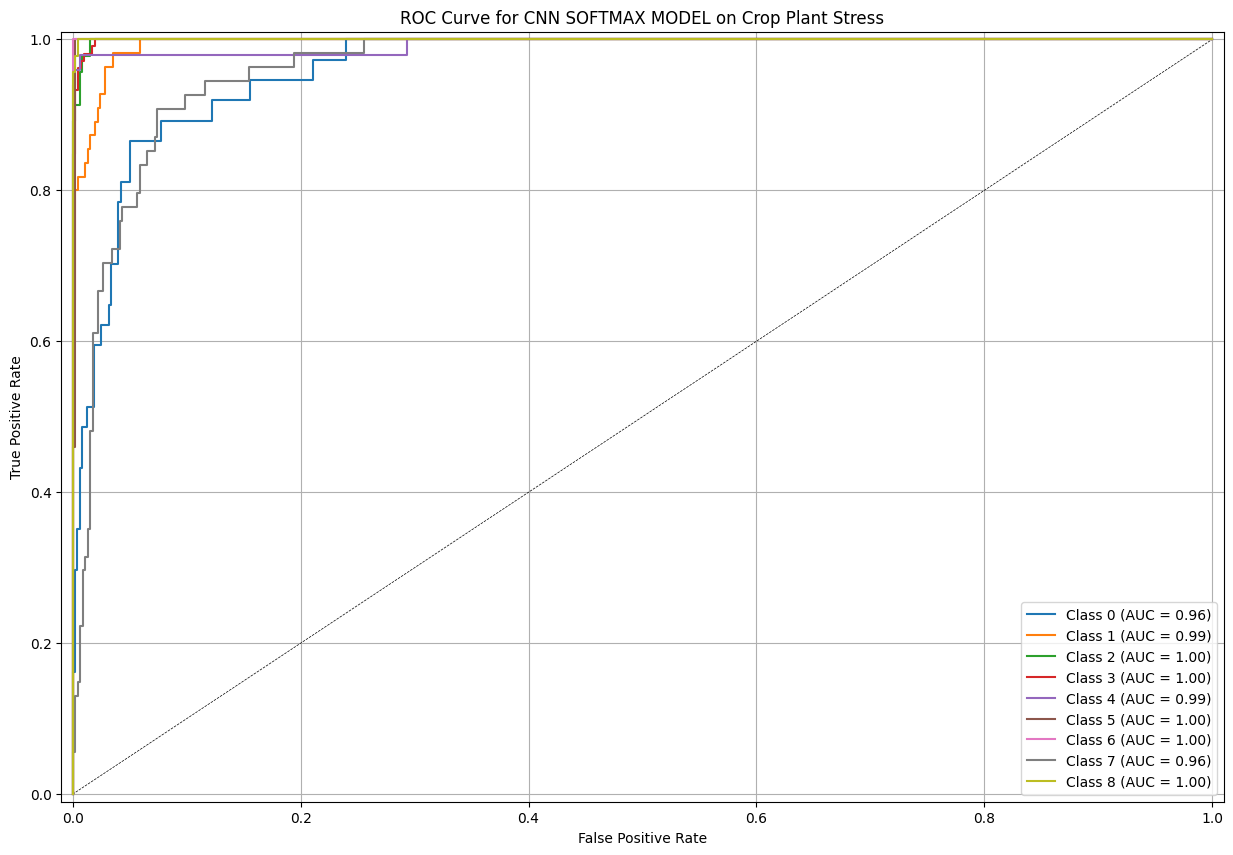

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score,auc
def plot_roc(y_test, y_pred_proba, model_name, dataset):
    n_classes = y_test.shape[1]
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred_proba.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Plot all ROC curves
    plt.figure(figsize=(15,10))
    plt.plot([0, 1], [0, 1], 'k--', linewidth=.5)
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {model_name} on {dataset}')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

plot_roc(y_test, predicted, "CNN SOFTMAX MODEL", "Crop Plant Stress")

**Confusion Matrix**

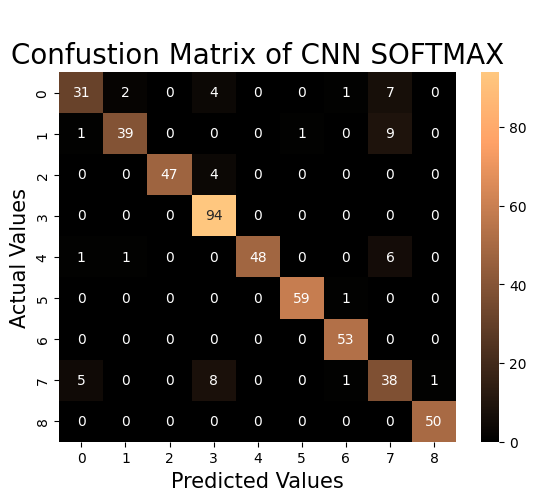

<Figure size 1500x800 with 0 Axes>

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

df_cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(predicted, axis=1))


ax = sns.heatmap(df_cm, annot=True, cmap='copper', fmt ='d')
ax.set_title('\nConfustion Matrix of CNN SOFTMAX', fontsize = 20);
ax.set_xlabel('Predicted Values', fontsize = 15)
ax.set_ylabel('Actual Values', fontsize = 15);

plt.figure(figsize = (15,8))
plt.show()

# **Creating a model using SVM algorithm**

In [ ]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV


## **Splitting the train, validation, and test**

In [ ]:
def create_dataset(data, BATCH_SIZE, num_images):
    data.reset()
    X, y = data.next()
    for i in tqdm.tqdm(range(int(num_images/BATCH_SIZE))):
        img, label = data.next()
        X = np.append(X, img, axis=0)
        y = np.append(y, label, axis=0)
        if i == int(num_images/BATCH_SIZE)-1:
            break
    
    return X, y

num_train = 3000
num_test = 500
num_val = 900

X_train, y_train = create_dataset(train_gen, BATCH_SIZE, num_train)
X_val, y_val = create_dataset(validation_gen, BATCH_SIZE, num_val)
X_test, y_test = create_dataset(test_gen, BATCH_SIZE, num_test)

 93%|█████████▎| 14/15 [00:00<00:00, 37.59it/s]


In [ ]:
y_train = np.argmax(y_train, axis=1)
y_val = np.argmax(y_val, axis=1)
y_test = np.argmax(y_test, axis=1)

## **Features extraction of train, validation, and test**

In [ ]:
X_train_features = model.predict(X_train.reshape(-1, 75, 75, 3))


94/94 [==============================] - 1s 11ms/step


In [ ]:
X_train_features

array([[5.5049992e-10, 9.8322717e-10, 3.9545748e-17, ..., 1.0000000e+00,
        1.4189675e-08, 3.7554709e-11],
       [7.4934337e-06, 1.6882761e-04, 2.1187015e-08, ..., 2.4896875e-01,
        7.9670521e-05, 1.4884483e-04],
       [4.5379893e-06, 5.3034062e-09, 1.8949440e-06, ..., 6.4418265e-07,
        7.5163189e-07, 3.5964653e-10],
       ...,
       [7.8195035e-01, 4.3949485e-03, 1.6757422e-04, ..., 1.9990806e-05,
        2.1299526e-01, 1.0215745e-04],
       [9.2336856e-04, 5.8598830e-03, 1.1715373e-05, ..., 9.2213690e-02,
        5.9290705e-03, 2.0565826e-03],
       [2.8901657e-03, 4.2406045e-02, 1.6256316e-01, ..., 2.3558494e-05,
        1.8583886e-02, 8.5241807e-04]], dtype=float32)

In [ ]:
X_test_features = model.predict(X_test.reshape(-1, 75, 75, 3))

16/16 [==============================] - 0s 11ms/step


In [ ]:
X_test_features

array([[1.4073987e-01, 1.6428687e-04, 3.1308641e-04, ..., 4.6366054e-04,
        7.1642429e-02, 5.2774056e-05],
       [6.8761721e-02, 5.3622544e-01, 6.2697813e-02, ..., 2.4505600e-03,
        1.9992310e-01, 1.3343862e-03],
       [1.0760412e-04, 4.2427056e-03, 1.5167198e-05, ..., 5.4520783e-06,
        9.3772570e-03, 3.8712515e-05],
       ...,
       [2.1191092e-06, 8.4366931e-08, 9.9998415e-01, ..., 1.1216331e-11,
        5.4506228e-07, 5.7883270e-08],
       [1.5959718e-05, 1.2359282e-08, 1.5983329e-05, ..., 1.8968556e-06,
        2.3770829e-06, 7.5496462e-09],
       [2.7497617e-05, 1.2336809e-09, 3.5739217e-06, ..., 1.0925296e-07,
        1.0044896e-06, 2.8453273e-10]], dtype=float32)

In [ ]:
X_val_features = model.predict(X_val.reshape(-1, 75, 75, 3))

29/29 [==============================] - 0s 11ms/step


In [ ]:
X_val_features

array([[1.30694032e-01, 3.10104602e-04, 1.13323098e-03, ...,
        4.35546172e-05, 2.85507739e-02, 8.36749375e-01],
       [8.32268715e-01, 2.51614628e-03, 9.66658723e-03, ...,
        2.22933618e-03, 7.53689259e-02, 1.33323791e-02],
       [3.02239638e-02, 3.01440101e-04, 2.14794796e-04, ...,
        1.35142063e-05, 1.29058007e-02, 9.53646362e-01],
       ...,
       [7.83854717e-11, 2.69133691e-11, 1.82307085e-20, ...,
        1.00000000e+00, 5.66613823e-09, 6.03993851e-14],
       [1.67037314e-07, 2.12751518e-04, 1.11546865e-11, ...,
        1.67246224e-04, 1.84742948e-05, 5.21899119e-06],
       [3.52301214e-07, 2.40526301e-08, 9.99994874e-01, ...,
        1.26406557e-12, 1.23579218e-06, 7.15751511e-08]], dtype=float32)

## **Using Gridsearch to find best parameters**

In [ ]:
#Train
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

param_grid_SVC={'C': [0.001, 0.01, 0.05, 0.1, 0.5, 1.0, 10.0],
                'gamma': [0.001, 0.01, 0.05, 0.1, 0.5, 1.0],
                'kernel': ['linear', 'rbf', 'polynomial']}

SVC_cv=GridSearchCV(estimator=SVC(),
                     param_grid = param_grid_SVC,
                     scoring='accuracy',
                     cv=10,
                     refit=True,
                     n_jobs=1)
SVC_cv.fit(X_train_features,y_train)
print("tuned hpyerparameters :(best parameters) ",SVC_cv.best_params_)

tuned hpyerparameters :(best parameters)  {'C': 10.0, 'gamma': 1.0, 'kernel': 'rbf'}


In [ ]:
SVCmodel = SVC(C =10.0,
               gamma = 0.001,
               kernel = 'linear',
               probability=True)

In [ ]:
SVCmodel.fit(X_train_features,y_train)

SVC(C=10.0, gamma=0.001, kernel='linear', probability=True)

In [ ]:
y_pred = SVCmodel.predict(X_test_features)

## **Using Random Search to find best parameters**

In [ ]:
#Train
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV

param_rand_SVC={'C': [0.001, 0.01, 0.05, 0.1, 0.5, 1.0, 10.0],
                'gamma': [0.001, 0.01, 0.05, 0.1, 0.5, 1.0],
                'kernel': ['linear', 'rbf', 'polynomial']}

SVC_cv3=RandomizedSearchCV(estimator=SVC(),
                     param_distributions = param_rand_SVC,
                     scoring='accuracy',
                     cv=10,
                     refit=True,
                     n_jobs=1)
SVC_cv3.fit(X_train_features,y_train)

print("tuned hpyerparameters :(best parameters) ",SVC_cv3.best_params_)


tuned hpyerparameters :(best parameters)  {'kernel': 'linear', 'gamma': 0.5, 'C': 10.0}


In [ ]:
SVCmodel1 = SVC(C =10.0,
               gamma = 0.5,
               kernel = 'linear',
               probability=True)

In [ ]:
SVCmodel1.fit(X_train_features,y_train)

SVC(C=10.0, gamma=0.5, kernel='linear', probability=True)

In [ ]:
y_pred1 = SVCmodel.predict(X_test_features)

## **Evaluating the model of CNN+SVM model**

**Accuracy score of train, validation, and valid**

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
#Grid Search
print("accuracy score of training :",SVC_cv.best_score_)
print("accuracy score of test :",accuracy_score(y_test,y_pred))

accuracy score of training : 0.9325105204872648
accuracy score of test : 0.900390625


In [ ]:
#Random Search
print("accuracy score of training :",SVC_cv3.best_score_)
print("accuracy score of test :",accuracy_score(y_test,y_pred1))

accuracy score of training : 0.9358194905869324
accuracy score of test : 0.900390625


**Classification report**

In [ ]:
from sklearn.metrics import classification_report
print("Classification report of CNN SVC with Grid Search")
print(classification_report(y_test, y_pred))

Classification report of CNN SVC with Grid Search
              precision    recall  f1-score   support

           0       0.82      0.57      0.68        47
           1       0.88      0.73      0.80        48
           2       0.96      0.96      0.96        56
           3       0.96      0.97      0.97       110
           4       0.96      0.88      0.92        59
           5       0.98      0.96      0.97        48
           6       0.97      1.00      0.98        56
           7       0.59      0.91      0.72        46
           8       1.00      1.00      1.00        42

    accuracy                           0.90       512
   macro avg       0.90      0.89      0.89       512
weighted avg       0.91      0.90      0.90       512



In [ ]:
from sklearn.metrics import classification_report
print("Classification report of CNN SVC with Random Search")
print(classification_report(y_test, y_pred1))

Classification report of CNN SVC with Random Search
              precision    recall  f1-score   support

           0       0.82      0.57      0.68        47
           1       0.88      0.73      0.80        48
           2       0.96      0.96      0.96        56
           3       0.96      0.97      0.97       110
           4       0.96      0.88      0.92        59
           5       0.98      0.96      0.97        48
           6       0.97      1.00      0.98        56
           7       0.59      0.91      0.72        46
           8       1.00      1.00      1.00        42

    accuracy                           0.90       512
   macro avg       0.90      0.89      0.89       512
weighted avg       0.91      0.90      0.90       512



**ROC AUC CURVE**

roc-auc is 0.990


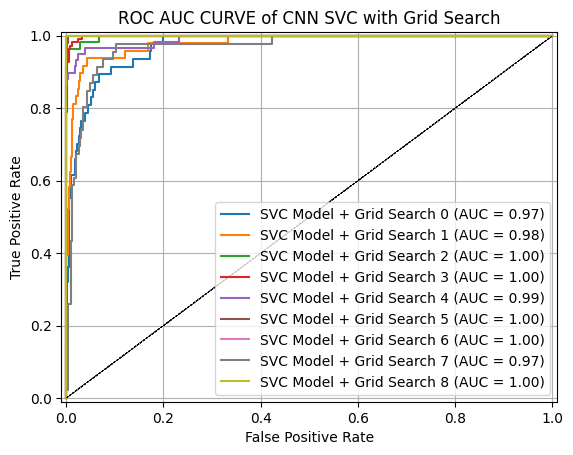

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
def plot_roc(y_true, y_proba, class_name):
    fpr, tpr, thr = roc_curve(y_true, y_proba)
    plt.plot(fpr, tpr, label='{} (AUC = {:.2f})'.format(class_name, roc_auc_score(y_true, y_proba)))
    plt.plot([0, 1], [0, 1], 'k--', linewidth=.5)
    plt.grid(True)
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC AUC CURVE of CNN SVC with Grid Search')
    plt.legend(loc="lower right")

y_proba = SVCmodel.predict_proba(X_test_features)
print('roc-auc is {:.3f}'.format(roc_auc_score(y_test,y_proba, multi_class='ovr')))
for i in range(9):
    y_true_i = (y_test == i)
    y_pred_i = y_proba[:, i]
    plot_roc(y_true_i, y_pred_i, 'SVC Model + Grid Search {}'.format(i))

roc-auc is 0.990


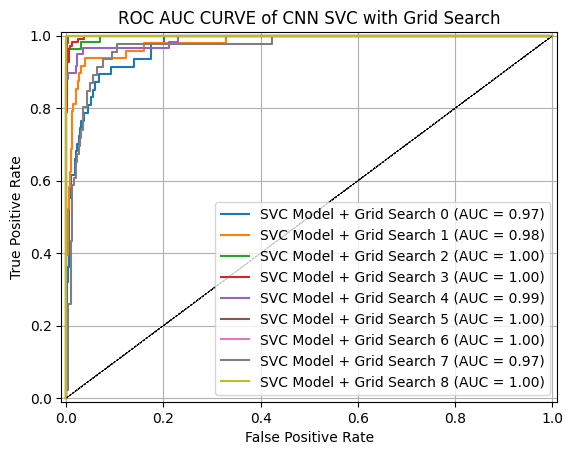

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
def plot_roc(y_true, y_proba, class_name):
    fpr, tpr, thr = roc_curve(y_true, y_proba)
    plt.plot(fpr, tpr, label='{} (AUC = {:.2f})'.format(class_name, roc_auc_score(y_true, y_proba)))
    plt.plot([0, 1], [0, 1], 'k--', linewidth=.5)
    plt.grid(True)
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC AUC CURVE of CNN SVC with Grid Search')
    plt.legend(loc="lower right")

y_proba = SVCmodel1.predict_proba(X_test_features)
print('roc-auc is {:.3f}'.format(roc_auc_score(y_test,y_proba, multi_class='ovr')))
for i in range(9):
    y_true_i = (y_test == i)
    y_pred_i = y_proba[:, i]
    plot_roc(y_true_i, y_pred_i, 'SVC Model + Grid Search {}'.format(i))

**Confusion Matrix**

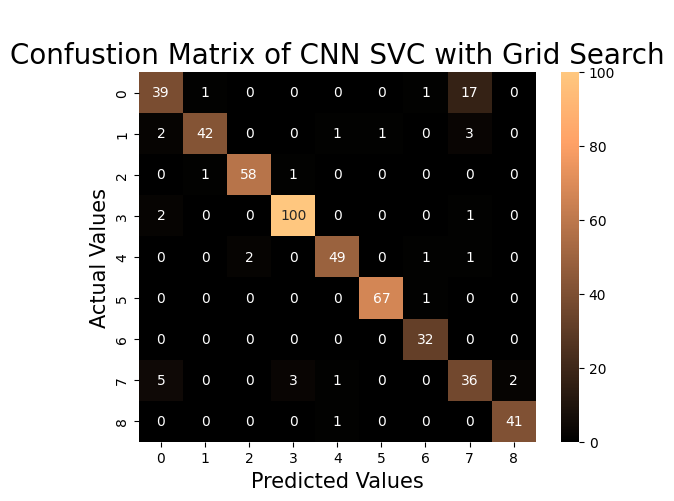

<Figure size 1500x800 with 0 Axes>

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

df_cm = confusion_matrix(y_test, y_pred)

ax = sns.heatmap(df_cm, annot=True, cmap='copper', fmt ='d')
ax.set_title('\nConfustion Matrix of CNN SVC with Grid Search', fontsize = 20);
ax.set_xlabel('Predicted Values', fontsize = 15)
ax.set_ylabel('Actual Values', fontsize = 15);

plt.figure(figsize = (15,8))
plt.show()

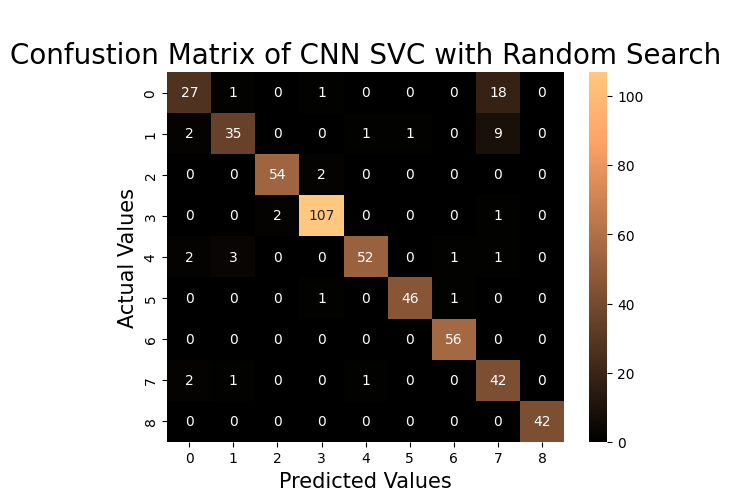

<Figure size 1500x800 with 0 Axes>

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

df_cm = confusion_matrix(y_test, y_pred1)

ax = sns.heatmap(df_cm, annot=True, cmap='copper', fmt ='d')
ax.set_title('\nConfustion Matrix of CNN SVC with Random Search', fontsize = 20);
ax.set_xlabel('Predicted Values', fontsize = 15)
ax.set_ylabel('Actual Values', fontsize = 15);

plt.figure(figsize = (15,8))
plt.show()